In [1]:
# BATCH:256
# batch_size:256
# data_path:"/data2"
# decay:0.7834769413661389
# EPOCH:20
# hard_reset:true
# IMAGE_SIZE:32
# learning_rate:0.007176761798504128
# pre_spike_weight:5.165214142219577
# rate_coding:true
# TIME_STEP:9
# time_step:9
# v_decay:0.7834769413661389
# v_reset:0
# v_threshold:1
# which_data:"CIFAR10"


# BATCH:256
# batch_size:256
# data_path:"/data2"
# decay:0.38993471232202725
# EPOCH:20
# hard_reset:true
# IMAGE_SIZE:28
# learning_rate:0.06285718352377828
# pre_spike_weight:6.21970124592063
# rate_coding:true
# TIME_STEP:16
# time_step:16
# v_decay:0.38993471232202725
# v_reset:0
# v_threshold:1
# which_data:"MNIST"

# BATCH:64
# batch_size:64
# data_path:"/data2"
# decay:0.9266077968579136
# EPOCH:20
# hard_reset:true
# IMAGE_SIZE:28
# learning_rate:0.07732456724854177
# pre_spike_weight:1.5377416716615555
# rate_coding:true
# TIME_STEP:7
# time_step:7
# v_decay:0.9266077968579136
# v_reset:0
# v_threshold:1
# which_data:"FASHION_MNIST"

In [2]:
# Copyright (c) 2024 Byeonghyeon Kim 
# github site: https://github.com/bhkim003/ByeonghyeonKim
# email: bhkim003@snu.ac.kr
 
# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in
# the Software without restriction, including without limitation the rights to
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
# the Software, and to permit persons to whom the Software is furnished to do so,
# subject to the following conditions:
 
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
# FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
# COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
# IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.


In [3]:
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt


from snntorch import spikegen

 
import wandb

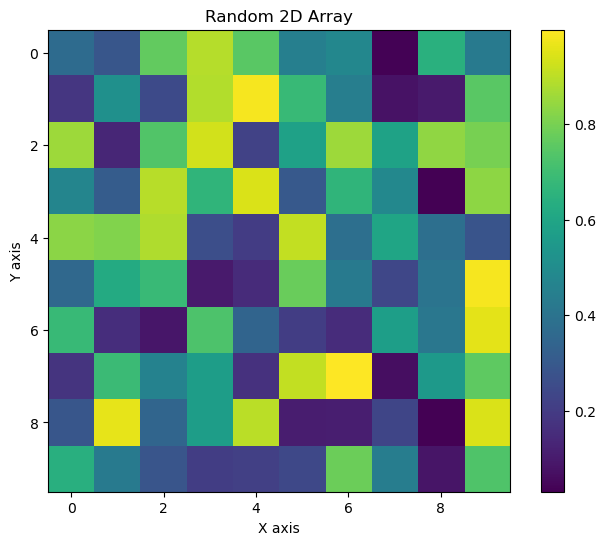

In [4]:
# my module import
from modules import *

In [5]:
    
class RESERVOIR(nn.Module):
    def __init__ (self, TIME_STEP=8, in_spike_size=28, in_channel=1, receptive_size=3, v_init=0, v_decay=0.6, v_threshold=1, v_reset=0, hard_reset=True, pre_spike_weight=1):
        super(RESERVOIR, self).__init__()
        self.TIME_STEP = TIME_STEP
        self.in_spike_size = in_spike_size
        self.in_channel = in_channel
        self.receptive_size = receptive_size #3
        self.v_init = v_init
        self.v_decay = v_decay
        self.v_threshold = v_threshold
        self.v_reset = v_reset
        self.hard_reset = hard_reset
        self.pre_spike_weight = pre_spike_weight

        self.out_channel = 1

        # 파라미터 
        self.conv_depthwise = nn.Conv2d(in_channels=self.in_channel, out_channels=self.in_channel, 
                                        kernel_size=self.receptive_size, 
                                        stride=1, padding=1, groups=self.in_channel)

        # kaiming 초기화
        nn.init.kaiming_normal_(self.conv_depthwise.weight, mode='fan_out', nonlinearity='relu')
        nn.init.constant_(self.conv_depthwise.bias, 0)

        # membrane potential 초기화
        self.v = torch.full((self.in_channel, self.in_spike_size, self.in_spike_size), fill_value=self.v_init, requires_grad=False)

        
    def forward(self, pre_spike):    
        # pre_spike [TIME_STEP, batch_size, in_channel, in_spike_size, in_spike_size]

        v = torch.full_like(pre_spike[0], fill_value=self.v_init, requires_grad=False)
        post_spike = torch.zeros_like(pre_spike[0], requires_grad=False)
        # v [batch_size, in_channel, in_spike_size, in_spike_size]
        # recurrent [batch_size, in_channel, in_spike_size, in_spike_size]

        # timestep 안 맞으면 종료
        assert pre_spike.size(0) == self.TIME_STEP, f"Time step mismatch: {pre_spike.size(0)} vs {self.TIME_STEP}"

        output = []
        for t in range (self.TIME_STEP):
            # pre_spike[t] [batch_size, in_channel, in_spike_size, in_spike_size]
            input_current = self.pre_spike_weight * pre_spike[t]
            recurrent_current = self.conv_depthwise(post_spike)
            current = input_current + recurrent_current
            # current [batch_size, in_channel, in_spike_size, in_spike_size] # kernel size 3이니까 사이즈 유지
            
            # decay and itegrate
            v = v*self.v_decay + current

            # post spike
            post_spike = (v >= self.v_threshold).float()

            output.append(post_spike)
            
            #reset
            if self.hard_reset: # hard reset
                v = (1 - post_spike)*v + post_spike*self.v_reset 
            else: # soft reset
                v = v - post_spike*self.v_threshold

        output = torch.stack(output, dim=0)
        return output

In [6]:
class NO_RESERVOIR_NET(nn.Module):
    def __init__(self, TIME_STEP=8, CLASS_NUM=10, in_spike_size=28, in_channel=1, receptive_size=3, v_init=0, v_decay=0.6, v_threshold=1, v_reset=0, hard_reset=True, pre_spike_weight=1):
        super(NO_RESERVOIR_NET, self).__init__()
        self.TIME_STEP = TIME_STEP
        self.reservoir = RESERVOIR(TIME_STEP = self.TIME_STEP, in_spike_size=in_spike_size, in_channel=in_channel, receptive_size=receptive_size, v_init=v_init, v_decay=v_decay, v_threshold=v_threshold, v_reset=v_reset, hard_reset=hard_reset, pre_spike_weight=pre_spike_weight)
        self.linear = nn.Linear(in_features=in_channel*in_spike_size*in_spike_size, out_features=CLASS_NUM)

    def forward(self, x):
        # x size [batch_size, TIME_STEP, in_channel, in_spike_size, in_spike_size]
        x = x.permute(1,0,2,3,4)
        # x size [TIME_STEP, batch_size, in_channel, in_spike_size, in_spike_size]

        # with torch.no_grad():
        #     x = self.reservoir(x) # reservoir weight는 학습 안함

        T, B, *spatial_dims = x.shape
        x = x.reshape(T * B, -1) # time,batch 축은 합쳐서 FC에 삽입

        x = self.linear(x)

        x = x.view(T , B, -1).contiguous() 
        
        x = x.mean(dim=0)
        return x

In [7]:
class RESERVOIR_NET(nn.Module):
    def __init__(self, TIME_STEP=8, CLASS_NUM=10, in_spike_size=28, in_channel=1, receptive_size=3, v_init=0, v_decay=0.6, v_threshold=1, v_reset=0, hard_reset=True, pre_spike_weight=1):
        super(RESERVOIR_NET, self).__init__()
        self.TIME_STEP = TIME_STEP
        self.reservoir = RESERVOIR(TIME_STEP = self.TIME_STEP, in_spike_size=in_spike_size, in_channel=in_channel, receptive_size=receptive_size, v_init=v_init, v_decay=v_decay, v_threshold=v_threshold, v_reset=v_reset, hard_reset=hard_reset, pre_spike_weight=pre_spike_weight)
        self.linear = nn.Linear(in_features=in_channel*in_spike_size*in_spike_size, out_features=CLASS_NUM)

    def forward(self, x):
        # x size [batch_size, TIME_STEP, in_channel, in_spike_size, in_spike_size]
        x = x.permute(1,0,2,3,4)
        # x size [TIME_STEP, batch_size, in_channel, in_spike_size, in_spike_size]

        with torch.no_grad():
            x = self.reservoir(x) # reservoir weight는 학습 안함

        T, B, *spatial_dims = x.shape
        x = x.reshape(T * B, -1) # time,batch 축은 합쳐서 FC에 삽입

        x = self.linear(x)

        x = x.view(T , B, -1).contiguous() 
        
        x = x.mean(dim=0)
        return x

In [8]:
def data_loader(which_data, data_path, rate_coding, BATCH, IMAGE_SIZE, TIME, dvs_duration, dvs_clipping):
    if which_data == 'MNIST':
        if rate_coding :
            transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0,), (1,))])
        else : 
            transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,),(0.5))])

        trainset = torchvision.datasets.MNIST(root=data_path,
                                            train=True,
                                            download=True,
                                            transform=transform)


        testset = torchvision.datasets.MNIST(root=data_path,
                                            train=False,
                                            download=True,
                                            transform=transform)

        train_loader = DataLoader(trainset,
                                batch_size =BATCH,
                                shuffle = True,
                                num_workers =2)
        test_loader = DataLoader(testset,
                                batch_size =BATCH,
                                shuffle = False,
                                num_workers =2)
        synapse_conv_in_channels = 1
        CLASS_NUM = 10


    

    elif (which_data == 'CIFAR10'):

        if rate_coding :
            # transform_train = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            #                                     transforms.RandomHorizontalFlip(),
            #                                     transforms.ToTensor()])

            # transform_test = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            #                                     transforms.ToTensor()])
            
            transform_train = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                                transforms.RandomHorizontalFlip(),
                                                transforms.ToTensor()])
                                            # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

            transform_test = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                                transforms.ToTensor()])
        
        else :
            # transform_train = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            #                                     transforms.RandomHorizontalFlip(),
            #                                     transforms.ToTensor(),
            #                                     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])
            #                                 # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

            # transform_test = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            #                                     transforms.ToTensor(),
            #                                     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),])
            #                                 # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            
            # assert IMAGE_SIZE == 32, 'OTTT랑 맞짱뜰 때는 32로 ㄱ'
            transform_train = transforms.Compose([
                transforms.RandomCrop(IMAGE_SIZE, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465),
                                    (0.2023, 0.1994, 0.2010)),
            ])
            transform_test = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465),
                                    (0.2023, 0.1994, 0.2010)),
            ])

        trainset = torchvision.datasets.CIFAR10(root=data_path,
                                            train=True,
                                            download=True,
                                            transform=transform_train)


        testset = torchvision.datasets.CIFAR10(root=data_path,
                                            train=False,
                                            download=True,
                                            transform=transform_test)
        
        
        train_loader = DataLoader(trainset,
                                batch_size =BATCH,
                                shuffle = True,
                                num_workers =2)
        test_loader = DataLoader(testset,
                                batch_size =BATCH,
                                shuffle = False,
                                num_workers =2)
        
        synapse_conv_in_channels = 3
        CLASS_NUM = 10
        '''
        classes = ('plane', 'car', 'bird', 'cat', 'deer',
                'dog', 'frog', 'horse', 'ship', 'truck') 
        '''


    elif (which_data == 'FASHION_MNIST'):

        if rate_coding :
            transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                    transforms.ToTensor()])
        else : 
            transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,),(0.5))])

        trainset = torchvision.datasets.FashionMNIST(root=data_path,
                                            train=True,
                                            download=True,
                                            transform=transform)


        testset = torchvision.datasets.FashionMNIST(root=data_path,
                                            train=False,
                                            download=True,
                                            transform=transform)

        train_loader = DataLoader(trainset,
                                batch_size =BATCH,
                                shuffle = True,
                                num_workers =2)
        test_loader = DataLoader(testset,
                                batch_size =BATCH,
                                shuffle = False,
                                num_workers =2)
        synapse_conv_in_channels = 1
        CLASS_NUM = 10
    elif (which_data == 'DVS_GESTURE'):
        data_dir = data_path + '/gesture'
        transform = None

        # # spikingjelly.datasets.dvs128_gesture.DVS128Gesture(root: str, train: bool, use_frame=True, frames_num=10, split_by='number', normalization='max')
       
        #https://spikingjelly.readthedocs.io/zh-cn/latest/activation_based_en/neuromorphic_datasets.html
        # 10ms마다 1개의 timestep하고 싶으면 위의 주소 참고. 근데 timestep이 각각 좀 다를 거임.

        
        if dvs_duration > 0:
            resize_shape = (IMAGE_SIZE, IMAGE_SIZE)
            train_data = CustomDVS128Gesture(
                data_dir, train=True, data_type='frame',  split_by='time',  duration=dvs_duration, resize_shape=resize_shape, dvs_clipping=dvs_clipping, dvs_duration_copy=dvs_duration, TIME=TIME)
            test_data = CustomDVS128Gesture(
                data_dir, train=False, data_type='frame',  split_by='time',  duration=dvs_duration, resize_shape=resize_shape, dvs_clipping=dvs_clipping, dvs_duration_copy=dvs_duration, TIME=TIME)

        else:
            train_data = CustomDVS128Gesture(
                data_dir, train=True, data_type='frame', split_by='number', frames_number=TIME, resize_shape=resize_shape, dvs_clipping=dvs_clipping, dvs_duration_copy=dvs_duration, TIME=TIME)
            test_data = CustomDVS128Gesture(data_dir, train=False,
                                            data_type='frame', split_by='number', frames_number=TIME, resize_shape=resize_shape, dvs_clipping=dvs_clipping, dvs_duration_copy=dvs_duration, TIME=TIME)
        ## 11번째 클래스 배제 ########################################################################
        exclude_class = 10
        if dvs_duration > 0:
            train_file_name = f'modules/dvs_gesture_class_index/train_indices_dvsgesture_duration_{dvs_duration}'
            test_file_name = f'modules/dvs_gesture_class_index/test_indices_dvsgesture_duration_{dvs_duration}'
            if (os.path.isfile(train_file_name) and os.path.isfile(test_file_name)):
                print('\ndvsgestrue 10th exclude class indices exist\n')
                with open(train_file_name, 'rb') as f:
                    train_indices = pickle.load(f)
                with open(test_file_name, 'rb') as f:
                    test_indices = pickle.load(f)
            else:
                print('\ndvsgestrue 10th exclude class indices doesn\'t exist\n')
                train_indices = [i for i, (_, target) in enumerate(train_data) if target != exclude_class]
                test_indices = [i for i, (_, target) in enumerate(test_data) if target != exclude_class]
                with open(train_file_name, 'wb') as f:
                    pickle.dump(train_indices, f)
                with open(test_file_name, 'wb') as f:
                    pickle.dump(test_indices, f)
        else:
            train_indices = [i for i, (_, target) in enumerate(train_data) if target != exclude_class]
            test_indices = [i for i, (_, target) in enumerate(test_data) if target != exclude_class]
        ################################################################################################
            
        # SubsetRandomSampler 생성
        train_sampler = SubsetRandomSampler(train_indices)
        test_sampler = SequentialSampler(test_indices)

        # ([B, T, 2, 128, 128]) 
        train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH, num_workers=2, sampler=train_sampler, collate_fn=pad_sequence_collate)
        test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=BATCH, num_workers=2, sampler=test_sampler, collate_fn=pad_sequence_collate)
        synapse_conv_in_channels = 2
        CLASS_NUM = 10
        # mapping = { 0 :'Hand Clapping'  1 :'Right Hand Wave'2 :'Left Hand Wave' 3 :'Right Arm CW'   4 :'Right Arm CCW'  5 :'Left Arm CW'    6 :'Left Arm CCW'   7 :'Arm Roll'       8 :'Air Drums'      9 :'Air Guitar'     10:'Other'}


    else:
        assert False, 'wrong dataset name'


    
    return train_loader, test_loader, synapse_conv_in_channels, CLASS_NUM

In [9]:
def train(model, train_loader, criterion, optimizer, device, rate_coding, TIME_STEP, which_data):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    iterator = enumerate(train_loader, 0)
    for i, data in iterator:
    # for i, (inputs, labels) in enumerate(train_loader):
        if len(data) == 2:
            inputs, labels = data
            # 처리 로직 작성
        elif len(data) == 3:
            inputs, labels, x_len = data

        inputs, labels = inputs.to(device), labels.to(device)

        # if rate_coding == True:
        #     inputs = spikegen.rate(inputs, num_steps=TIME_STEP)
        # else:
        #     inputs = inputs.repeat(TIME_STEP, 1, 1, 1, 1)
        

        ###########################################################################################################################        
        if (which_data == 'n_tidigits'):
            inputs = inputs.permute(0, 1, 3, 2, 4)
            labels = labels[:, 0, :]
            labels = torch.argmax(labels, dim=1)
        elif (which_data == 'heidelberg'):
            inputs = inputs.view(5, 1000, 1, 700, 1)
            print("\n\n\n경고!!!! heidelberg 이거 타임스텝이랑 채널 잘 바꿔줘라!!!\n\n\n\n")
        # print('inputs',inputs.size(),'\nlabels',labels.size())
        # print(labels)
            
        if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
            inputs = inputs.permute(1, 0, 2, 3, 4)
        elif rate_coding == True :
            inputs = spikegen.rate(inputs, num_steps=TIME_STEP)
        else :
            inputs = inputs.repeat(TIME_STEP, 1, 1, 1, 1)
        # inputs: [Time, Batch, Channel, Height, Width]  
        ####################################################################################################################### 

        
        
        
        
        inputs = inputs.permute(1, 0, 2, 3, 4)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        iter_correct = (predicted == labels).sum().item()
        correct += iter_correct
        # if i % 100 == 99:
        # print(f"[{i+1}] loss: {running_loss / 100:.3f}")
        # running_loss = 0.0
        iter_accuracy = 100 * iter_correct / labels.size(0)
        wandb.log({"iter_accuracy": iter_accuracy})
    tr_accuracy = 100 * correct / total         
    wandb.log({"tr_accuracy": tr_accuracy})
    print(f"Train Accuracy: {tr_accuracy:.2f}%")
    
def test(model, test_loader, criterion, device, rate_coding, TIME_STEP, which_data):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    iterator = enumerate(test_loader, 0)
    with torch.no_grad():
        for i, data in iterator:
        # for inputs, labels in test_loader:
            if len(data) == 2:
                inputs, labels = data
                # 처리 로직 작성
            elif len(data) == 3:
                inputs, labels, x_len = data
                
            inputs, labels = inputs.to(device), labels.to(device)

            # if rate_coding == True:
            #     inputs = spikegen.rate(inputs, num_steps=TIME_STEP)
            # else:
            #     inputs = inputs.repeat(TIME_STEP, 1, 1, 1, 1)

        

            ###########################################################################################################################        
            if (which_data == 'n_tidigits'):
                inputs = inputs.permute(0, 1, 3, 2, 4)
                labels = labels[:, 0, :]
                labels = torch.argmax(labels, dim=1)
            elif (which_data == 'heidelberg'):
                inputs = inputs.view(5, 1000, 1, 700, 1)
                print("\n\n\n경고!!!! heidelberg 이거 타임스텝이랑 채널 잘 바꿔줘라!!!\n\n\n\n")
            # print('inputs',inputs.size(),'\nlabels',labels.size())
            # print(labels)
                
            if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                inputs = inputs.permute(1, 0, 2, 3, 4)
            elif rate_coding == True :
                inputs = spikegen.rate(inputs, num_steps=TIME_STEP)
            else :
                inputs = inputs.repeat(TIME_STEP, 1, 1, 1, 1)
            # inputs: [Time, Batch, Channel, Height, Width]  
            ####################################################################################################################### 

        


            inputs = inputs.permute(1, 0, 2, 3, 4)
        
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_accuracy = 100 * correct / total
    wandb.log({"val_accuracy": val_accuracy})
    print(f"Test loss: {test_loss / len(test_loader):.3f}, Val Accuracy: {val_accuracy:.2f}%")


In [10]:
def main(data_path='/data2', which_data='MNIST', gpu = '3',learning_rate = 0.0001, BATCH=5, IMAGE_SIZE=28, TIME_STEP=8, EPOCH=10, rate_coding=True, v_decay= 0.6,
v_threshold=1, v_reset=0, hard_reset=True, pre_spike_weight=1, dvs_duration=1000000, dvs_clipping=True, no_reservoir = False):
    os.environ["CUDA_VISIBLE_DEVICES"]= gpu
    # run = wandb.init(project=f'reservoir')

    hyperparameters = locals()

    wandb.config.update(hyperparameters)
    wandb.run.name = f'{which_data}_sweeprun_epoch{EPOCH}'
    wandb.run.log_code(".", include_fn=lambda path: path.endswith(".py") or path.endswith(".ipynb"))

    train_loader, test_loader, in_channel, CLASS_NUM = data_loader(
        which_data=which_data, data_path=data_path, rate_coding=rate_coding, BATCH=BATCH, IMAGE_SIZE=IMAGE_SIZE, TIME=TIME_STEP, dvs_duration=dvs_duration, dvs_clipping=dvs_clipping)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if no_reservoir == True:
        net = NO_RESERVOIR_NET(TIME_STEP=TIME_STEP, CLASS_NUM=CLASS_NUM, in_spike_size=IMAGE_SIZE, in_channel=in_channel, receptive_size=3, v_init=0, v_decay=v_decay, v_threshold=v_threshold, v_reset=v_reset, hard_reset=hard_reset, pre_spike_weight=pre_spike_weight)
    else:
        net = RESERVOIR_NET(TIME_STEP=TIME_STEP, CLASS_NUM=CLASS_NUM, in_spike_size=IMAGE_SIZE, in_channel=in_channel, receptive_size=3, v_init=0, v_decay=v_decay, v_threshold=v_threshold, v_reset=v_reset, hard_reset=hard_reset, pre_spike_weight=pre_spike_weight)
    net = net.to(device)
    wandb.watch(net, log="all", log_freq = 1) #gradient, parameter logging해줌

    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0)

    print(net)

    for epoch in range(EPOCH):
        print(f"Epoch {epoch+1}")
        train(net, train_loader, criterion, optimizer, device, rate_coding, TIME_STEP, which_data)
        test(net, test_loader, criterion, device, rate_coding, TIME_STEP, which_data)
        # torch.save(net.state_dict(), 'net_save/reservoir_net.pth')
        # artifact = wandb.Artifact('model', type='model')
        # artifact.add_file('net_save/reservoir_net.pth')
        # run.log_artifact(artifact)
        wandb.log({"epoch": epoch})



In [11]:
# # sweep 하기 싫을 때
# wandb.init(project=f'reservoir')
# main(data_path='/data2', which_data='CIFAR10', gpu = '3', learning_rate = 0.0072, BATCH=256, IMAGE_SIZE=32, TIME_STEP=9, EPOCH=50, rate_coding=True, v_decay= 0.78,
# v_threshold=1, v_reset=0, hard_reset=True, pre_spike_weight=5.0, dvs_duration=1000000, dvs_clipping=True, no_reservoir = False)

In [12]:
# sweep하고싶을 때
def sweep_cover(data_path='/data2', which_data='CIFAR10', gpu = '4', learning_rate = 0.0001, BATCH=5, IMAGE_SIZE=28, TIME_STEP=8, EPOCH=3, rate_coding=True, v_decay= 0.6,
v_threshold=1, v_reset=0, hard_reset=True, pre_spike_weight=1, dvs_duration=1000000, dvs_clipping=True, no_reservoir = False):
    
    wandb.init(save_code = True)

    learning_rate  =  wandb.config.learning_rate
    BATCH  =  wandb.config.batch_size
    TIME_STEP  =  wandb.config.time_step
    v_decay  =  wandb.config.decay
    pre_spike_weight  =  wandb.config.pre_spike_weight
    which_data  =  wandb.config.which_data
    data_path  =  wandb.config.data_path
    rate_coding  =  wandb.config.rate_coding
    EPOCH  =  wandb.config.EPOCH
    IMAGE_SIZE  =  wandb.config.IMAGE_SIZE
    dvs_duration  =  wandb.config.dvs_duration
    dvs_clipping  =  wandb.config.dvs_clipping
    no_reservoir  =  wandb.config.no_reservoir
    main(data_path=data_path, which_data=which_data, gpu = gpu, learning_rate = learning_rate, BATCH=BATCH, IMAGE_SIZE=IMAGE_SIZE, TIME_STEP=TIME_STEP, EPOCH=EPOCH, rate_coding=rate_coding, v_decay= v_decay,
v_threshold=v_threshold, v_reset=v_reset, hard_reset=hard_reset, pre_spike_weight=pre_spike_weight, dvs_duration=dvs_duration, dvs_clipping=dvs_clipping, no_reservoir = no_reservoir)



which_data_hyper = 'DVS_GESTURE' # 'MNIST', 'CIFAR10' ', 'FASHION_MNIST', 'DVS_GESTURE'
data_path_hyper = '/data2'

sweep_configuration = {
    'method': 'bayes',
    'name': which_data_hyper,
    'metric': {'goal': 'maximize', 'name': 'val_accuracy'},
    'parameters': 
    {
        "learning_rate": {"min": 0.00001, "max": 0.1},
        "batch_size": {"values": [16, 32, 64, 128, 256]},
        "time_step": {"values": [4,5,6,7,8,9,10,11,12]},
        "decay": {"min": 0.25, "max": 1.0},
        "pre_spike_weight": {"min": 0.5, "max": 10.0},
        "which_data": {"values": [which_data_hyper]},
        "data_path": {"values": [data_path_hyper]},
        "rate_coding": {"values": [True, False]},
        "EPOCH": {"values": [20]},
        "IMAGE_SIZE": {"values": [16,32,48,128]},
        "dvs_duration": {"values": [100000]},
        "dvs_clipping": {"values": [True]},
        "no_reservoir": {"values": [True, False]},
     }
}

sweep_id = wandb.sweep(sweep=sweep_configuration, project=f'reservoir')
wandb.agent(sweep_id, function=sweep_cover, count=10000)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: r2y8yym7
Sweep URL: https://wandb.ai/bhkim003-seoul-national-university/reservoir/sweeps/r2y8yym7


wandb: Agent Starting Run: 9x0s3z8w with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.8205614341403393
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.09376399117836123
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.415579574193588
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bhkim003 (bhkim003-seoul-national-university). Use `wandb login --relogin` to force relogin


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 25.97%
Test loss: 73.816, Val Accuracy: 24.62%
Epoch 2
Train Accuracy: 36.83%
Test loss: 59.757, Val Accuracy: 39.39%
Epoch 3
Train Accuracy: 49.54%
Test loss: 47.115, Val Accuracy: 35.61%
Epoch 4
Train Accuracy: 55.94%
Test loss: 27.708, Val Accuracy: 57.20%
Epoch 5
Train Accuracy: 65.96%
Test loss: 22.554, Val Accuracy: 56.82%
Epoch 6
Train Accuracy: 71.80%
Test loss: 14.103, Val Accuracy: 61.36%
Epoch 7
Train Accuracy: 74.03%
Test loss: 14.898, Val Accuracy: 62.50%
Epoch 8
Train Accuracy: 82.10%
Test loss: 11.627, Val Accuracy: 69.32%
Epoch 9
Train Accuracy: 84.60%
Test loss: 12.692, V

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▂▃▃▃▃▅▅▅▅▆▅▆▆▇▇▆▆▇▇█▇█▇▇▇███▇████▇████
tr_accuracy,▁▂▃▄▅▅▆▆▇▇▇▇▇▇██████
val_accuracy,▁▃▃▆▆▆▇█▇▇▇▇▇▇█▇▇█▇█
epoch,19
iter_accuracy,100.0
tr_accuracy,98.51577
val_accuracy,68.56061


wandb: Agent Starting Run: twqovuoz with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 16
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.5999127218860145
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.06612271477604525
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.0570593018270005
wandb: 	rate_coding: False
wandb: 	time_step: 9
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=512, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 33.30%
Test loss: 1.562, Val Accuracy: 46.21%
Epoch 2
Train Accuracy: 54.36%
Test loss: 1.444, Val Accuracy: 51.14%
Epoch 3
Train Accuracy: 66.05%
Test loss: 1.280, Val Accuracy: 52.65%
Epoch 4
Train Accuracy: 71.34%
Test loss: 1.230, Val Accuracy: 59.09%
Epoch 5
Train Accuracy: 73.75%
Test loss: 1.144, Val Accuracy: 59.09%
Epoch 6
Train Accuracy: 74.40%
Test loss: 1.208, Val Accuracy: 60.23%
Epoch 7
Train Accuracy: 79.41%
Test loss: 1.258, Val Accuracy: 61.36%
Epoch 8
Train Accuracy: 79.87%
Test loss: 1.145, Val Accuracy: 59.47%
Epoch 9
Train Accuracy: 83.30%
Test loss: 1.050, Val Accur

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▅▃▃▅▅▅▆▇▆▆▆▇▇▇█▇▇▇▆▆▇▇▇█▇█▇█████▇▇▇████
tr_accuracy,▁▄▅▆▆▆▇▇▇▇▇▇▇███████
val_accuracy,▁▃▃▅▅▆▆▅▇▇▆▇▇▇█▇▆███
epoch,19
iter_accuracy,90.74074
tr_accuracy,90.07421
val_accuracy,66.28788


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lmciaub6 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 16
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.6361841193374299
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.08643614927021905
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.6816220502620847
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=512, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 18.55%
Test loss: 2.280, Val Accuracy: 24.62%
Epoch 2
Train Accuracy: 34.04%
Test loss: 1.736, Val Accuracy: 38.26%
Epoch 3
Train Accuracy: 52.23%
Test loss: 1.724, Val Accuracy: 41.67%
Epoch 4
Train Accuracy: 56.86%
Test loss: 1.554, Val Accuracy: 45.08%
Epoch 5
Train Accuracy: 60.85%
Test loss: 1.551, Val Accuracy: 44.32%
Epoch 6
Train Accuracy: 62.89%
Test loss: 1.493, Val Accuracy: 47.35%
Epoch 7
Train Accuracy: 65.21%
Test loss: 1.544, Val Accuracy: 45.83%
Epoch 8
Train Accuracy: 68.92%
Test loss: 1.438, Val Accuracy: 47.73%
Epoch 9
Train Accuracy: 71.61%
Test loss: 1.390, Val Accur

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▂▃▅▅▅▅▅▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇██▇▇██
tr_accuracy,▁▃▅▅▆▆▆▆▇▇▇▇▇▇██████
val_accuracy,▁▄▅▆▆▇▆▇█▇▇▇▇███████
epoch,19
iter_accuracy,81.48148
tr_accuracy,83.48794
val_accuracy,52.65152


wandb: Agent Starting Run: 1svdgaei with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.7377503436393351
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.03779158330035504
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.6130240892481154
wandb: 	rate_coding: True
wandb: 	time_step: 9
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 46.20%
Test loss: 7.720, Val Accuracy: 44.70%
Epoch 2
Train Accuracy: 64.66%
Test loss: 8.976, Val Accuracy: 55.30%
Epoch 3
Train Accuracy: 74.86%
Test loss: 6.816, Val Accuracy: 59.47%
Epoch 4
Train Accuracy: 84.04%
Test loss: 4.159, Val Accuracy: 57.20%
Epoch 5
Train Accuracy: 84.42%
Test loss: 4.474, Val Accuracy: 64.77%
Epoch 6
Train Accuracy: 87.57%
Test loss: 6.218, Val Accuracy: 59.09%
Epoch 7
Train Accuracy: 86.27%
Test loss: 5.675, Val Accuracy: 64.39%
Epoch 8
Train Accuracy: 90.26%
Test loss: 5.935, Val Accuracy: 65.15%
Epoch 9
Train Accuracy: 96.10%
Test loss: 6.273, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▁▃▂▅▅▆▆▆▅█▆▇▆▆▇████████████████████████
tr_accuracy,▁▃▅▆▆▆▆▇▇███████████
val_accuracy,▁▄▆▅▇▆▇▇▇▇▇▇████████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,67.04545


wandb: Agent Starting Run: ctej3dvl with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.3441106270184617
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.09366666652419056
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.7731555432278077
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 43.41%
Test loss: 2.901, Val Accuracy: 49.62%
Epoch 2
Train Accuracy: 66.14%
Test loss: 3.314, Val Accuracy: 56.82%
Epoch 3
Train Accuracy: 77.74%
Test loss: 2.611, Val Accuracy: 53.03%
Epoch 4
Train Accuracy: 85.06%
Test loss: 1.943, Val Accuracy: 64.39%
Epoch 5
Train Accuracy: 90.35%
Test loss: 2.169, Val Accuracy: 62.88%
Epoch 6
Train Accuracy: 96.20%
Test loss: 1.876, Val Accuracy: 62.50%
Epoch 7
Train Accuracy: 97.87%
Test loss: 1.811, Val Accuracy: 63.26%
Epoch 8
Train Accuracy: 99.81%
Test loss: 1.861, Val Accuracy: 62.88%
Epoch 9
Train Accuracy: 100.00%
Test loss: 1.751, Val Acc

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▁▅▃▆▅▇▇▇██▇▇███████████████████████████
tr_accuracy,▁▄▅▆▇███████████████
val_accuracy,▁▄▂▆▆▆▆▆███████████▇
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,67.04545


wandb: Agent Starting Run: it1b99mc with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.8261405874155671
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.021388557645593408
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.846733988137918
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 36.46%
Test loss: 1.567, Val Accuracy: 49.24%
Epoch 2
Train Accuracy: 61.04%
Test loss: 1.335, Val Accuracy: 56.82%
Epoch 3
Train Accuracy: 67.35%
Test loss: 1.426, Val Accuracy: 52.65%
Epoch 4
Train Accuracy: 72.73%
Test loss: 1.133, Val Accuracy: 65.15%
Epoch 5
Train Accuracy: 83.95%
Test loss: 1.127, Val Accuracy: 59.85%
Epoch 6
Train Accuracy: 89.33%
Test loss: 1.163, Val Accuracy: 66.67%
Epoch 7
Train Accuracy: 91.47%
Test loss: 0.953, Val Accuracy: 68.56%
Epoch 8
Train Accuracy: 96.20%
Test loss: 1.024, Val Accuracy: 68.56%
Epoch 9
Train Accuracy: 98.05%
Test loss: 1.049, Val Accurac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▄▅▅▅▆▅▇▇█▇▇███████████▇███████████████
tr_accuracy,▁▄▄▅▆▇▇█████████████
val_accuracy,▁▄▂▆▅▇▇▇▇█▇▇█████▇█▇
epoch,19
iter_accuracy,100.0
tr_accuracy,99.90724
val_accuracy,67.80303


wandb: Agent Starting Run: nkmpan2m with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.9689575200096036
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.02374179419925455
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.3937038021811716
wandb: 	rate_coding: False
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 51.02%
Test loss: 1.659, Val Accuracy: 59.85%
Epoch 2
Train Accuracy: 69.02%
Test loss: 2.110, Val Accuracy: 54.92%
Epoch 3
Train Accuracy: 81.35%
Test loss: 1.083, Val Accuracy: 67.80%
Epoch 4
Train Accuracy: 95.08%
Test loss: 1.258, Val Accuracy: 72.35%
Epoch 5
Train Accuracy: 98.14%
Test loss: 1.013, Val Accuracy: 76.14%
Epoch 6
Train Accuracy: 99.63%
Test loss: 0.905, Val Accuracy: 76.52%
Epoch 7
Train Accuracy: 100.00%
Test loss: 0.980, Val Accuracy: 76.89%
Epoch 8
Train Accuracy: 100.00%
Test loss: 1.017, Val Accuracy: 78.03%
Epoch 9
Train Accuracy: 100.00%
Test loss: 1.011, Val 

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▆▄▅▅▇█████████████████████████████████
tr_accuracy,▁▄▅▇████████████████
val_accuracy,▂▁▅▆▇▇▇███████▇█████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,78.0303


wandb: Agent Starting Run: fsa297g1 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.939524661742795
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.04741571290338577
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.754715204534853
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 41.00%
Test loss: 2.376, Val Accuracy: 50.38%
Epoch 2
Train Accuracy: 61.60%
Test loss: 1.955, Val Accuracy: 50.00%
Epoch 3
Train Accuracy: 78.94%
Test loss: 2.423, Val Accuracy: 53.41%
Epoch 4
Train Accuracy: 87.66%
Test loss: 1.965, Val Accuracy: 58.33%
Epoch 5
Train Accuracy: 93.51%
Test loss: 1.725, Val Accuracy: 62.88%
Epoch 6
Train Accuracy: 95.27%
Test loss: 2.103, Val Accuracy: 59.85%
Epoch 7
Train Accuracy: 94.99%
Test loss: 1.892, Val Accuracy: 64.77%
Epoch 8
Train Accuracy: 99.91%
Test loss: 1.620, Val Accuracy: 64.39%
Epoch 9
Train Accuracy: 99.91%
Test loss: 1.459, Val Accurac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▄▅▄▅▆▇▇▆████▇██████████████████████████
tr_accuracy,▁▃▆▇▇▇▇█████████████
val_accuracy,▁▁▂▄▆▅▇▇▇███▇▇▇█▇▇▇▇
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,65.90909


wandb: Agent Starting Run: ehodgkht with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.903550850334318
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.014919337238809716
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.6210588365864798
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.72%
Test loss: 1.317, Val Accuracy: 46.97%
Epoch 2
Train Accuracy: 58.63%
Test loss: 1.926, Val Accuracy: 52.27%
Epoch 3
Train Accuracy: 61.97%
Test loss: 2.263, Val Accuracy: 55.30%
Epoch 4
Train Accuracy: 69.85%
Test loss: 1.240, Val Accuracy: 59.09%
Epoch 5
Train Accuracy: 74.68%
Test loss: 1.347, Val Accuracy: 67.42%
Epoch 6
Train Accuracy: 81.54%
Test loss: 1.402, Val Accuracy: 66.29%
Epoch 7
Train Accuracy: 82.93%
Test loss: 1.092, Val Accuracy: 67.42%
Epoch 8
Train Accuracy: 88.68%
Test loss: 1.209, Val Accuracy: 68.18%
Epoch 9
Train Accuracy: 91.65%
Test loss: 1.044, Val Acc

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇██████████████████████
tr_accuracy,▁▄▄▅▆▆▆▇▇███████████
val_accuracy,▁▂▃▄▇▆▇▇█▇█▇▇▇█▇█▇█▇
epoch,19
iter_accuracy,100.0
tr_accuracy,98.7013
val_accuracy,69.69697


wandb: Agent Starting Run: 1cta5i1s with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.8297341548547554
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.019765773109313833
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.037572521508673
wandb: 	rate_coding: True
wandb: 	time_step: 9
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 40.17%
Test loss: 2.145, Val Accuracy: 48.48%
Epoch 2
Train Accuracy: 64.94%
Test loss: 1.776, Val Accuracy: 59.85%
Epoch 3
Train Accuracy: 74.49%
Test loss: 1.486, Val Accuracy: 67.05%
Epoch 4
Train Accuracy: 85.71%
Test loss: 1.298, Val Accuracy: 66.29%
Epoch 5
Train Accuracy: 91.65%
Test loss: 0.914, Val Accuracy: 68.56%
Epoch 6
Train Accuracy: 92.76%
Test loss: 1.001, Val Accuracy: 67.05%
Epoch 7
Train Accuracy: 96.10%
Test loss: 1.245, Val Accuracy: 71.59%
Epoch 8
Train Accuracy: 98.05%
Test loss: 0.980, Val Accuracy: 73.11%
Epoch 9
Train Accuracy: 97.77%
Test loss: 0.961, Val Acc

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▄▅▆▆▆▆▇█▇▇▇▇██████████████████████████
tr_accuracy,▁▄▅▆▇▇██████████████
val_accuracy,▁▄▆▆▇▆▇█▇█▇██▇▇▇██▇▇
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,71.9697


wandb: Agent Starting Run: 5rwy3zhx with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.9582647059930036
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.006999718995113476
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.5573353149727778
wandb: 	rate_coding: True
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 42.39%
Test loss: 1.348, Val Accuracy: 54.17%
Epoch 2
Train Accuracy: 60.11%
Test loss: 1.118, Val Accuracy: 56.82%
Epoch 3
Train Accuracy: 74.21%
Test loss: 1.154, Val Accuracy: 62.12%
Epoch 4
Train Accuracy: 78.01%
Test loss: 1.091, Val Accuracy: 65.91%
Epoch 5
Train Accuracy: 82.28%
Test loss: 1.055, Val Accuracy: 72.35%
Epoch 6
Train Accuracy: 85.25%
Test loss: 1.041, Val Accuracy: 69.32%
Epoch 7
Train Accuracy: 88.68%
Test loss: 1.018, Val Accuracy: 70.08%
Epoch 8
Train Accuracy: 89.70%
Test loss: 1.004, Val Accuracy: 65.91%
Epoch 9
Train Accuracy: 91.28%
Test loss: 0.970, Val Accu

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▃▄▅▅▆▆▆▆▆█▆▇▇▇▇▆▇▇▇▇█▇██▇██▇██████████
tr_accuracy,▁▃▅▅▆▆▇▇▇▇▇█████████
val_accuracy,▁▂▄▅▇▆▆▅▅▆▇▇▆▇█▇▇███
epoch,19
iter_accuracy,100.0
tr_accuracy,99.16512
val_accuracy,76.13636


wandb: Agent Starting Run: m76um6tu with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.8925316347900478
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.02313383062833575
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.888637557014411
wandb: 	rate_coding: True
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 41.19%
Test loss: 1.265, Val Accuracy: 52.27%
Epoch 2
Train Accuracy: 59.93%
Test loss: 1.825, Val Accuracy: 59.85%
Epoch 3
Train Accuracy: 73.38%
Test loss: 1.209, Val Accuracy: 65.91%
Epoch 4
Train Accuracy: 81.26%
Test loss: 1.036, Val Accuracy: 72.73%
Epoch 5
Train Accuracy: 88.31%
Test loss: 1.332, Val Accuracy: 71.21%
Epoch 6
Train Accuracy: 94.34%
Test loss: 1.243, Val Accuracy: 73.11%
Epoch 7
Train Accuracy: 96.20%
Test loss: 1.228, Val Accuracy: 69.32%
Epoch 8
Train Accuracy: 96.47%
Test loss: 0.958, Val Accuracy: 73.48%
Epoch 9
Train Accuracy: 98.70%
Test loss: 1.301, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▄▄▅▅▆▇▆▇▇▇█████████████████████████████
tr_accuracy,▁▃▅▆▇▇██████████████
val_accuracy,▁▃▅▇▆▇▆▇██▇▇█▇▇██▇██
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,76.51515


wandb: Agent Starting Run: d0xmznhq with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.9909390427571284
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.0475538160706711
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.7357367892034556
wandb: 	rate_coding: True
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 50.65%
Test loss: 5.719, Val Accuracy: 54.17%
Epoch 2
Train Accuracy: 70.96%
Test loss: 3.966, Val Accuracy: 63.26%
Epoch 3
Train Accuracy: 83.21%
Test loss: 4.639, Val Accuracy: 62.12%
Epoch 4
Train Accuracy: 86.09%
Test loss: 3.102, Val Accuracy: 69.32%
Epoch 5
Train Accuracy: 92.30%
Test loss: 4.721, Val Accuracy: 63.26%
Epoch 6
Train Accuracy: 92.95%
Test loss: 3.177, Val Accuracy: 69.70%
Epoch 7
Train Accuracy: 97.50%
Test loss: 4.573, Val Accuracy: 68.18%
Epoch 8
Train Accuracy: 98.52%
Test loss: 2.607, Val Accuracy: 73.86%
Epoch 9
Train Accuracy: 97.87%
Test loss: 2.984, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▅▅▇▅▆▅▇▇▇█▇▇██▇███████████████████████
tr_accuracy,▁▄▆▆▇▇██████████████
val_accuracy,▁▄▃▆▄▆▅▇▇▅██████████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,75.75758


wandb: Agent Starting Run: mucquu7j with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.9290541709875104
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.02093359602158455
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.517124453765933
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 39.05%
Test loss: 2.503, Val Accuracy: 51.52%
Epoch 2
Train Accuracy: 62.52%
Test loss: 2.132, Val Accuracy: 51.52%
Epoch 3
Train Accuracy: 69.48%
Test loss: 1.691, Val Accuracy: 57.20%
Epoch 4
Train Accuracy: 72.36%
Test loss: 2.614, Val Accuracy: 58.33%
Epoch 5
Train Accuracy: 75.60%
Test loss: 1.638, Val Accuracy: 63.64%
Epoch 6
Train Accuracy: 82.47%
Test loss: 2.352, Val Accuracy: 61.74%
Epoch 7
Train Accuracy: 83.67%
Test loss: 1.323, Val Accuracy: 65.91%
Epoch 8
Train Accuracy: 88.40%
Test loss: 1.764, Val Accuracy: 64.39%
Epoch 9
Train Accuracy: 88.22%
Test loss: 1.946, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▄▅▄▅▅▆▅▆▇▇▆▇▆▇█▇▇▇▇▇█▇▇███████████████
tr_accuracy,▁▄▅▅▅▆▆▇▇▇▇▇▇███████
val_accuracy,▁▁▃▄▆▅▆▆▆▆▅▇█▇▇▇█▇█▇
epoch,19
iter_accuracy,100.0
tr_accuracy,99.16512
val_accuracy,67.42424


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2jrwd1aj with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.9495373881488584
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.0114070360846393
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.941653862342231
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 51.67%
Test loss: 1.704, Val Accuracy: 59.47%
Epoch 2
Train Accuracy: 74.21%
Test loss: 1.076, Val Accuracy: 60.23%
Epoch 3
Train Accuracy: 82.00%
Test loss: 0.955, Val Accuracy: 69.70%
Epoch 4
Train Accuracy: 87.66%
Test loss: 1.411, Val Accuracy: 57.58%
Epoch 5
Train Accuracy: 92.58%
Test loss: 1.038, Val Accuracy: 72.73%
Epoch 6
Train Accuracy: 98.24%
Test loss: 0.975, Val Accuracy: 73.86%
Epoch 7
Train Accuracy: 99.35%
Test loss: 0.890, Val Accuracy: 77.27%
Epoch 8
Train Accuracy: 99.63%
Test loss: 0.941, Val Accuracy: 75.76%
Epoch 9
Train Accuracy: 99.91%
Test loss: 0.971, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▁▃▅▆▆▇▇▇▇██████████████████████████████
tr_accuracy,▁▄▅▆▇███████████████
val_accuracy,▂▂▅▁▆▇█▇▆▇▇▇█▇▇▇▇▇▇▇
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,75.37879


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 68r9mjkx with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.9122653536205791
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.01712906564909055
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.402625884869673
wandb: 	rate_coding: False
wandb: 	time_step: 10
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.07%
Test loss: 1.362, Val Accuracy: 46.21%
Epoch 2
Train Accuracy: 58.16%
Test loss: 1.665, Val Accuracy: 56.06%
Epoch 3
Train Accuracy: 67.44%
Test loss: 1.867, Val Accuracy: 52.27%
Epoch 4
Train Accuracy: 69.76%
Test loss: 1.425, Val Accuracy: 67.42%
Epoch 5
Train Accuracy: 76.44%
Test loss: 1.085, Val Accuracy: 68.18%
Epoch 6
Train Accuracy: 79.22%
Test loss: 2.010, Val Accuracy: 64.39%
Epoch 7
Train Accuracy: 82.00%
Test loss: 0.817, Val Accuracy: 69.70%
Epoch 8
Train Accuracy: 89.24%
Test loss: 1.576, Val Accuracy: 67.80%
Epoch 9
Train Accuracy: 89.15%
Test loss: 1.010, Val Acc

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▄▅▆▅▆▆▆▆▆▇▇▇▇▇▇▇██▇███████████████████
tr_accuracy,▁▄▅▅▆▆▆▇▇▇██████████
val_accuracy,▁▃▃▆▆▆▇▆▇▇████▇█▇███
epoch,19
iter_accuracy,100.0
tr_accuracy,98.97959
val_accuracy,74.24242


wandb: Agent Starting Run: 4l5x9zo9 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.8161794912459172
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.016191196317982444
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.937660545556737
wandb: 	rate_coding: False
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 32.00%
Test loss: 2.581, Val Accuracy: 46.21%
Epoch 2
Train Accuracy: 58.53%
Test loss: 1.442, Val Accuracy: 54.17%
Epoch 3
Train Accuracy: 68.65%
Test loss: 1.443, Val Accuracy: 57.58%
Epoch 4
Train Accuracy: 70.87%
Test loss: 0.966, Val Accuracy: 60.23%
Epoch 5
Train Accuracy: 70.59%
Test loss: 1.736, Val Accuracy: 62.88%
Epoch 6
Train Accuracy: 77.55%
Test loss: 2.117, Val Accuracy: 61.36%
Epoch 7
Train Accuracy: 78.48%
Test loss: 1.282, Val Accuracy: 62.12%
Epoch 8
Train Accuracy: 78.94%
Test loss: 1.787, Val Accuracy: 62.50%
Epoch 9
Train Accuracy: 86.55%
Test loss: 2.171, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▄▅▆▅▅▅▆▆▆▆▆▆▅▇▇▇▇▇▇█▇▇▇█▇▇████████████
tr_accuracy,▁▄▅▅▅▆▆▆▇▇▇▇▇▇▇█████
val_accuracy,▁▃▅▅▆▆▆▆▅▇▆▇▆▇▇███▇█
epoch,19
iter_accuracy,98.14815
tr_accuracy,98.7013
val_accuracy,68.18182


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: msuhjy1m with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.9040760727937772
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.012156273490079117
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.027573370115045
wandb: 	rate_coding: True
wandb: 	time_step: 10
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 45.45%
Test loss: 1.819, Val Accuracy: 61.74%
Epoch 2
Train Accuracy: 65.49%
Test loss: 1.893, Val Accuracy: 58.71%
Epoch 3
Train Accuracy: 76.53%
Test loss: 1.732, Val Accuracy: 60.23%
Epoch 4
Train Accuracy: 86.73%
Test loss: 1.097, Val Accuracy: 68.56%
Epoch 5
Train Accuracy: 87.38%
Test loss: 1.657, Val Accuracy: 65.15%
Epoch 6
Train Accuracy: 91.84%
Test loss: 1.453, Val Accuracy: 66.67%
Epoch 7
Train Accuracy: 94.62%
Test loss: 1.368, Val Accuracy: 67.05%
Epoch 8
Train Accuracy: 94.99%
Test loss: 1.063, Val Accuracy: 69.70%
Epoch 9
Train Accuracy: 94.71%
Test loss: 1.533, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▃▆▅▆▆▇▆▇█▇████▇▇█▇█▇█▇████████████████
tr_accuracy,▁▄▅▆▆▇▇▇▇▇▇█████████
val_accuracy,▃▁▂▇▅▆▆███▆▆▆▆▇█▆█▇▇
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,67.80303


wandb: Agent Starting Run: gsp735yx with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.8641555441724275
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.017627270736393964
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.3241035443052653
wandb: 	rate_coding: False
wandb: 	time_step: 9
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 48.98%
Test loss: 1.635, Val Accuracy: 57.20%
Epoch 2
Train Accuracy: 69.11%
Test loss: 1.008, Val Accuracy: 63.26%
Epoch 3
Train Accuracy: 81.63%
Test loss: 1.171, Val Accuracy: 64.02%
Epoch 4
Train Accuracy: 89.61%
Test loss: 0.875, Val Accuracy: 68.18%
Epoch 5
Train Accuracy: 95.18%
Test loss: 1.023, Val Accuracy: 67.80%
Epoch 6
Train Accuracy: 97.96%
Test loss: 1.121, Val Accuracy: 71.21%
Epoch 7
Train Accuracy: 98.89%
Test loss: 1.133, Val Accuracy: 71.59%
Epoch 8
Train Accuracy: 99.72%
Test loss: 1.047, Val Accuracy: 72.35%
Epoch 9
Train Accuracy: 99.91%
Test loss: 1.173, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▄▄▅▇▇▇█▇██████████████████████████████
tr_accuracy,▁▄▅▇▇███████████████
val_accuracy,▁▄▄▆▆▇▇█▆██████████▇
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,71.9697


wandb: Agent Starting Run: z015elwy with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.973480626127247
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.0026535568160254764
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.2085214650749327
wandb: 	rate_coding: True
wandb: 	time_step: 9
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 36.92%
Test loss: 1.473, Val Accuracy: 48.86%
Epoch 2
Train Accuracy: 63.27%
Test loss: 1.223, Val Accuracy: 60.61%
Epoch 3
Train Accuracy: 70.69%
Test loss: 1.155, Val Accuracy: 64.77%
Epoch 4
Train Accuracy: 74.68%
Test loss: 1.260, Val Accuracy: 58.33%
Epoch 5
Train Accuracy: 77.55%
Test loss: 1.021, Val Accuracy: 65.53%
Epoch 6
Train Accuracy: 84.51%
Test loss: 1.084, Val Accuracy: 66.67%
Epoch 7
Train Accuracy: 88.13%
Test loss: 0.973, Val Accuracy: 69.70%
Epoch 8
Train Accuracy: 88.78%
Test loss: 1.039, Val Accuracy: 69.70%
Epoch 9
Train Accuracy: 90.07%
Test loss: 0.954, Val Acc

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▅▅▄▆▇▇▅▅▆▇▇▇▇▇▇▇▇█▇▇▇▇█▇█▇███▇█▇█▇███▇█
tr_accuracy,▁▄▅▅▆▇▇▇▇▇▇▇████████
val_accuracy,▁▄▆▄▆▆▇▇▇▇▇▇███▇▇█▇█
epoch,19
iter_accuracy,100.0
tr_accuracy,97.30983
val_accuracy,71.59091


wandb: Agent Starting Run: sdrsb192 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.8715433038160328
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.003611863029971792
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.454885800771564
wandb: 	rate_coding: False
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 48.98%
Test loss: 1.229, Val Accuracy: 54.92%
Epoch 2
Train Accuracy: 64.19%
Test loss: 1.180, Val Accuracy: 52.27%
Epoch 3
Train Accuracy: 73.65%
Test loss: 1.012, Val Accuracy: 60.98%
Epoch 4
Train Accuracy: 78.76%
Test loss: 0.938, Val Accuracy: 65.91%
Epoch 5
Train Accuracy: 80.43%
Test loss: 0.912, Val Accuracy: 68.56%
Epoch 6
Train Accuracy: 81.45%
Test loss: 0.954, Val Accuracy: 68.18%
Epoch 7
Train Accuracy: 87.01%
Test loss: 0.854, Val Accuracy: 70.83%
Epoch 8
Train Accuracy: 89.98%
Test loss: 0.929, Val Accuracy: 66.29%
Epoch 9
Train Accuracy: 90.63%
Test loss: 0.823, Val Accu

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▄▁▆▃▇▃▅▇▅▅▇▅█▆▇█▇▇▇▆▇▆█▇██▇█▆█▇██▇█████
tr_accuracy,▁▃▄▅▅▆▆▇▇▇▇▇████████
val_accuracy,▂▁▃▅▆▆▆▅▇▇▆▇▇▇▇▇█▇▇█
epoch,19
iter_accuracy,100.0
tr_accuracy,99.44341
val_accuracy,76.51515


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 05nc7bb9 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.9902616215204884
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.0028867909525735146
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.287498453124456
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 47.22%
Test loss: 1.188, Val Accuracy: 53.41%
Epoch 2
Train Accuracy: 69.11%
Test loss: 0.963, Val Accuracy: 64.39%
Epoch 3
Train Accuracy: 75.79%
Test loss: 1.011, Val Accuracy: 65.91%
Epoch 4
Train Accuracy: 79.96%
Test loss: 0.915, Val Accuracy: 67.05%
Epoch 5
Train Accuracy: 86.36%
Test loss: 1.072, Val Accuracy: 69.70%
Epoch 6
Train Accuracy: 89.52%
Test loss: 0.907, Val Accuracy: 70.08%
Epoch 7
Train Accuracy: 91.74%
Test loss: 0.921, Val Accuracy: 72.35%
Epoch 8
Train Accuracy: 92.76%
Test loss: 0.878, Val Accuracy: 71.21%
Epoch 9
Train Accuracy: 94.81%
Test loss: 0.929, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▄▄▄▄▇▇▇▇▇▇▇██▇█▆▇█████▇███████████████
tr_accuracy,▁▄▅▅▆▇▇▇▇███████████
val_accuracy,▁▅▅▅▆▆▇▇▇▇▇█▇███▇███
epoch,19
iter_accuracy,100.0
tr_accuracy,99.16512
val_accuracy,75.0


wandb: Agent Starting Run: 96snjlhs with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.903271297181543
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.022001073959448537
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 0.8840706646348102
wandb: 	rate_coding: True
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 39.80%
Test loss: 1.345, Val Accuracy: 51.89%
Epoch 2
Train Accuracy: 62.06%
Test loss: 1.170, Val Accuracy: 59.47%
Epoch 3
Train Accuracy: 74.40%
Test loss: 1.079, Val Accuracy: 62.88%
Epoch 4
Train Accuracy: 81.35%
Test loss: 1.059, Val Accuracy: 67.42%
Epoch 5
Train Accuracy: 85.99%
Test loss: 1.207, Val Accuracy: 65.53%
Epoch 6
Train Accuracy: 89.89%
Test loss: 1.155, Val Accuracy: 64.02%
Epoch 7
Train Accuracy: 90.54%
Test loss: 1.057, Val Accuracy: 73.11%
Epoch 8
Train Accuracy: 94.16%
Test loss: 1.071, Val Accuracy: 71.59%
Epoch 9
Train Accuracy: 95.83%
Test loss: 0.929, Val Accu

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▄▆▅▅▆▆▇▇▆▇▇▇▇▇▇▇██▇████████████████████
tr_accuracy,▁▄▅▆▆▇▇▇████████████
val_accuracy,▁▃▄▅▅▅▇▇▇▇▇▇█▇██████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,75.75758


wandb: Agent Starting Run: 3wnjd1if with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.8877894702340234
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.05529641920095342
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.6026838921373427
wandb: 	rate_coding: True
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 49.07%
Test loss: 3.673, Val Accuracy: 57.20%
Epoch 2
Train Accuracy: 69.11%
Test loss: 2.984, Val Accuracy: 63.26%
Epoch 3
Train Accuracy: 85.44%
Test loss: 2.518, Val Accuracy: 75.38%
Epoch 4
Train Accuracy: 93.23%
Test loss: 2.906, Val Accuracy: 65.91%
Epoch 5
Train Accuracy: 91.65%
Test loss: 3.256, Val Accuracy: 64.39%
Epoch 6
Train Accuracy: 88.50%
Test loss: 2.896, Val Accuracy: 64.39%
Epoch 7
Train Accuracy: 98.33%
Test loss: 2.384, Val Accuracy: 72.73%
Epoch 8
Train Accuracy: 99.72%
Test loss: 2.236, Val Accuracy: 71.97%
Epoch 9
Train Accuracy: 99.35%
Test loss: 1.870, Val Acc

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▅▄▄▅▇█▇▆▆▇▇████████████████████████████
tr_accuracy,▁▄▆▇▇▆██████████████
val_accuracy,▁▃█▄▄▄▇▇█▇██████▇██▇
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,74.24242


wandb: Agent Starting Run: g8gn4vsm with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 16
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.75031442245316
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.003237173071551762
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.861283734968186
wandb: 	rate_coding: False
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=512, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 18.27%
Test loss: 2.021, Val Accuracy: 27.65%
Epoch 2
Train Accuracy: 36.83%
Test loss: 1.810, Val Accuracy: 48.11%
Epoch 3
Train Accuracy: 48.89%
Test loss: 1.678, Val Accuracy: 51.52%
Epoch 4
Train Accuracy: 53.43%
Test loss: 1.588, Val Accuracy: 53.41%
Epoch 5
Train Accuracy: 52.88%
Test loss: 1.515, Val Accuracy: 53.79%
Epoch 6
Train Accuracy: 56.40%
Test loss: 1.472, Val Accuracy: 51.89%
Epoch 7
Train Accuracy: 56.59%
Test loss: 1.430, Val Accuracy: 55.30%
Epoch 8
Train Accuracy: 59.46%
Test loss: 1.392, Val Accuracy: 54.92%
Epoch 9
Train Accuracy: 58.53%
Test loss: 1.369, Val Accuracy

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▁▂▃▃▆▅▅▃▄▆▅▅▇▆▆▆▆▆▆▆▇▆▅▅█▅▆█▇▇▆▆█▇█▆▇▇▆
tr_accuracy,▁▄▅▆▆▆▆▇▇▇▇▇▇▇▇█████
val_accuracy,▁▅▆▇▇▆▇▇█▇▇▇▇▇▇█████
epoch,19
iter_accuracy,63.63636
tr_accuracy,69.20223
val_accuracy,59.4697


wandb: Agent Starting Run: p6l4v6zk with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.906675323647536
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.04982460731491443
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.1566375423716297
wandb: 	rate_coding: False
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 39.24%
Test loss: 8.228, Val Accuracy: 48.11%
Epoch 2
Train Accuracy: 61.60%
Test loss: 4.085, Val Accuracy: 55.30%
Epoch 3
Train Accuracy: 70.50%
Test loss: 3.548, Val Accuracy: 57.95%
Epoch 4
Train Accuracy: 80.98%
Test loss: 2.844, Val Accuracy: 58.33%
Epoch 5
Train Accuracy: 85.16%
Test loss: 2.855, Val Accuracy: 68.94%
Epoch 6
Train Accuracy: 89.05%
Test loss: 4.353, Val Accuracy: 63.64%
Epoch 7
Train Accuracy: 92.21%
Test loss: 2.840, Val Accuracy: 66.67%
Epoch 8
Train Accuracy: 94.90%
Test loss: 2.488, Val Accuracy: 74.24%
Epoch 9
Train Accuracy: 98.24%
Test loss: 2.245, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▄▅▅▅▆▆▆▇▆▇▇████████████████████████████
tr_accuracy,▁▄▅▆▆▇▇▇████████████
val_accuracy,▁▃▃▄▆▅▆█▇▇▇█████████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,75.37879


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mphb17qa with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.9396076807571
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.020844856907334643
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.148599752956443
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 50.37%
Test loss: 1.830, Val Accuracy: 54.17%
Epoch 2
Train Accuracy: 72.17%
Test loss: 2.212, Val Accuracy: 56.06%
Epoch 3
Train Accuracy: 82.65%
Test loss: 1.585, Val Accuracy: 65.91%
Epoch 4
Train Accuracy: 91.47%
Test loss: 1.317, Val Accuracy: 64.77%
Epoch 5
Train Accuracy: 93.88%
Test loss: 0.966, Val Accuracy: 71.97%
Epoch 6
Train Accuracy: 98.70%
Test loss: 1.113, Val Accuracy: 73.86%
Epoch 7
Train Accuracy: 99.81%
Test loss: 0.995, Val Accuracy: 76.14%
Epoch 8
Train Accuracy: 100.00%
Test loss: 1.135, Val Accuracy: 75.00%
Epoch 9
Train Accuracy: 100.00%
Test loss: 1.126, Val Accu

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▁▄▅▆█▇▇▇▇██████████████████████████████
tr_accuracy,▁▄▆▇▇███████████████
val_accuracy,▁▂▅▄▇▇███▇██▇█▇█▇▇█▇
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,74.24242


wandb: Agent Starting Run: sw7t7da6 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.9896112607106022
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.0351506545558934
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.657778128169231
wandb: 	rate_coding: True
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 44.90%
Test loss: 1.878, Val Accuracy: 55.30%
Epoch 2
Train Accuracy: 68.27%
Test loss: 2.246, Val Accuracy: 51.14%
Epoch 3
Train Accuracy: 75.14%
Test loss: 1.763, Val Accuracy: 59.09%
Epoch 4
Train Accuracy: 82.56%
Test loss: 1.753, Val Accuracy: 61.36%
Epoch 5
Train Accuracy: 88.22%
Test loss: 1.628, Val Accuracy: 68.56%
Epoch 6
Train Accuracy: 95.73%
Test loss: 1.160, Val Accuracy: 68.56%
Epoch 7
Train Accuracy: 98.24%
Test loss: 0.992, Val Accuracy: 73.11%
Epoch 8
Train Accuracy: 99.44%
Test loss: 1.215, Val Accuracy: 74.24%
Epoch 9
Train Accuracy: 99.72%
Test loss: 1.250, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▃▅▆▄▅▆▇█▇█████████████████████████████
tr_accuracy,▁▄▅▆▇▇██████████████
val_accuracy,▂▁▃▄▆▆▇█████████████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,73.86364


wandb: Agent Starting Run: zy4fo4ye with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.9471978325643432
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.07855711563367171
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.2033217871341764
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 47.22%
Test loss: 18.156, Val Accuracy: 51.14%
Epoch 2
Train Accuracy: 69.11%
Test loss: 12.239, Val Accuracy: 51.14%
Epoch 3
Train Accuracy: 84.60%
Test loss: 5.112, Val Accuracy: 73.11%
Epoch 4
Train Accuracy: 90.26%
Test loss: 8.956, Val Accuracy: 68.56%
Epoch 5
Train Accuracy: 93.51%
Test loss: 8.093, Val Accuracy: 64.39%
Epoch 6
Train Accuracy: 88.22%
Test loss: 7.879, Val Accuracy: 66.67%
Epoch 7
Train Accuracy: 89.42%
Test loss: 8.447, Val Accuracy: 66.29%
Epoch 8
Train Accuracy: 95.18%
Test loss: 7.265, Val Accuracy: 68.56%
Epoch 9
Train Accuracy: 98.42%
Test loss: 6.666, Val A

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▅▄▄▆▆█▅▆█▅▇▇███▆███▇▇█▇▇██████████████
tr_accuracy,▁▄▆▇▇▆▇▇████████████
val_accuracy,▁▁█▇▅▆▆▇▆▆▆▆▇▇██████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,73.10606


wandb: Agent Starting Run: fc86cyxf with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.9572205293890952
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.08238572432034674
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.0433631893379611
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 49.54%
Test loss: 5.762, Val Accuracy: 51.89%
Epoch 2
Train Accuracy: 73.38%
Test loss: 4.267, Val Accuracy: 56.06%
Epoch 3
Train Accuracy: 80.43%
Test loss: 6.307, Val Accuracy: 52.65%
Epoch 4
Train Accuracy: 80.89%
Test loss: 3.344, Val Accuracy: 67.05%
Epoch 5
Train Accuracy: 95.55%
Test loss: 2.302, Val Accuracy: 72.73%
Epoch 6
Train Accuracy: 97.50%
Test loss: 2.943, Val Accuracy: 69.32%
Epoch 7
Train Accuracy: 97.96%
Test loss: 2.716, Val Accuracy: 70.08%
Epoch 8
Train Accuracy: 99.17%
Test loss: 2.323, Val Accuracy: 70.45%
Epoch 9
Train Accuracy: 98.79%
Test loss: 2.211, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▂▁▃▁▇▇▅▅█▇██▇███████████████████████████
tr_accuracy,▁▄▅▅▇███████████████
val_accuracy,▁▂▁▆█▇▇▇███▇████████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,71.9697


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: y02y4s1b with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.924152043958074
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.05387024611489577
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.145272726355508
wandb: 	rate_coding: False
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 47.03%
Test loss: 3.429, Val Accuracy: 51.14%
Epoch 2
Train Accuracy: 73.47%
Test loss: 4.681, Val Accuracy: 66.67%
Epoch 3
Train Accuracy: 82.84%
Test loss: 2.176, Val Accuracy: 68.56%
Epoch 4
Train Accuracy: 90.35%
Test loss: 2.746, Val Accuracy: 64.02%
Epoch 5
Train Accuracy: 96.01%
Test loss: 2.536, Val Accuracy: 74.62%
Epoch 6
Train Accuracy: 98.89%
Test loss: 2.048, Val Accuracy: 75.00%
Epoch 7
Train Accuracy: 99.26%
Test loss: 2.235, Val Accuracy: 73.48%
Epoch 8
Train Accuracy: 100.00%
Test loss: 1.935, Val Accuracy: 73.11%
Epoch 9
Train Accuracy: 100.00%
Test loss: 1.977, Val Accu

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▁▄▆▅▅▇█▇███████████████████████████████
tr_accuracy,▁▄▆▇▇███████████████
val_accuracy,▁▆▆▅███▇████████████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,74.24242


wandb: Agent Starting Run: yebg9rbu with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.9843379454656356
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.02031249914747634
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.80248010640412
wandb: 	rate_coding: False
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 51.86%
Test loss: 2.878, Val Accuracy: 59.47%
Epoch 2
Train Accuracy: 73.01%
Test loss: 2.611, Val Accuracy: 52.27%
Epoch 3
Train Accuracy: 84.88%
Test loss: 2.370, Val Accuracy: 61.36%
Epoch 4
Train Accuracy: 93.88%
Test loss: 2.443, Val Accuracy: 65.15%
Epoch 5
Train Accuracy: 91.47%
Test loss: 1.442, Val Accuracy: 72.73%
Epoch 6
Train Accuracy: 97.50%
Test loss: 1.725, Val Accuracy: 65.53%
Epoch 7
Train Accuracy: 98.61%
Test loss: 1.447, Val Accuracy: 68.94%
Epoch 8
Train Accuracy: 99.72%
Test loss: 1.196, Val Accuracy: 73.86%
Epoch 9
Train Accuracy: 100.00%
Test loss: 1.169, Val Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▃▁▆▆▅▇▅▅▆▆██████████████████████████████
tr_accuracy,▁▄▆▇▇███████████████
val_accuracy,▃▁▄▅▇▅▆███████▇█████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,74.24242


wandb: Agent Starting Run: givr9cze with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.9478737421508516
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.038900751528820575
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.3536642934364767
wandb: 	rate_coding: False
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 47.68%
Test loss: 2.535, Val Accuracy: 53.41%
Epoch 2
Train Accuracy: 68.00%
Test loss: 1.913, Val Accuracy: 57.58%
Epoch 3
Train Accuracy: 87.66%
Test loss: 1.849, Val Accuracy: 63.64%
Epoch 4
Train Accuracy: 90.72%
Test loss: 1.935, Val Accuracy: 67.05%
Epoch 5
Train Accuracy: 95.73%
Test loss: 2.069, Val Accuracy: 61.36%
Epoch 6
Train Accuracy: 98.70%
Test loss: 1.389, Val Accuracy: 74.62%
Epoch 7
Train Accuracy: 99.91%
Test loss: 1.380, Val Accuracy: 75.38%
Epoch 8
Train Accuracy: 100.00%
Test loss: 1.256, Val Accuracy: 74.24%
Epoch 9
Train Accuracy: 100.00%
Test loss: 1.292, Val Accu

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▄▃▄▇█▆█▇██████████████████████████████
tr_accuracy,▁▄▆▇▇███████████████
val_accuracy,▁▂▄▅▃▇█▇███▇███▇████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,75.75758


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ug5gm1rc with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 16
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.8114444249174518
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.09013934933131049
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.672461989450915
wandb: 	rate_coding: True
wandb: 	time_step: 9
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=512, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 41.28%
Test loss: 1.379, Val Accuracy: 50.00%
Epoch 2
Train Accuracy: 64.47%
Test loss: 1.129, Val Accuracy: 57.95%
Epoch 3
Train Accuracy: 73.10%
Test loss: 1.058, Val Accuracy: 61.36%
Epoch 4
Train Accuracy: 77.64%
Test loss: 1.015, Val Accuracy: 65.53%
Epoch 5
Train Accuracy: 79.78%
Test loss: 1.088, Val Accuracy: 60.98%
Epoch 6
Train Accuracy: 79.78%
Test loss: 1.031, Val Accuracy: 59.09%
Epoch 7
Train Accuracy: 82.75%
Test loss: 1.094, Val Accuracy: 58.71%
Epoch 8
Train Accuracy: 83.49%
Test loss: 1.103, Val Accuracy: 59.85%
Epoch 9
Train Accuracy: 88.13%
Test loss: 1.111, Val Accur

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▄▂▄▅▅▃▄▅▆▆▅▆▇▆▆▆▆▆█▆█▆▆▆▇█▆▇▇▇█▆████▆█▇
tr_accuracy,▁▄▅▆▆▆▆▆▇▇▇▇████████
val_accuracy,▁▄▆▇▆▅▅▅▆▇██▆█▆▇▇▆▇█
epoch,19
iter_accuracy,90.90909
tr_accuracy,95.17625
val_accuracy,67.04545


wandb: Agent Starting Run: yoeas5mm with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.9817192720011516
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.013393676418331632
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 0.8844951561500252
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 51.76%
Test loss: 1.467, Val Accuracy: 53.79%
Epoch 2
Train Accuracy: 72.45%
Test loss: 0.962, Val Accuracy: 64.39%
Epoch 3
Train Accuracy: 78.39%
Test loss: 0.944, Val Accuracy: 66.29%
Epoch 4
Train Accuracy: 88.13%
Test loss: 1.187, Val Accuracy: 65.53%
Epoch 5
Train Accuracy: 91.28%
Test loss: 1.131, Val Accuracy: 64.02%
Epoch 6
Train Accuracy: 91.28%
Test loss: 1.125, Val Accuracy: 63.64%
Epoch 7
Train Accuracy: 97.22%
Test loss: 0.905, Val Accuracy: 74.24%
Epoch 8
Train Accuracy: 98.61%
Test loss: 0.910, Val Accuracy: 73.11%
Epoch 9
Train Accuracy: 99.35%
Test loss: 0.860, Val Accu

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▂▁▃▄▆▄▆▇█▆██▆███████████████████████████
tr_accuracy,▁▄▅▆▇▇██████████████
val_accuracy,▁▄▅▅▄▄▇▇▇▇████▆█▇▇██
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,75.37879


wandb: Agent Starting Run: clxax6hq with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.8953683374806021
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.024759147150166225
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.073766907945403
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 48.05%
Test loss: 4.728, Val Accuracy: 53.03%
Epoch 2
Train Accuracy: 71.15%
Test loss: 2.490, Val Accuracy: 60.23%
Epoch 3
Train Accuracy: 81.73%
Test loss: 4.638, Val Accuracy: 60.61%
Epoch 4
Train Accuracy: 81.26%
Test loss: 2.369, Val Accuracy: 66.67%
Epoch 5
Train Accuracy: 93.97%
Test loss: 2.291, Val Accuracy: 71.97%
Epoch 6
Train Accuracy: 97.03%
Test loss: 1.808, Val Accuracy: 69.32%
Epoch 7
Train Accuracy: 99.07%
Test loss: 1.735, Val Accuracy: 73.86%
Epoch 8
Train Accuracy: 99.72%
Test loss: 1.825, Val Accuracy: 70.83%
Epoch 9
Train Accuracy: 99.81%
Test loss: 1.591, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▅▂▇▆▇▅█▆███████▇███████████████████████
tr_accuracy,▁▄▆▅▇███████████████
val_accuracy,▁▃▃▅▆▆▇▆████████████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,76.51515


wandb: Agent Starting Run: kah1r8lw with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.7798000667423088
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.003468049964068797
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.552771812196866
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 31.26%
Test loss: 1.667, Val Accuracy: 44.32%
Epoch 2
Train Accuracy: 52.32%
Test loss: 1.447, Val Accuracy: 47.73%
Epoch 3
Train Accuracy: 58.53%
Test loss: 1.340, Val Accuracy: 50.38%
Epoch 4
Train Accuracy: 63.17%
Test loss: 1.262, Val Accuracy: 54.17%
Epoch 5
Train Accuracy: 66.60%
Test loss: 1.221, Val Accuracy: 56.44%
Epoch 6
Train Accuracy: 69.02%
Test loss: 1.197, Val Accuracy: 52.65%
Epoch 7
Train Accuracy: 72.73%
Test loss: 1.157, Val Accuracy: 56.44%
Epoch 8
Train Accuracy: 75.42%
Test loss: 1.162, Val Accuracy: 59.85%
Epoch 9
Train Accuracy: 77.83%
Test loss: 1.117, Val Accu

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▄▅▅▆▅▆▆▆▇▇▇▇▇▇▆▆▇▇▆▇█▆▇▇▇▇▆█▇▇▇▇▇▇█▇▇
tr_accuracy,▁▄▄▅▅▆▆▇▇▇▇▇▇▇██████
val_accuracy,▁▂▃▄▅▄▅▆▇▆▆█▆█▇█▇█▇█
epoch,19
iter_accuracy,77.27273
tr_accuracy,86.73469
val_accuracy,66.66667


wandb: Agent Starting Run: wrix2e2a with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.99748771353529
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.02328933902394401
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.0233639379185124
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 50.93%
Test loss: 3.460, Val Accuracy: 55.30%
Epoch 2
Train Accuracy: 71.43%
Test loss: 3.392, Val Accuracy: 56.82%
Epoch 3
Train Accuracy: 77.46%
Test loss: 2.019, Val Accuracy: 71.21%
Epoch 4
Train Accuracy: 92.67%
Test loss: 1.744, Val Accuracy: 69.32%
Epoch 5
Train Accuracy: 94.62%
Test loss: 2.825, Val Accuracy: 63.26%
Epoch 6
Train Accuracy: 97.96%
Test loss: 1.783, Val Accuracy: 73.86%
Epoch 7
Train Accuracy: 100.00%
Test loss: 1.598, Val Accuracy: 76.14%
Epoch 8
Train Accuracy: 100.00%
Test loss: 1.592, Val Accuracy: 75.38%
Epoch 9
Train Accuracy: 100.00%
Test loss: 1.599, Val 

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▃▁▆▆▃▅▇▇▇███████████████████████████████
tr_accuracy,▁▄▅▇▇███████████████
val_accuracy,▁▂▆▆▄▇██████████████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,76.13636


wandb: Agent Starting Run: owvun57z with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.8761194004439639
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.006410790099248372
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.081349827239206
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 55.10%
Test loss: 1.593, Val Accuracy: 59.09%
Epoch 2
Train Accuracy: 72.45%
Test loss: 1.175, Val Accuracy: 62.12%
Epoch 3
Train Accuracy: 83.30%
Test loss: 1.158, Val Accuracy: 68.18%
Epoch 4
Train Accuracy: 92.02%
Test loss: 1.142, Val Accuracy: 68.56%
Epoch 5
Train Accuracy: 98.05%
Test loss: 0.847, Val Accuracy: 73.86%
Epoch 6
Train Accuracy: 98.42%
Test loss: 0.826, Val Accuracy: 71.21%
Epoch 7
Train Accuracy: 99.44%
Test loss: 0.854, Val Accuracy: 71.59%
Epoch 8
Train Accuracy: 100.00%
Test loss: 0.887, Val Accuracy: 71.59%
Epoch 9
Train Accuracy: 100.00%
Test loss: 0.911, Val A

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▅▄▆▄█▅▇▇██████████████████████████████
tr_accuracy,▁▄▅▇████████████████
val_accuracy,▁▂▅▅▇▆▆▆▇██▇███▇██▇▇
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,74.62121


wandb: Agent Starting Run: n8m7t3qg with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.9253870368135668
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.03411696469601105
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.151904023400127
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 46.75%
Test loss: 1.589, Val Accuracy: 61.36%
Epoch 2
Train Accuracy: 70.32%
Test loss: 1.899, Val Accuracy: 59.85%
Epoch 3
Train Accuracy: 79.59%
Test loss: 1.756, Val Accuracy: 59.09%
Epoch 4
Train Accuracy: 88.68%
Test loss: 1.375, Val Accuracy: 61.36%
Epoch 5
Train Accuracy: 91.19%
Test loss: 1.383, Val Accuracy: 64.02%
Epoch 6
Train Accuracy: 98.14%
Test loss: 1.286, Val Accuracy: 66.67%
Epoch 7
Train Accuracy: 98.98%
Test loss: 1.208, Val Accuracy: 71.21%
Epoch 8
Train Accuracy: 100.00%
Test loss: 1.085, Val Accuracy: 72.73%
Epoch 9
Train Accuracy: 100.00%
Test loss: 1.112, Val Accu

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▃▅▆▆▇█▆▅██████████████████████████████
tr_accuracy,▁▄▅▇▇███████████████
val_accuracy,▂▁▁▂▃▅▇█▇▇██▇▇█▇▇█▇▇
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,71.9697


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7mukwo2i with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 16
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.9915661643600072
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.07571317587881551
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 0.9875922053148948
wandb: 	rate_coding: False
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=512, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 42.02%
Test loss: 1.218, Val Accuracy: 50.38%
Epoch 2
Train Accuracy: 61.04%
Test loss: 1.160, Val Accuracy: 57.58%
Epoch 3
Train Accuracy: 67.53%
Test loss: 1.087, Val Accuracy: 60.23%
Epoch 4
Train Accuracy: 70.04%
Test loss: 1.178, Val Accuracy: 56.82%
Epoch 5
Train Accuracy: 74.03%
Test loss: 1.007, Val Accuracy: 64.02%
Epoch 6
Train Accuracy: 75.88%
Test loss: 1.050, Val Accuracy: 59.85%
Epoch 7
Train Accuracy: 75.60%
Test loss: 0.955, Val Accuracy: 64.39%
Epoch 8
Train Accuracy: 80.33%
Test loss: 1.021, Val Accuracy: 61.74%
Epoch 9
Train Accuracy: 79.04%
Test loss: 0.986, Val Accuracy

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▄▄▅▄▆▆▆▆▄▅▇▅▆▇▇▇▆▇▆▆▇▅▆▇█▇▆▇▇▇▅▇▇▇▇▆█▇█
tr_accuracy,▁▄▅▅▆▆▆▆▆▇▇▇▇▇▇█████
val_accuracy,▁▄▅▄▇▅▇▆▆▇▇▇▇▇▇▆▆██▇
epoch,19
iter_accuracy,100.0
tr_accuracy,91.55844
val_accuracy,63.63636


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dn6bwrg6 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.9961743315934026
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.01469201187722418
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 0.6243472212861862
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 44.06%
Test loss: 1.276, Val Accuracy: 57.58%
Epoch 2
Train Accuracy: 73.75%
Test loss: 1.232, Val Accuracy: 62.50%
Epoch 3
Train Accuracy: 85.34%
Test loss: 1.058, Val Accuracy: 64.02%
Epoch 4
Train Accuracy: 92.39%
Test loss: 0.981, Val Accuracy: 67.42%
Epoch 5
Train Accuracy: 95.36%
Test loss: 1.220, Val Accuracy: 64.39%
Epoch 6
Train Accuracy: 97.22%
Test loss: 1.066, Val Accuracy: 66.29%
Epoch 7
Train Accuracy: 99.63%
Test loss: 0.953, Val Accuracy: 70.45%
Epoch 8
Train Accuracy: 99.81%
Test loss: 0.940, Val Accuracy: 68.94%
Epoch 9
Train Accuracy: 100.00%
Test loss: 0.947, Val Acc

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▆▇▇▇▇▇▇▇██████████████████████████████
tr_accuracy,▁▅▆▇▇███████████████
val_accuracy,▁▃▄▆▄▅▇▆█▇▇▇▇▇▇▇▇▇▇█
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,71.9697


wandb: Agent Starting Run: nlxfpcbd with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 16
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.9744284876918532
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.040993260388453856
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.380570117718689
wandb: 	rate_coding: False
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=512, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 43.97%
Test loss: 1.189, Val Accuracy: 52.27%
Epoch 2
Train Accuracy: 64.01%
Test loss: 1.061, Val Accuracy: 57.20%
Epoch 3
Train Accuracy: 73.38%
Test loss: 0.989, Val Accuracy: 62.88%
Epoch 4
Train Accuracy: 77.83%
Test loss: 1.024, Val Accuracy: 59.09%
Epoch 5
Train Accuracy: 78.94%
Test loss: 1.127, Val Accuracy: 60.98%
Epoch 6
Train Accuracy: 79.50%
Test loss: 1.090, Val Accuracy: 57.95%
Epoch 7
Train Accuracy: 84.04%
Test loss: 0.990, Val Accuracy: 62.88%
Epoch 8
Train Accuracy: 84.23%
Test loss: 1.103, Val Accuracy: 59.09%
Epoch 9
Train Accuracy: 84.60%
Test loss: 1.034, Val Accur

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▄▅▅▆▆▇▆▅▇▇▅█▇▅▇▅█▇▆█▇▇▇▆▇▇▇██▇▇▇▇█▇█▇▇█
tr_accuracy,▁▄▅▆▆▆▇▇▇▇▇▇▇███████
val_accuracy,▁▃▆▄▅▄▆▄▆▆▇█▆▆▅█▇▅▆▇
epoch,19
iter_accuracy,100.0
tr_accuracy,94.80519
val_accuracy,64.77273


wandb: Agent Starting Run: 0tsuvqyr with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.4365130474352235
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.07037970617307793
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.66015113424408
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 45.36%
Test loss: 21.218, Val Accuracy: 42.80%
Epoch 2
Train Accuracy: 70.50%
Test loss: 11.981, Val Accuracy: 53.79%
Epoch 3
Train Accuracy: 83.12%
Test loss: 8.047, Val Accuracy: 59.47%
Epoch 4
Train Accuracy: 89.33%
Test loss: 12.729, Val Accuracy: 46.21%
Epoch 5
Train Accuracy: 90.82%
Test loss: 6.424, Val Accuracy: 62.88%
Epoch 6
Train Accuracy: 97.03%
Test loss: 6.408, Val Accuracy: 68.18%
Epoch 7
Train Accuracy: 95.08%
Test loss: 8.213, Val Accuracy: 67.05%
Epoch 8
Train Accuracy: 96.57%
Test loss: 7.964, Val Accuracy: 62.88%
Epoch 9
Train Accuracy: 98.24%
Test loss: 7.362, Val 

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▇▆▇█▅▆▇▇█▇█▇▇███▇██▇██████████████████
tr_accuracy,▁▄▆▇▇█▇██▇██████████
val_accuracy,▁▄▆▂▇██▇▆███████████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,67.04545


wandb: Agent Starting Run: p2pa7lpt with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.9294739679688886
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.09325188650547594
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.0657664478185618
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 49.07%
Test loss: 12.011, Val Accuracy: 44.70%
Epoch 2
Train Accuracy: 67.81%
Test loss: 9.893, Val Accuracy: 53.03%
Epoch 3
Train Accuracy: 78.76%
Test loss: 5.425, Val Accuracy: 65.15%
Epoch 4
Train Accuracy: 84.42%
Test loss: 5.582, Val Accuracy: 62.50%
Epoch 5
Train Accuracy: 90.82%
Test loss: 4.519, Val Accuracy: 72.35%
Epoch 6
Train Accuracy: 95.08%
Test loss: 3.453, Val Accuracy: 71.97%
Epoch 7
Train Accuracy: 98.14%
Test loss: 4.093, Val Accuracy: 72.73%
Epoch 8
Train Accuracy: 98.70%
Test loss: 3.859, Val Accuracy: 73.11%
Epoch 9
Train Accuracy: 98.52%
Test loss: 2.751, Val Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▁▃▄▆▅▆▇▆▇███▇█████▇████████████████████
tr_accuracy,▁▄▅▆▇▇██████████████
val_accuracy,▁▃▅▅▇▇▇▇▇▇███▇▇█████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,77.27273


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: g6gco8ox with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.8418875558635237
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.06514895879381383
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.998486248531335
wandb: 	rate_coding: False
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 43.69%
Test loss: 2.752, Val Accuracy: 50.00%
Epoch 2
Train Accuracy: 61.32%
Test loss: 3.238, Val Accuracy: 54.17%
Epoch 3
Train Accuracy: 71.89%
Test loss: 2.033, Val Accuracy: 60.23%
Epoch 4
Train Accuracy: 79.31%
Test loss: 2.237, Val Accuracy: 58.71%
Epoch 5
Train Accuracy: 86.55%
Test loss: 2.078, Val Accuracy: 64.39%
Epoch 6
Train Accuracy: 92.76%
Test loss: 1.342, Val Accuracy: 67.80%
Epoch 7
Train Accuracy: 95.36%
Test loss: 1.144, Val Accuracy: 69.32%
Epoch 8
Train Accuracy: 98.98%
Test loss: 1.411, Val Accuracy: 72.35%
Epoch 9
Train Accuracy: 99.91%
Test loss: 1.208, Val Accurac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▄▃▃▄▅▅▆▆▆▆▇█▇██████████████████████████
tr_accuracy,▁▃▅▅▆▇▇█████████████
val_accuracy,▁▂▄▃▅▆▆▇▇▇█▇██▇████▇
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,73.10606


wandb: Agent Starting Run: fh2zxn70 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.9110386274448136
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.06766838133385371
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.815212303805436
wandb: 	rate_coding: False
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 25.97%
Test loss: 2.817, Val Accuracy: 47.73%
Epoch 2
Train Accuracy: 54.17%
Test loss: 1.883, Val Accuracy: 48.48%
Epoch 3
Train Accuracy: 59.00%
Test loss: 1.939, Val Accuracy: 59.85%
Epoch 4
Train Accuracy: 73.19%
Test loss: 1.826, Val Accuracy: 57.95%
Epoch 5
Train Accuracy: 77.46%
Test loss: 1.280, Val Accuracy: 63.26%
Epoch 6
Train Accuracy: 78.48%
Test loss: 2.007, Val Accuracy: 65.15%
Epoch 7
Train Accuracy: 85.62%
Test loss: 1.413, Val Accuracy: 70.45%
Epoch 8
Train Accuracy: 87.85%
Test loss: 1.995, Val Accuracy: 64.77%
Epoch 9
Train Accuracy: 88.96%
Test loss: 1.635, Val Accu

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▄▅▄▅▆▆▆▆▆▇▇▇▇▇▇▇▇█████▇████▇██████████
tr_accuracy,▁▄▄▅▆▆▇▇▇▇██████████
val_accuracy,▁▁▄▄▅▆▇▆███▇▇▆▇▇▇▇▇▇
epoch,19
iter_accuracy,100.0
tr_accuracy,99.62894
val_accuracy,71.9697


wandb: Agent Starting Run: 8lmm4lsr with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.28767385086668373
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.07958817941683462
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.088413432441905
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.08%
Test loss: 4.308, Val Accuracy: 39.02%
Epoch 2
Train Accuracy: 49.17%
Test loss: 6.846, Val Accuracy: 40.53%
Epoch 3
Train Accuracy: 64.10%
Test loss: 5.578, Val Accuracy: 43.56%
Epoch 4
Train Accuracy: 65.58%
Test loss: 8.553, Val Accuracy: 46.97%
Epoch 5
Train Accuracy: 76.62%
Test loss: 4.986, Val Accuracy: 56.06%
Epoch 6
Train Accuracy: 84.79%
Test loss: 4.836, Val Accuracy: 54.55%
Epoch 7
Train Accuracy: 90.45%
Test loss: 6.584, Val Accuracy: 58.33%
Epoch 8
Train Accuracy: 92.49%
Test loss: 3.711, Val Accuracy: 54.55%
Epoch 9
Train Accuracy: 94.34%
Test loss: 4.101, Val Acc

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▄▄▅▅▅▆▆▆▇▇▇▇▇█▇███████████████████████
tr_accuracy,▁▃▅▅▆▇▇▇▇███████████
val_accuracy,▁▁▂▃▆▅▆▅▆▆▇▆▇▇▇▇████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,64.01515


wandb: Agent Starting Run: lajotkmo with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.5256329307658075
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.008906369038440286
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.651353898647963
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 20.96%
Test loss: 1.616, Val Accuracy: 50.00%
Epoch 2
Train Accuracy: 56.49%
Test loss: 1.876, Val Accuracy: 51.52%
Epoch 3
Train Accuracy: 61.22%
Test loss: 1.469, Val Accuracy: 58.33%
Epoch 4
Train Accuracy: 67.35%
Test loss: 1.549, Val Accuracy: 61.36%
Epoch 5
Train Accuracy: 70.50%
Test loss: 1.513, Val Accuracy: 64.77%
Epoch 6
Train Accuracy: 75.60%
Test loss: 1.359, Val Accuracy: 63.64%
Epoch 7
Train Accuracy: 77.55%
Test loss: 1.453, Val Accuracy: 65.53%
Epoch 8
Train Accuracy: 79.68%
Test loss: 1.208, Val Accuracy: 70.83%
Epoch 9
Train Accuracy: 83.49%
Test loss: 1.451, Val Acc

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▅▅▅▆▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇███▇▇█████████████
tr_accuracy,▁▄▅▅▆▆▆▆▇▇▇▇████████
val_accuracy,▁▁▃▄▅▅▆▇▆▇▇▆▇▇█▇█▇██
epoch,19
iter_accuracy,96.2963
tr_accuracy,95.8256
val_accuracy,73.86364


wandb: Agent Starting Run: 0cfdzyx0 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.4098316273657392
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.06154641038221395
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.69708160353766
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 45.64%
Test loss: 2.296, Val Accuracy: 45.45%
Epoch 2
Train Accuracy: 67.53%
Test loss: 2.616, Val Accuracy: 57.95%
Epoch 3
Train Accuracy: 79.41%
Test loss: 1.850, Val Accuracy: 54.55%
Epoch 4
Train Accuracy: 88.87%
Test loss: 1.118, Val Accuracy: 70.08%
Epoch 5
Train Accuracy: 93.78%
Test loss: 1.321, Val Accuracy: 67.80%
Epoch 6
Train Accuracy: 94.06%
Test loss: 1.286, Val Accuracy: 67.42%
Epoch 7
Train Accuracy: 99.54%
Test loss: 1.298, Val Accuracy: 65.15%
Epoch 8
Train Accuracy: 100.00%
Test loss: 1.399, Val Accuracy: 62.50%
Epoch 9
Train Accuracy: 100.00%
Test loss: 1.296, Val Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▄▆▇▁▃▇▇▇▆▄█████████████████████████████
tr_accuracy,▁▄▅▇▇▇██████████████
val_accuracy,▁▅▄█▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,65.5303


wandb: Agent Starting Run: orykt7m7 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.9989259392304976
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.009162291684858638
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.451423796337758
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 38.59%
Test loss: 1.414, Val Accuracy: 44.70%
Epoch 2
Train Accuracy: 59.00%
Test loss: 1.330, Val Accuracy: 53.41%
Epoch 3
Train Accuracy: 68.09%
Test loss: 1.195, Val Accuracy: 59.47%
Epoch 4
Train Accuracy: 73.47%
Test loss: 1.117, Val Accuracy: 62.50%
Epoch 5
Train Accuracy: 75.97%
Test loss: 1.089, Val Accuracy: 62.50%
Epoch 6
Train Accuracy: 80.33%
Test loss: 1.100, Val Accuracy: 66.67%
Epoch 7
Train Accuracy: 83.21%
Test loss: 1.069, Val Accuracy: 63.64%
Epoch 8
Train Accuracy: 84.88%
Test loss: 1.083, Val Accuracy: 65.53%
Epoch 9
Train Accuracy: 84.23%
Test loss: 0.989, Val Accurac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▄▄▄▅▃▅▆▆▇▆▇▇▆▆▆▇▇█▇█▇▇▇▇█▇█▇▇▇█▇██▇▇█▇
tr_accuracy,▁▄▅▅▆▆▇▇▇▇▇▇▇███████
val_accuracy,▁▃▅▆▆▇▆▆▇▇▇▆█▇▇▇▇███
epoch,19
iter_accuracy,95.45455
tr_accuracy,95.17625
val_accuracy,71.9697


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mcq3xe7t with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.8639695612578187
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.09766049380966206
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.71605020428967
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 46.66%
Test loss: 10.943, Val Accuracy: 58.33%
Epoch 2
Train Accuracy: 69.29%
Test loss: 13.759, Val Accuracy: 54.17%
Epoch 3
Train Accuracy: 82.93%
Test loss: 11.870, Val Accuracy: 56.44%
Epoch 4
Train Accuracy: 80.61%
Test loss: 10.572, Val Accuracy: 60.23%
Epoch 5
Train Accuracy: 91.09%
Test loss: 12.322, Val Accuracy: 61.36%
Epoch 6
Train Accuracy: 90.54%
Test loss: 12.663, Val Accuracy: 60.61%
Epoch 7
Train Accuracy: 93.14%
Test loss: 14.531, Val Accuracy: 51.52%
Epoch 8
Train Accuracy: 94.06%
Test loss: 10.412, Val Accuracy: 64.77%
Epoch 9
Train Accuracy: 98.70%
Test loss: 8.125, Va

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▄▆▆▅▅▄██▅███▆▆████████████████████████
tr_accuracy,▁▄▆▅▇▇▇▇████████████
val_accuracy,▃▂▃▄▅▄▁▆▇▇██████████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,70.45455


wandb: Agent Starting Run: mgv9bk5l with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.5697708256109746
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.002578314464917102
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.235977315760548
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 36.36%
Test loss: 1.482, Val Accuracy: 45.83%
Epoch 2
Train Accuracy: 57.51%
Test loss: 1.273, Val Accuracy: 48.48%
Epoch 3
Train Accuracy: 67.35%
Test loss: 1.362, Val Accuracy: 51.14%
Epoch 4
Train Accuracy: 74.40%
Test loss: 1.104, Val Accuracy: 57.58%
Epoch 5
Train Accuracy: 80.43%
Test loss: 1.171, Val Accuracy: 56.06%
Epoch 6
Train Accuracy: 82.28%
Test loss: 1.101, Val Accuracy: 60.23%
Epoch 7
Train Accuracy: 86.92%
Test loss: 1.117, Val Accuracy: 56.06%
Epoch 8
Train Accuracy: 88.31%
Test loss: 1.036, Val Accuracy: 61.74%
Epoch 9
Train Accuracy: 89.61%
Test loss: 1.118, Val Accurac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▆▅▇▃▆▅▆▆▇▆▇▆▇▆▇▆▇▇▇▇▆▇▇▇▇▇█▇██████████
tr_accuracy,▁▃▄▅▆▆▇▇▇▇▇▇████████
val_accuracy,▁▂▃▆▅▇▅▇▇▆▆▇▇▇▇▇▇▇█▆
epoch,19
iter_accuracy,100.0
tr_accuracy,99.07236
val_accuracy,59.4697


wandb: Agent Starting Run: usy41kmd with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.8326729769724894
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.09295010324297964
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.481349636230089
wandb: 	rate_coding: False
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.65%
Test loss: 9.224, Val Accuracy: 37.88%
Epoch 2
Train Accuracy: 47.31%
Test loss: 6.579, Val Accuracy: 40.53%
Epoch 3
Train Accuracy: 55.94%
Test loss: 5.313, Val Accuracy: 51.14%
Epoch 4
Train Accuracy: 64.47%
Test loss: 6.786, Val Accuracy: 57.95%
Epoch 5
Train Accuracy: 72.36%
Test loss: 5.376, Val Accuracy: 59.85%
Epoch 6
Train Accuracy: 78.29%
Test loss: 3.463, Val Accuracy: 65.53%
Epoch 7
Train Accuracy: 85.44%
Test loss: 2.980, Val Accuracy: 65.15%
Epoch 8
Train Accuracy: 84.32%
Test loss: 2.706, Val Accuracy: 61.36%
Epoch 9
Train Accuracy: 87.66%
Test loss: 3.010, Val Acc

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▄▄▄▅▅▆▆▆▆▇▇▆▇▇▇▇▇▇▇██████████████████
tr_accuracy,▁▃▄▅▅▆▇▇▇▇▇█████████
val_accuracy,▁▂▄▅▅▆▆▆▆▇▇█▇▇▇█████
epoch,19
iter_accuracy,100.0
tr_accuracy,99.90724
val_accuracy,72.34848


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: oi61tc7q with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.9311033295882952
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.03724377012946473
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.514199338748172
wandb: 	rate_coding: True
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.91%
Test loss: 15.219, Val Accuracy: 15.15%
Epoch 2
Train Accuracy: 28.76%
Test loss: 38.358, Val Accuracy: 30.68%
Epoch 3
Train Accuracy: 37.01%
Test loss: 26.276, Val Accuracy: 31.06%
Epoch 4
Train Accuracy: 46.10%
Test loss: 14.056, Val Accuracy: 54.17%
Epoch 5
Train Accuracy: 62.80%
Test loss: 19.648, Val Accuracy: 54.55%
Epoch 6
Train Accuracy: 62.34%
Test loss: 9.706, Val Accuracy: 53.03%
Epoch 7
Train Accuracy: 69.85%
Test loss: 7.910, Val Accuracy: 54.92%
Epoch 8
Train Accuracy: 72.08%
Test loss: 10.103, Val Accuracy: 52.65%
Epoch 9
Train Accuracy: 72.82%
Test loss: 9.320, Val 

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▂▃▃▂▄▄▅▅▅▅▆▆▅▇▅▆▆▇▇▇▇▇▇▇▇▇▇▇██▇▇▇█▇███
tr_accuracy,▁▂▂▃▅▅▆▆▆▇▇▇▇▇██████
val_accuracy,▁▃▃▆▆▆▆▆▇▇▇▇▇▇████▇▇
epoch,19
iter_accuracy,98.14815
tr_accuracy,90.72356
val_accuracy,63.25758


wandb: Agent Starting Run: 9d9osfi7 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.9265435021448836
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.0913148307546033
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 0.8198841636836638
wandb: 	rate_coding: False
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 47.59%
Test loss: 1.519, Val Accuracy: 62.12%
Epoch 2
Train Accuracy: 75.97%
Test loss: 1.335, Val Accuracy: 64.02%
Epoch 3
Train Accuracy: 87.38%
Test loss: 1.137, Val Accuracy: 65.53%
Epoch 4
Train Accuracy: 91.65%
Test loss: 1.211, Val Accuracy: 65.15%
Epoch 5
Train Accuracy: 98.42%
Test loss: 0.872, Val Accuracy: 72.35%
Epoch 6
Train Accuracy: 99.44%
Test loss: 0.965, Val Accuracy: 71.21%
Epoch 7
Train Accuracy: 99.81%
Test loss: 0.995, Val Accuracy: 71.59%
Epoch 8
Train Accuracy: 99.91%
Test loss: 1.001, Val Accuracy: 73.11%
Epoch 9
Train Accuracy: 99.91%
Test loss: 1.028, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▅▅▅▇▇▇█▇██████████████████████████████
tr_accuracy,▁▅▆▇████████████████
val_accuracy,▁▂▃▃▇▇▇█▇▇▇▆█▇▇▇▆█▇█
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,73.10606


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vrym3dft with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.975152953987865
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.07238920229434784
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.989237313154339
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 46.29%
Test loss: 7.054, Val Accuracy: 51.89%
Epoch 2
Train Accuracy: 68.00%
Test loss: 8.184, Val Accuracy: 49.62%
Epoch 3
Train Accuracy: 81.82%
Test loss: 4.835, Val Accuracy: 65.53%
Epoch 4
Train Accuracy: 89.33%
Test loss: 3.076, Val Accuracy: 73.11%
Epoch 5
Train Accuracy: 93.14%
Test loss: 3.286, Val Accuracy: 68.94%
Epoch 6
Train Accuracy: 94.81%
Test loss: 3.397, Val Accuracy: 72.73%
Epoch 7
Train Accuracy: 91.37%
Test loss: 4.067, Val Accuracy: 67.80%
Epoch 8
Train Accuracy: 95.27%
Test loss: 3.209, Val Accuracy: 67.80%
Epoch 9
Train Accuracy: 97.40%
Test loss: 4.294, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▄▆▄▆▆▇▇▇██▆███▇████▇██████████████████
tr_accuracy,▁▄▆▇▇▇▇▇████████████
val_accuracy,▂▁▆█▇█▆▆▆▇██████████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,72.72727


wandb: Agent Starting Run: p9r395tg with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.9451827406699408
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.0632253541025716
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.7087267344411137
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 47.22%
Test loss: 8.772, Val Accuracy: 58.33%
Epoch 2
Train Accuracy: 69.94%
Test loss: 8.760, Val Accuracy: 59.85%
Epoch 3
Train Accuracy: 80.33%
Test loss: 6.352, Val Accuracy: 65.91%
Epoch 4
Train Accuracy: 84.42%
Test loss: 5.415, Val Accuracy: 68.18%
Epoch 5
Train Accuracy: 92.39%
Test loss: 6.153, Val Accuracy: 66.67%
Epoch 6
Train Accuracy: 93.41%
Test loss: 5.408, Val Accuracy: 66.67%
Epoch 7
Train Accuracy: 96.47%
Test loss: 3.773, Val Accuracy: 73.86%
Epoch 8
Train Accuracy: 98.89%
Test loss: 3.643, Val Accuracy: 73.48%
Epoch 9
Train Accuracy: 99.54%
Test loss: 4.208, Val Acc

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▅▅▅▆▅▇▇▆▇▆▇████████████████████████████
tr_accuracy,▁▄▅▆▇▇██████████████
val_accuracy,▁▂▄▅▅▅██▇▇██████████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,74.24242


wandb: Agent Starting Run: 69icb43s with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.9838201541723322
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.028848968490427944
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.0165546340538425
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 48.14%
Test loss: 1.379, Val Accuracy: 57.58%
Epoch 2
Train Accuracy: 70.04%
Test loss: 1.274, Val Accuracy: 53.41%
Epoch 3
Train Accuracy: 75.51%
Test loss: 1.483, Val Accuracy: 68.56%
Epoch 4
Train Accuracy: 86.27%
Test loss: 1.114, Val Accuracy: 70.45%
Epoch 5
Train Accuracy: 94.16%
Test loss: 1.193, Val Accuracy: 63.26%
Epoch 6
Train Accuracy: 92.95%
Test loss: 1.222, Val Accuracy: 65.91%
Epoch 7
Train Accuracy: 94.25%
Test loss: 0.985, Val Accuracy: 67.80%
Epoch 8
Train Accuracy: 99.07%
Test loss: 1.042, Val Accuracy: 72.73%
Epoch 9
Train Accuracy: 99.72%
Test loss: 1.029, Val Accu

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▃▄▃▅▇▇█▇██▇██████████████████████████
tr_accuracy,▁▄▅▆▇▇▇█████████████
val_accuracy,▂▁▆▆▄▅▆▇▇▇█▇██▇▇████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,74.62121


wandb: Agent Starting Run: e6p6wb2s with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.8973521097212472
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.012164110515378995
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.489052983610928
wandb: 	rate_coding: False
wandb: 	time_step: 10
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 51.11%
Test loss: 1.458, Val Accuracy: 54.55%
Epoch 2
Train Accuracy: 74.58%
Test loss: 1.101, Val Accuracy: 63.26%
Epoch 3
Train Accuracy: 86.83%
Test loss: 0.849, Val Accuracy: 72.73%
Epoch 4
Train Accuracy: 94.90%
Test loss: 0.954, Val Accuracy: 69.70%
Epoch 5
Train Accuracy: 97.22%
Test loss: 0.976, Val Accuracy: 69.70%
Epoch 6
Train Accuracy: 99.44%
Test loss: 0.907, Val Accuracy: 75.76%
Epoch 7
Train Accuracy: 99.72%
Test loss: 0.912, Val Accuracy: 74.62%
Epoch 8
Train Accuracy: 99.81%
Test loss: 0.899, Val Accuracy: 73.86%
Epoch 9
Train Accuracy: 100.00%
Test loss: 0.907, Val Accur

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▄▅▅▇▇▇██▇██████████████████████████████
tr_accuracy,▁▄▆▇████████████████
val_accuracy,▁▄▇▆▆██▇▇▇▇▇▇▇▇▇▇██▇
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,72.34848


wandb: Agent Starting Run: oqtz6gf8 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.9658443915424496
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.09047016903650763
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.315961471400347
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 44.99%
Test loss: 20.001, Val Accuracy: 43.94%
Epoch 2
Train Accuracy: 75.88%
Test loss: 15.462, Val Accuracy: 52.65%
Epoch 3
Train Accuracy: 82.56%
Test loss: 17.931, Val Accuracy: 49.24%
Epoch 4
Train Accuracy: 88.96%
Test loss: 15.037, Val Accuracy: 57.20%
Epoch 5
Train Accuracy: 93.04%
Test loss: 12.137, Val Accuracy: 58.33%
Epoch 6
Train Accuracy: 94.16%
Test loss: 10.668, Val Accuracy: 64.02%
Epoch 7
Train Accuracy: 96.66%
Test loss: 13.484, Val Accuracy: 60.98%
Epoch 8
Train Accuracy: 98.70%
Test loss: 10.660, Val Accuracy: 59.09%
Epoch 9
Train Accuracy: 99.07%
Test loss: 11.657

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▃▁▅█▇▆▆▄▇█▆█▆▇▇████▇████████████████████
tr_accuracy,▁▅▆▇▇▇██████████████
val_accuracy,▁▄▃▆▆█▇▆▅▇▇▇▇▇▇▇▇▇▇▇
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,62.5


wandb: Agent Starting Run: fbyb0wpr with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.9495504387835452
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.006477678575313396
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.642346433616713
wandb: 	rate_coding: True
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 55.47%
Test loss: 1.233, Val Accuracy: 62.12%
Epoch 2
Train Accuracy: 77.46%
Test loss: 1.126, Val Accuracy: 65.15%
Epoch 3
Train Accuracy: 87.57%
Test loss: 0.912, Val Accuracy: 68.18%
Epoch 4
Train Accuracy: 92.76%
Test loss: 0.932, Val Accuracy: 71.97%
Epoch 5
Train Accuracy: 96.20%
Test loss: 0.851, Val Accuracy: 74.24%
Epoch 6
Train Accuracy: 99.63%
Test loss: 0.908, Val Accuracy: 71.59%
Epoch 7
Train Accuracy: 99.81%
Test loss: 0.815, Val Accuracy: 75.38%
Epoch 8
Train Accuracy: 99.81%
Test loss: 0.796, Val Accuracy: 75.76%
Epoch 9
Train Accuracy: 100.00%
Test loss: 0.829, Val Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▅▂▅▅▇▇█████████████████████████████████
tr_accuracy,▁▄▆▇▇███████████████
val_accuracy,▁▂▄▅▆▅▇▇█▇▇█▇▇▇▇▇▇▇▇
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,76.51515


wandb: Agent Starting Run: zbg05ln3 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.8920631170914344
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.004041176428803892
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.447295917879181
wandb: 	rate_coding: True
wandb: 	time_step: 9
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.15%
Test loss: 2.068, Val Accuracy: 32.95%
Epoch 2
Train Accuracy: 44.71%
Test loss: 1.466, Val Accuracy: 51.89%
Epoch 3
Train Accuracy: 56.49%
Test loss: 1.854, Val Accuracy: 53.41%
Epoch 4
Train Accuracy: 65.21%
Test loss: 1.518, Val Accuracy: 53.03%
Epoch 5
Train Accuracy: 68.55%
Test loss: 1.484, Val Accuracy: 62.12%
Epoch 6
Train Accuracy: 69.48%
Test loss: 1.551, Val Accuracy: 64.39%
Epoch 7
Train Accuracy: 76.62%
Test loss: 1.378, Val Accuracy: 60.61%
Epoch 8
Train Accuracy: 78.01%
Test loss: 1.284, Val Accuracy: 65.53%
Epoch 9
Train Accuracy: 76.07%
Test loss: 1.497, Val Acc

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▄▅▅▅▆▆▆▆▆▇▆▇▇▇▆▇▇▇▇▇▇█▇▇█▇█▇██▇██████
tr_accuracy,▁▃▅▆▆▆▇▇▇▇▇▇▇▇█▇████
val_accuracy,▁▄▅▅▆▇▆▇▇▆▇▇▇█▇▇█▇██
epoch,19
iter_accuracy,88.88889
tr_accuracy,89.51763
val_accuracy,71.9697


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: r7xqj1yk with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 16
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.6815427772744462
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.03786177023432157
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.9456085745356928
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=512, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 38.87%
Test loss: 1.377, Val Accuracy: 51.14%
Epoch 2
Train Accuracy: 55.01%
Test loss: 1.243, Val Accuracy: 53.41%
Epoch 3
Train Accuracy: 65.12%
Test loss: 1.165, Val Accuracy: 59.09%
Epoch 4
Train Accuracy: 72.08%
Test loss: 1.186, Val Accuracy: 60.61%
Epoch 5
Train Accuracy: 74.03%
Test loss: 1.244, Val Accuracy: 56.44%
Epoch 6
Train Accuracy: 76.81%
Test loss: 1.154, Val Accuracy: 59.85%
Epoch 7
Train Accuracy: 80.80%
Test loss: 1.145, Val Accuracy: 57.58%
Epoch 8
Train Accuracy: 83.12%
Test loss: 1.128, Val Accuracy: 59.85%
Epoch 9
Train Accuracy: 81.35%
Test loss: 1.097, Val Accur

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▄▂▅▄▄▆▅▄▅▆▆▅▅▆▇▆▆▅▇▇▆▇▇▇▆▇▆▇▆▆█▇▇██▇▇▇█
tr_accuracy,▁▃▄▅▆▆▇▇▇▇▇▇▇▇██████
val_accuracy,▁▂▆▆▄▆▅▆▇▅▇▇██▇▇█▆█▅
epoch,19
iter_accuracy,100.0
tr_accuracy,91.55844
val_accuracy,57.95455


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: h89aivwz with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.46013482671649264
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.03277339060865791
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.8258816451263655
wandb: 	rate_coding: True
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 47.59%
Test loss: 1.507, Val Accuracy: 54.92%
Epoch 2
Train Accuracy: 67.07%
Test loss: 1.185, Val Accuracy: 62.88%
Epoch 3
Train Accuracy: 80.61%
Test loss: 1.033, Val Accuracy: 64.77%
Epoch 4
Train Accuracy: 89.42%
Test loss: 1.006, Val Accuracy: 65.53%
Epoch 5
Train Accuracy: 91.37%
Test loss: 1.442, Val Accuracy: 60.98%
Epoch 6
Train Accuracy: 86.55%
Test loss: 0.859, Val Accuracy: 70.08%
Epoch 7
Train Accuracy: 96.10%
Test loss: 0.831, Val Accuracy: 70.83%
Epoch 8
Train Accuracy: 96.57%
Test loss: 0.966, Val Accuracy: 66.29%
Epoch 9
Train Accuracy: 97.96%
Test loss: 0.893, Val Accu

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▇▁▅▇█▇█▇▆▆████████████████████████████
tr_accuracy,▁▄▅▇▇▆▇█████████████
val_accuracy,▁▄▅▅▃▇▇▅█▇▇▇▇▇▆▆▇▇▆▆
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,69.69697


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: d5igie5g with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.4647580616572051
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.09439604462153756
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.861657859080461
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 47.03%
Test loss: 26.687, Val Accuracy: 45.83%
Epoch 2
Train Accuracy: 65.96%
Test loss: 13.782, Val Accuracy: 60.98%
Epoch 3
Train Accuracy: 79.04%
Test loss: 11.089, Val Accuracy: 64.77%
Epoch 4
Train Accuracy: 88.96%
Test loss: 9.237, Val Accuracy: 67.05%
Epoch 5
Train Accuracy: 94.43%
Test loss: 8.093, Val Accuracy: 72.73%
Epoch 6
Train Accuracy: 95.64%
Test loss: 11.325, Val Accuracy: 68.18%
Epoch 7
Train Accuracy: 94.90%
Test loss: 8.385, Val Accuracy: 69.70%
Epoch 8
Train Accuracy: 96.38%
Test loss: 9.410, Val Accuracy: 67.42%
Epoch 9
Train Accuracy: 95.08%
Test loss: 6.806, Val Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▄▇▅▅▇█▇▇▇▇██████▇███▇██████████████████
tr_accuracy,▁▄▅▇▇▇▇█▇██▇████████
val_accuracy,▁▅▆▆█▇▇▆█▇▇█████████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,74.24242


wandb: Agent Starting Run: tu0xt1di with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.9241953200299672
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.012597818206628177
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.209094551166574
wandb: 	rate_coding: False
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 55.01%
Test loss: 1.251, Val Accuracy: 61.36%
Epoch 2
Train Accuracy: 76.44%
Test loss: 1.223, Val Accuracy: 62.50%
Epoch 3
Train Accuracy: 88.78%
Test loss: 1.287, Val Accuracy: 60.61%
Epoch 4
Train Accuracy: 88.68%
Test loss: 0.903, Val Accuracy: 74.62%
Epoch 5
Train Accuracy: 95.36%
Test loss: 0.894, Val Accuracy: 71.97%
Epoch 6
Train Accuracy: 99.35%
Test loss: 0.937, Val Accuracy: 75.38%
Epoch 7
Train Accuracy: 99.54%
Test loss: 0.963, Val Accuracy: 74.24%
Epoch 8
Train Accuracy: 99.63%
Test loss: 0.886, Val Accuracy: 75.76%
Epoch 9
Train Accuracy: 100.00%
Test loss: 0.923, Val Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▅▆▇▆▇▆████████████████████████████████
tr_accuracy,▁▄▆▆▇███████████████
val_accuracy,▁▂▁▆▅▇▆▇▇▇▇▇▇▇██▇▇▇▇
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,76.51515


wandb: Agent Starting Run: w0k3s4rk with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.7213059895434182
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.09792135577291154
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.856158600108641
wandb: 	rate_coding: True
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 39.89%
Test loss: 25.856, Val Accuracy: 48.11%
Epoch 2
Train Accuracy: 65.12%
Test loss: 14.253, Val Accuracy: 59.09%
Epoch 3
Train Accuracy: 76.53%
Test loss: 14.706, Val Accuracy: 62.50%
Epoch 4
Train Accuracy: 80.98%
Test loss: 13.679, Val Accuracy: 63.64%
Epoch 5
Train Accuracy: 83.77%
Test loss: 19.752, Val Accuracy: 54.17%
Epoch 6
Train Accuracy: 76.99%
Test loss: 15.195, Val Accuracy: 60.98%
Epoch 7
Train Accuracy: 85.44%
Test loss: 21.501, Val Accuracy: 56.44%
Epoch 8
Train Accuracy: 84.97%
Test loss: 24.551, Val Accuracy: 58.71%
Epoch 9
Train Accuracy: 89.42%
Test loss: 22.538, V

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▁▃▅▅▄▃▆▇▆▃▆█▇▇▇▇▇▆▇███▇▇▆██▇▆▅█▇███████
tr_accuracy,▁▄▅▆▆▅▆▆▇▇██▇▇▇▇▇███
val_accuracy,▁▅▆▆▃▅▄▅▅█▆▆▆▄▆▆█▇▇▇
epoch,19
iter_accuracy,100.0
tr_accuracy,98.79406
val_accuracy,65.5303


wandb: Agent Starting Run: uybnui44 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.8398852401561571
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.08410981579556608
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.444875652876488
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 41.93%
Test loss: 31.310, Val Accuracy: 51.14%
Epoch 2
Train Accuracy: 64.38%
Test loss: 46.536, Val Accuracy: 39.77%
Epoch 3
Train Accuracy: 66.51%
Test loss: 41.920, Val Accuracy: 55.30%
Epoch 4
Train Accuracy: 78.48%
Test loss: 17.384, Val Accuracy: 63.64%
Epoch 5
Train Accuracy: 83.77%
Test loss: 26.873, Val Accuracy: 58.33%
Epoch 6
Train Accuracy: 85.06%
Test loss: 20.567, Val Accuracy: 67.05%
Epoch 7
Train Accuracy: 86.73%
Test loss: 31.160, Val Accuracy: 60.61%
Epoch 8
Train Accuracy: 87.66%
Test loss: 25.628, Val Accuracy: 61.36%
Epoch 9
Train Accuracy: 89.80%
Test loss: 43.089, V

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▂▁▅▅▄▅▆▆▆▅▆▆▇▆▆▇▆▆▇█▇▇█▇█▇███▇▇▇▇███████
tr_accuracy,▁▄▄▆▆▆▇▇▇▇▇▇█▇█▇▇███
val_accuracy,▄▁▅▇▅▇▆▆▆▆▆▆▆▇█▆▇▇█▇
epoch,19
iter_accuracy,95.45455
tr_accuracy,98.7013
val_accuracy,65.5303


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ceuf4j4d with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.9011833063501282
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.0020191629662031493
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.6311603866729538
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 25.32%
Test loss: 1.908, Val Accuracy: 29.55%
Epoch 2
Train Accuracy: 44.71%
Test loss: 1.684, Val Accuracy: 38.26%
Epoch 3
Train Accuracy: 52.41%
Test loss: 1.581, Val Accuracy: 40.53%
Epoch 4
Train Accuracy: 56.40%
Test loss: 1.540, Val Accuracy: 44.32%
Epoch 5
Train Accuracy: 61.50%
Test loss: 1.466, Val Accuracy: 43.56%
Epoch 6
Train Accuracy: 64.19%
Test loss: 1.411, Val Accuracy: 47.73%
Epoch 7
Train Accuracy: 67.90%
Test loss: 1.396, Val Accuracy: 48.86%
Epoch 8
Train Accuracy: 69.94%
Test loss: 1.373, Val Accuracy: 49.24%
Epoch 9
Train Accuracy: 71.43%
Test loss: 1.361, Val Accurac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▄▁▃▃▅▄▅▆▇▄▂▅▅▆▅▅▅▆▆▇▆▇▇▇█▇▇▇▇▆▆▇▇▇█▇▇█▇
tr_accuracy,▁▃▄▅▅▆▆▆▇▇▇▇▇▇▇▇████
val_accuracy,▁▃▄▅▄▅▆▆▆▇▇▇▇█▇▇█▇█▇
epoch,19
iter_accuracy,81.81818
tr_accuracy,83.20965
val_accuracy,55.68182


wandb: Agent Starting Run: 566xhg8q with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 16
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.427486570959398
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.09873496763392918
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.91961114212832
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=512, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 47.12%
Test loss: 1.347, Val Accuracy: 53.03%
Epoch 2
Train Accuracy: 68.55%
Test loss: 1.238, Val Accuracy: 62.12%
Epoch 3
Train Accuracy: 75.88%
Test loss: 1.189, Val Accuracy: 59.09%
Epoch 4
Train Accuracy: 78.57%
Test loss: 1.189, Val Accuracy: 59.85%
Epoch 5
Train Accuracy: 80.89%
Test loss: 1.092, Val Accuracy: 59.47%
Epoch 6
Train Accuracy: 84.97%
Test loss: 1.211, Val Accuracy: 58.33%
Epoch 7
Train Accuracy: 88.78%
Test loss: 1.248, Val Accuracy: 61.74%
Epoch 8
Train Accuracy: 86.64%
Test loss: 1.273, Val Accuracy: 59.09%
Epoch 9
Train Accuracy: 88.68%
Test loss: 1.401, Val Accuracy

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▄▆▃▄▅▅▆▅▆▆▇▆▆▅▇▆▆██▇██▆▇▇▇█▇▇█▇██▇███▆
tr_accuracy,▁▄▅▅▆▆▇▆▇▇▇▇▇█▇█████
val_accuracy,▁▆▄▅▄▄▆▄▄▇▆▆▆█▆▇██▆▅
epoch,19
iter_accuracy,83.33333
tr_accuracy,98.14471
val_accuracy,60.98485


wandb: Agent Starting Run: g26of6p9 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.8499733583771053
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.00950233433957123
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.462271632848028
wandb: 	rate_coding: False
wandb: 	time_step: 10
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 42.30%
Test loss: 1.204, Val Accuracy: 56.06%
Epoch 2
Train Accuracy: 67.53%
Test loss: 1.102, Val Accuracy: 62.12%
Epoch 3
Train Accuracy: 74.49%
Test loss: 1.155, Val Accuracy: 57.95%
Epoch 4
Train Accuracy: 79.68%
Test loss: 0.939, Val Accuracy: 68.56%
Epoch 5
Train Accuracy: 88.13%
Test loss: 0.956, Val Accuracy: 67.42%
Epoch 6
Train Accuracy: 88.31%
Test loss: 0.970, Val Accuracy: 67.80%
Epoch 7
Train Accuracy: 91.19%
Test loss: 1.010, Val Accuracy: 65.91%
Epoch 8
Train Accuracy: 89.98%
Test loss: 0.968, Val Accuracy: 70.45%
Epoch 9
Train Accuracy: 94.06%
Test loss: 0.960, Val Accu

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▅▆▅▆▆▇▇▆▆▇█▇▇▆▇██▇████████████████████
tr_accuracy,▁▄▅▆▇▇▇▇▇███████████
val_accuracy,▁▃▂▅▅▅▄▆▇▇▇▇▇▇▇▇▇█▇█
epoch,19
iter_accuracy,100.0
tr_accuracy,99.90724
val_accuracy,76.51515


wandb: Agent Starting Run: ftzt6vjf with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.7691059243930758
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.08931950417814076
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.516934803236249
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 47.68%
Test loss: 3.659, Val Accuracy: 60.61%
Epoch 2
Train Accuracy: 70.22%
Test loss: 4.389, Val Accuracy: 51.52%
Epoch 3
Train Accuracy: 80.52%
Test loss: 2.102, Val Accuracy: 67.80%
Epoch 4
Train Accuracy: 88.03%
Test loss: 3.182, Val Accuracy: 63.26%
Epoch 5
Train Accuracy: 90.07%
Test loss: 3.076, Val Accuracy: 65.15%
Epoch 6
Train Accuracy: 90.82%
Test loss: 2.495, Val Accuracy: 65.15%
Epoch 7
Train Accuracy: 97.40%
Test loss: 2.445, Val Accuracy: 72.73%
Epoch 8
Train Accuracy: 99.26%
Test loss: 2.669, Val Accuracy: 74.62%
Epoch 9
Train Accuracy: 99.91%
Test loss: 2.161, Val Acc

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▅▅▅▅▇▆▇▅▇▆▇███████████████████████████
tr_accuracy,▁▄▅▆▇▇██████████████
val_accuracy,▃▁▅▄▄▄▆▇▇███████████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,78.40909


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ogy7hy1c with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.8841114235779026
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.09867693949527678
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.342513441106751
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 42.39%
Test loss: 1.417, Val Accuracy: 57.95%
Epoch 2
Train Accuracy: 71.24%
Test loss: 1.796, Val Accuracy: 56.82%
Epoch 3
Train Accuracy: 82.37%
Test loss: 1.435, Val Accuracy: 60.23%
Epoch 4
Train Accuracy: 93.32%
Test loss: 1.528, Val Accuracy: 60.61%
Epoch 5
Train Accuracy: 96.01%
Test loss: 1.290, Val Accuracy: 65.91%
Epoch 6
Train Accuracy: 96.66%
Test loss: 1.366, Val Accuracy: 60.61%
Epoch 7
Train Accuracy: 99.17%
Test loss: 1.576, Val Accuracy: 65.53%
Epoch 8
Train Accuracy: 99.91%
Test loss: 1.458, Val Accuracy: 65.53%
Epoch 9
Train Accuracy: 100.00%
Test loss: 1.389, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▃▁▆▅▅▇██████████████████████████████████
tr_accuracy,▁▅▆▇████████████████
val_accuracy,▂▁▄▄█▄██▇▇▆▆▇▇▇▇▇▇▇▇
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,64.39394


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: b7h79ooz with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.9889424195102644
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.05732834678633531
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.2825453378655505
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 46.38%
Test loss: 21.486, Val Accuracy: 34.09%
Epoch 2
Train Accuracy: 65.31%
Test loss: 7.234, Val Accuracy: 57.95%
Epoch 3
Train Accuracy: 84.14%
Test loss: 7.432, Val Accuracy: 65.15%
Epoch 4
Train Accuracy: 87.57%
Test loss: 5.174, Val Accuracy: 66.67%
Epoch 5
Train Accuracy: 93.51%
Test loss: 4.158, Val Accuracy: 71.97%
Epoch 6
Train Accuracy: 94.25%
Test loss: 3.462, Val Accuracy: 70.08%
Epoch 7
Train Accuracy: 95.27%
Test loss: 4.649, Val Accuracy: 65.91%
Epoch 8
Train Accuracy: 99.35%
Test loss: 4.896, Val Accuracy: 68.18%
Epoch 9
Train Accuracy: 99.81%
Test loss: 3.979, Val Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▅▁▄▅▇▇▆▅▆▇▇██████████▇▇█████████████████
tr_accuracy,▁▃▆▆▇▇▇█████████████
val_accuracy,▁▅▇▇██▇▇█▇▇█▇▇▇▇▇▇▇▇
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,68.18182


wandb: Agent Starting Run: 36tp7itv with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.9938846213825752
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.0014749371841944728
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.099367083335255
wandb: 	rate_coding: True
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 33.21%
Test loss: 1.670, Val Accuracy: 42.05%
Epoch 2
Train Accuracy: 53.53%
Test loss: 1.383, Val Accuracy: 50.76%
Epoch 3
Train Accuracy: 58.63%
Test loss: 1.278, Val Accuracy: 57.95%
Epoch 4
Train Accuracy: 66.42%
Test loss: 1.275, Val Accuracy: 56.82%
Epoch 5
Train Accuracy: 68.18%
Test loss: 1.249, Val Accuracy: 54.17%
Epoch 6
Train Accuracy: 70.32%
Test loss: 1.199, Val Accuracy: 61.36%
Epoch 7
Train Accuracy: 74.68%
Test loss: 1.144, Val Accuracy: 60.23%
Epoch 8
Train Accuracy: 77.64%
Test loss: 1.092, Val Accuracy: 63.64%
Epoch 9
Train Accuracy: 76.81%
Test loss: 1.096, Val Accurac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▄▄▅▅▅▆▅▇▆▅▅▆▆▇▆▆▆▇▇▇▇▆▅▇▇▇▆▇▆▆▆▇▇▇▇▇▆▇█
tr_accuracy,▁▄▄▅▅▆▆▇▇▇▇▇▇█▇▇████
val_accuracy,▁▃▅▅▄▆▆▆▇▆▇▇▇█▇█████
epoch,19
iter_accuracy,100.0
tr_accuracy,87.94063
val_accuracy,69.31818


wandb: Agent Starting Run: qd3jglmv with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.669660189696994
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.06416976983202438
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.81530907052338
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 46.29%
Test loss: 9.739, Val Accuracy: 55.30%
Epoch 2
Train Accuracy: 69.29%
Test loss: 8.885, Val Accuracy: 50.00%
Epoch 3
Train Accuracy: 74.68%
Test loss: 9.049, Val Accuracy: 67.05%
Epoch 4
Train Accuracy: 87.66%
Test loss: 4.770, Val Accuracy: 69.70%
Epoch 5
Train Accuracy: 92.58%
Test loss: 6.261, Val Accuracy: 69.32%
Epoch 6
Train Accuracy: 94.62%
Test loss: 4.700, Val Accuracy: 74.24%
Epoch 7
Train Accuracy: 94.16%
Test loss: 8.470, Val Accuracy: 64.02%
Epoch 8
Train Accuracy: 95.18%
Test loss: 5.198, Val Accuracy: 68.18%
Epoch 9
Train Accuracy: 98.42%
Test loss: 4.977, Val Acc

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▅▄▃▅▇▇██▇▆██▇▇███▇▇████████████████████
tr_accuracy,▁▄▅▆▇▇▇▇████████████
val_accuracy,▂▁▅▆▆▇▅▆▇▇█▇████████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,77.27273


wandb: Agent Starting Run: kg04yjaa with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.8428901787504994
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.029270757296418523
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.2523209100563095
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 48.14%
Test loss: 1.478, Val Accuracy: 56.44%
Epoch 2
Train Accuracy: 74.49%
Test loss: 1.566, Val Accuracy: 64.39%
Epoch 3
Train Accuracy: 83.30%
Test loss: 1.391, Val Accuracy: 59.47%
Epoch 4
Train Accuracy: 89.33%
Test loss: 1.137, Val Accuracy: 63.64%
Epoch 5
Train Accuracy: 91.84%
Test loss: 1.065, Val Accuracy: 65.91%
Epoch 6
Train Accuracy: 98.52%
Test loss: 1.003, Val Accuracy: 68.94%
Epoch 7
Train Accuracy: 98.98%
Test loss: 1.148, Val Accuracy: 70.83%
Epoch 8
Train Accuracy: 98.14%
Test loss: 1.163, Val Accuracy: 69.32%
Epoch 9
Train Accuracy: 97.87%
Test loss: 1.169, Val Accu

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▁▅▄▅▅█▆▂█▆████▇████████████████████████
tr_accuracy,▁▅▆▇▇███████████████
val_accuracy,▁▄▂▄▄▅▆▆▅███▇██▇▇▇▇▇
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,74.62121


wandb: Agent Starting Run: fiqnv2iv with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.9577171635638424
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.010754635160490803
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.2158956074040494
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 50.93%
Test loss: 1.073, Val Accuracy: 64.77%
Epoch 2
Train Accuracy: 69.20%
Test loss: 1.249, Val Accuracy: 59.09%
Epoch 3
Train Accuracy: 81.54%
Test loss: 1.025, Val Accuracy: 68.94%
Epoch 4
Train Accuracy: 89.05%
Test loss: 1.283, Val Accuracy: 61.74%
Epoch 5
Train Accuracy: 93.04%
Test loss: 1.205, Val Accuracy: 69.32%
Epoch 6
Train Accuracy: 96.75%
Test loss: 0.938, Val Accuracy: 71.97%
Epoch 7
Train Accuracy: 97.40%
Test loss: 0.956, Val Accuracy: 72.35%
Epoch 8
Train Accuracy: 98.24%
Test loss: 0.846, Val Accuracy: 74.24%
Epoch 9
Train Accuracy: 99.63%
Test loss: 1.017, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▅▅▅▅▆█▇▇██████████████████████████████
tr_accuracy,▁▄▅▆▇███████████████
val_accuracy,▄▁▆▂▆▇▇█▇▇▇▇▇▇▇█▇▇▇▇
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,71.21212


wandb: Agent Starting Run: l7qea4o8 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.9337426858466172
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.02914983380043128
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.7092230579383396
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.55%
Test loss: 14.997, Val Accuracy: 39.77%
Epoch 2
Train Accuracy: 55.10%
Test loss: 5.755, Val Accuracy: 54.92%
Epoch 3
Train Accuracy: 66.88%
Test loss: 8.228, Val Accuracy: 53.03%
Epoch 4
Train Accuracy: 77.37%
Test loss: 6.994, Val Accuracy: 59.09%
Epoch 5
Train Accuracy: 80.89%
Test loss: 11.233, Val Accuracy: 55.30%
Epoch 6
Train Accuracy: 79.04%
Test loss: 8.013, Val Accuracy: 64.39%
Epoch 7
Train Accuracy: 85.53%
Test loss: 4.976, Val Accuracy: 66.67%
Epoch 8
Train Accuracy: 87.85%
Test loss: 4.031, Val Accuracy: 68.56%
Epoch 9
Train Accuracy: 94.25%
Test loss: 3.682, Val Accu

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▄▄▆▅▆▆▆▇▆▆▇▇▆▇▇▇██████████████████████
tr_accuracy,▁▄▅▆▆▆▇▇▇███████████
val_accuracy,▁▄▄▅▄▆▇▇▇▇▇█▆███████
epoch,19
iter_accuracy,100.0
tr_accuracy,99.90724
val_accuracy,70.83333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 22rgwmmp with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.35329915645846444
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.018251007889731535
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.910703326048235
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 40.91%
Test loss: 1.489, Val Accuracy: 55.68%
Epoch 2
Train Accuracy: 67.25%
Test loss: 1.345, Val Accuracy: 66.29%
Epoch 3
Train Accuracy: 75.97%
Test loss: 1.181, Val Accuracy: 67.42%
Epoch 4
Train Accuracy: 84.23%
Test loss: 0.982, Val Accuracy: 66.67%
Epoch 5
Train Accuracy: 88.22%
Test loss: 1.075, Val Accuracy: 70.08%
Epoch 6
Train Accuracy: 90.17%
Test loss: 1.285, Val Accuracy: 69.70%
Epoch 7
Train Accuracy: 94.25%
Test loss: 1.135, Val Accuracy: 70.45%
Epoch 8
Train Accuracy: 95.45%
Test loss: 1.162, Val Accuracy: 70.45%
Epoch 9
Train Accuracy: 97.59%
Test loss: 1.172, Val Acc

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▄▆▅▅▆▇▇▇▇▇▇██▇█████████████████████████
tr_accuracy,▁▄▅▆▇▇▇▇████████████
val_accuracy,▁▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇█▇
epoch,19
iter_accuracy,100.0
tr_accuracy,99.90724
val_accuracy,74.62121


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fztj8wpd with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.8045137403648988
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.03605599007245174
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.663618190170112
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 38.31%
Test loss: 14.158, Val Accuracy: 51.52%
Epoch 2
Train Accuracy: 65.58%
Test loss: 17.069, Val Accuracy: 54.17%
Epoch 3
Train Accuracy: 67.63%
Test loss: 11.253, Val Accuracy: 59.09%
Epoch 4
Train Accuracy: 71.43%
Test loss: 8.918, Val Accuracy: 65.53%
Epoch 5
Train Accuracy: 78.57%
Test loss: 18.427, Val Accuracy: 58.71%
Epoch 6
Train Accuracy: 77.27%
Test loss: 17.938, Val Accuracy: 58.71%
Epoch 7
Train Accuracy: 79.50%
Test loss: 15.680, Val Accuracy: 57.95%
Epoch 8
Train Accuracy: 85.25%
Test loss: 8.489, Val Accuracy: 67.05%
Epoch 9
Train Accuracy: 89.89%
Test loss: 9.346, Val 

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▁▅▇▅▅▇▆▅▆▇▆▆▇▇▇▇▇▇▇█▇▇█▇██▇██▇█████████
tr_accuracy,▁▄▄▅▆▅▆▆▇▆▇▇▇▇▇█████
val_accuracy,▁▂▄▇▄▄▄█▇▅▇▇▆▇▇▆▆▇▇█
epoch,19
iter_accuracy,100.0
tr_accuracy,98.88683
val_accuracy,67.80303


wandb: Agent Starting Run: tu4eqspi with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.989969801618836
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.02095154171343075
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.4252098106606916
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 46.75%
Test loss: 10.193, Val Accuracy: 48.11%
Epoch 2
Train Accuracy: 57.51%
Test loss: 18.214, Val Accuracy: 35.61%
Epoch 3
Train Accuracy: 69.76%
Test loss: 9.085, Val Accuracy: 52.65%
Epoch 4
Train Accuracy: 77.64%
Test loss: 7.010, Val Accuracy: 56.06%
Epoch 5
Train Accuracy: 84.69%
Test loss: 9.178, Val Accuracy: 59.47%
Epoch 6
Train Accuracy: 84.51%
Test loss: 9.275, Val Accuracy: 59.85%
Epoch 7
Train Accuracy: 84.51%
Test loss: 6.995, Val Accuracy: 61.74%
Epoch 8
Train Accuracy: 84.42%
Test loss: 10.608, Val Accuracy: 60.98%
Epoch 9
Train Accuracy: 91.19%
Test loss: 6.659, Val Acc

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▃▆▆▅▄▇▆▆▇▆█▇▇▇▆▇▇▇▆▇███▇▆█▇██████████
tr_accuracy,▁▂▄▅▆▆▆▆▇▇▇▇▇▇▇█████
val_accuracy,▄▁▅▆▆▆▇▇▇▇▆▇▇▆█▇██▇█
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,65.15152


wandb: Agent Starting Run: lw7m9e1e with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.406048021281416
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.07512812697872041
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.249229093632467
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 37.11%
Test loss: 4.678, Val Accuracy: 43.56%
Epoch 2
Train Accuracy: 60.02%
Test loss: 3.419, Val Accuracy: 42.80%
Epoch 3
Train Accuracy: 72.91%
Test loss: 3.829, Val Accuracy: 46.59%
Epoch 4
Train Accuracy: 84.23%
Test loss: 3.214, Val Accuracy: 57.20%
Epoch 5
Train Accuracy: 91.28%
Test loss: 3.044, Val Accuracy: 61.36%
Epoch 6
Train Accuracy: 97.03%
Test loss: 2.471, Val Accuracy: 62.12%
Epoch 7
Train Accuracy: 99.26%
Test loss: 3.562, Val Accuracy: 61.74%
Epoch 8
Train Accuracy: 99.44%
Test loss: 2.668, Val Accuracy: 62.12%
Epoch 9
Train Accuracy: 99.63%
Test loss: 3.768, Val Acc

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▄▅▄▅▅▇▇▇██████████████████████████████
tr_accuracy,▁▄▅▆▇███████████████
val_accuracy,▁▁▂▆▇█▇█▇▇▇▇▇███████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,62.5


wandb: Agent Starting Run: b5ouzbg9 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.32556112712342367
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.02675711609952585
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.254019117043497
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 35.53%
Test loss: 1.507, Val Accuracy: 46.97%
Epoch 2
Train Accuracy: 58.72%
Test loss: 1.340, Val Accuracy: 51.89%
Epoch 3
Train Accuracy: 70.32%
Test loss: 1.310, Val Accuracy: 57.20%
Epoch 4
Train Accuracy: 75.79%
Test loss: 1.164, Val Accuracy: 61.36%
Epoch 5
Train Accuracy: 79.68%
Test loss: 1.195, Val Accuracy: 61.74%
Epoch 6
Train Accuracy: 84.60%
Test loss: 1.241, Val Accuracy: 58.33%
Epoch 7
Train Accuracy: 87.94%
Test loss: 1.169, Val Accuracy: 65.15%
Epoch 8
Train Accuracy: 90.82%
Test loss: 1.183, Val Accuracy: 66.29%
Epoch 9
Train Accuracy: 91.74%
Test loss: 1.099, Val Accu

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▄▄▅▆▆▇▆▆▆▇▇▇▇█▇▇▇███▇██▇▇█████████████
tr_accuracy,▁▄▅▅▆▆▇▇▇▇▇█████████
val_accuracy,▁▃▅▆▆▅▇█▇▇▇█▇▇█▇██▇▇
epoch,19
iter_accuracy,100.0
tr_accuracy,98.88683
val_accuracy,65.15152


wandb: Agent Starting Run: s3pxbq63 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.5648472308455017
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.04920906943751374
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.631666911984162
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 46.85%
Test loss: 11.119, Val Accuracy: 36.74%
Epoch 2
Train Accuracy: 70.87%
Test loss: 6.055, Val Accuracy: 59.85%
Epoch 3
Train Accuracy: 80.61%
Test loss: 6.494, Val Accuracy: 54.55%
Epoch 4
Train Accuracy: 88.40%
Test loss: 4.425, Val Accuracy: 66.67%
Epoch 5
Train Accuracy: 95.27%
Test loss: 5.182, Val Accuracy: 60.61%
Epoch 6
Train Accuracy: 90.07%
Test loss: 3.991, Val Accuracy: 68.18%
Epoch 7
Train Accuracy: 94.81%
Test loss: 4.216, Val Accuracy: 70.45%
Epoch 8
Train Accuracy: 96.66%
Test loss: 3.374, Val Accuracy: 71.97%
Epoch 9
Train Accuracy: 97.03%
Test loss: 3.960, Val Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▆▆▇▅█▇▇▇█████▇██▇█████████████████████
tr_accuracy,▁▄▅▆▇▇▇█████████████
val_accuracy,▁▅▄▇▅▇▇█▇███████████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,73.48485


wandb: Agent Starting Run: q7k49unj with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.6425584798778052
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.06844483600414189
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.4832669721007083
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 43.78%
Test loss: 1.739, Val Accuracy: 49.62%
Epoch 2
Train Accuracy: 70.22%
Test loss: 1.251, Val Accuracy: 56.06%
Epoch 3
Train Accuracy: 84.69%
Test loss: 1.348, Val Accuracy: 54.92%
Epoch 4
Train Accuracy: 94.06%
Test loss: 1.308, Val Accuracy: 59.47%
Epoch 5
Train Accuracy: 97.31%
Test loss: 1.242, Val Accuracy: 61.74%
Epoch 6
Train Accuracy: 97.68%
Test loss: 1.322, Val Accuracy: 60.23%
Epoch 7
Train Accuracy: 99.07%
Test loss: 1.232, Val Accuracy: 65.53%
Epoch 8
Train Accuracy: 99.72%
Test loss: 1.284, Val Accuracy: 63.64%
Epoch 9
Train Accuracy: 99.91%
Test loss: 1.323, Val Accu

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▄▄▅▇▇█████▇███████████████████████████
tr_accuracy,▁▄▆▇████████████████
val_accuracy,▁▄▃▅▆▆█▇██▆▇▇▇▇▇▇▆▇▆
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,62.12121


wandb: Agent Starting Run: 1l76ka0y with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.26131112959980984
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.04887725514129138
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.4415512114521942
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 44.34%
Test loss: 3.062, Val Accuracy: 47.73%
Epoch 2
Train Accuracy: 68.46%
Test loss: 3.452, Val Accuracy: 46.59%
Epoch 3
Train Accuracy: 79.59%
Test loss: 2.720, Val Accuracy: 59.85%
Epoch 4
Train Accuracy: 88.22%
Test loss: 1.948, Val Accuracy: 62.50%
Epoch 5
Train Accuracy: 96.75%
Test loss: 2.200, Val Accuracy: 63.26%
Epoch 6
Train Accuracy: 98.61%
Test loss: 2.057, Val Accuracy: 65.91%
Epoch 7
Train Accuracy: 99.63%
Test loss: 1.636, Val Accuracy: 67.42%
Epoch 8
Train Accuracy: 99.54%
Test loss: 1.716, Val Accuracy: 68.18%
Epoch 9
Train Accuracy: 100.00%
Test loss: 1.676, Val Acc

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▂▁▅▂▆▅▇▆▇█▇█████████████████████████████
tr_accuracy,▁▄▅▇████████████████
val_accuracy,▁▁▅▆▆▇███▇██▇███████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,67.42424


wandb: Agent Starting Run: on6wpf7e with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.7940946158588158
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.013298994660433062
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.179535588553348
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 35.34%
Test loss: 1.552, Val Accuracy: 36.36%
Epoch 2
Train Accuracy: 59.74%
Test loss: 1.296, Val Accuracy: 56.06%
Epoch 3
Train Accuracy: 76.53%
Test loss: 1.383, Val Accuracy: 56.44%
Epoch 4
Train Accuracy: 78.66%
Test loss: 1.180, Val Accuracy: 57.58%
Epoch 5
Train Accuracy: 85.34%
Test loss: 1.162, Val Accuracy: 60.61%
Epoch 6
Train Accuracy: 92.12%
Test loss: 1.266, Val Accuracy: 62.88%
Epoch 7
Train Accuracy: 93.97%
Test loss: 1.200, Val Accuracy: 62.12%
Epoch 8
Train Accuracy: 95.27%
Test loss: 1.136, Val Accuracy: 62.88%
Epoch 9
Train Accuracy: 96.57%
Test loss: 1.252, Val Accu

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▃▅▄▆▆▆▅▇▇▇█▇██████████████████████████
tr_accuracy,▁▄▅▆▆▇▇▇████████████
val_accuracy,▁▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,66.66667


wandb: Agent Starting Run: z4dy3r3l with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.43295971411298834
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.07681841979568127
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.759644738117386
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 47.31%
Test loss: 13.996, Val Accuracy: 47.35%
Epoch 2
Train Accuracy: 74.12%
Test loss: 8.213, Val Accuracy: 54.92%
Epoch 3
Train Accuracy: 84.04%
Test loss: 13.874, Val Accuracy: 55.30%
Epoch 4
Train Accuracy: 89.98%
Test loss: 6.795, Val Accuracy: 62.12%
Epoch 5
Train Accuracy: 93.88%
Test loss: 14.447, Val Accuracy: 49.62%
Epoch 6
Train Accuracy: 93.14%
Test loss: 10.785, Val Accuracy: 54.55%
Epoch 7
Train Accuracy: 96.75%
Test loss: 8.325, Val Accuracy: 61.74%
Epoch 8
Train Accuracy: 98.52%
Test loss: 8.978, Val Accuracy: 61.74%
Epoch 9
Train Accuracy: 99.26%
Test loss: 8.477, Val

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▆▅▆▇▆▇█▇▇▇█▇▇██▇███████████████████████
tr_accuracy,▁▅▆▇▇▇██████████████
val_accuracy,▁▄▄▇▂▄▇▇▇▆▇▇████████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,65.15152


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 05tbp6wf with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.6120876386289658
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.06499822739415231
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.454630417303693
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 46.57%
Test loss: 1.534, Val Accuracy: 54.17%
Epoch 2
Train Accuracy: 73.47%
Test loss: 1.225, Val Accuracy: 60.61%
Epoch 3
Train Accuracy: 82.19%
Test loss: 1.254, Val Accuracy: 65.15%
Epoch 4
Train Accuracy: 85.81%
Test loss: 1.196, Val Accuracy: 59.47%
Epoch 5
Train Accuracy: 88.68%
Test loss: 1.229, Val Accuracy: 64.77%
Epoch 6
Train Accuracy: 94.71%
Test loss: 1.161, Val Accuracy: 67.05%
Epoch 7
Train Accuracy: 98.33%
Test loss: 1.373, Val Accuracy: 67.42%
Epoch 8
Train Accuracy: 98.89%
Test loss: 1.152, Val Accuracy: 67.05%
Epoch 9
Train Accuracy: 99.81%
Test loss: 1.137, Val Accurac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▆▆▅██▅▆▇▇█████████████████████████████
tr_accuracy,▁▅▆▆▇▇██████████████
val_accuracy,▁▄▆▃▆▇▇▇▇▇▆▆█▇▇▇▆▆▇▇
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,67.04545


wandb: Agent Starting Run: dax8c4z4 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 16
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.8065476106823681
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.04137403893739612
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.5091995686578015
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=512, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 39.33%
Test loss: 1.423, Val Accuracy: 41.67%
Epoch 2
Train Accuracy: 59.65%
Test loss: 1.304, Val Accuracy: 49.24%
Epoch 3
Train Accuracy: 68.65%
Test loss: 1.272, Val Accuracy: 54.17%
Epoch 4
Train Accuracy: 71.71%
Test loss: 1.165, Val Accuracy: 56.44%
Epoch 5
Train Accuracy: 74.58%
Test loss: 1.138, Val Accuracy: 59.09%
Epoch 6
Train Accuracy: 78.48%
Test loss: 1.198, Val Accuracy: 57.58%
Epoch 7
Train Accuracy: 81.35%
Test loss: 1.204, Val Accuracy: 60.61%
Epoch 8
Train Accuracy: 82.19%
Test loss: 1.125, Val Accuracy: 59.47%
Epoch 9
Train Accuracy: 83.02%
Test loss: 1.179, Val Accur

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▄▅▇▇▅▇▇▆▆▆▇▆▆▇▆▇▇█▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇▇▇█
tr_accuracy,▁▄▅▅▆▆▇▇▇▇▇▇▇███████
val_accuracy,▁▄▆▆▇▇█▇▇████▇▇███▇▇
epoch,19
iter_accuracy,95.45455
tr_accuracy,92.57885
val_accuracy,59.4697


wandb: Agent Starting Run: vpl5efyc with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 16
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.9444147461205838
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.007986062005952099
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.528753952012213
wandb: 	rate_coding: False
wandb: 	time_step: 10
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=512, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 8.07%
Test loss: 2.192, Val Accuracy: 16.29%
Epoch 2
Train Accuracy: 21.43%
Test loss: 2.179, Val Accuracy: 19.32%
Epoch 3
Train Accuracy: 19.76%
Test loss: 2.179, Val Accuracy: 19.70%
Epoch 4
Train Accuracy: 21.15%
Test loss: 2.134, Val Accuracy: 25.38%
Epoch 5
Train Accuracy: 26.16%
Test loss: 2.058, Val Accuracy: 34.47%
Epoch 6
Train Accuracy: 34.14%
Test loss: 1.988, Val Accuracy: 40.15%
Epoch 7
Train Accuracy: 42.21%
Test loss: 1.919, Val Accuracy: 47.35%
Epoch 8
Train Accuracy: 47.87%
Test loss: 1.853, Val Accuracy: 48.11%
Epoch 9
Train Accuracy: 50.09%
Test loss: 1.838, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▁▂▃▃▂▂▃▃▃▄▄▅▆▆▆▆▆▆▆▆▇▆▇▇▇▆▇▇▇▇▇▇▇█▇▇▇██
tr_accuracy,▁▃▃▃▃▅▆▆▇▇▇▇▇▇▇█████
val_accuracy,▁▂▂▃▄▆▇▇▇▇▇▇▇▇▇█████
epoch,19
iter_accuracy,64.81481
tr_accuracy,60.11132
val_accuracy,50.75758


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 08jvjjzt with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.3185032056056417
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.012924169953410366
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.4364683249071803
wandb: 	rate_coding: False
wandb: 	time_step: 9
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 47.68%
Test loss: 0.964, Val Accuracy: 65.91%
Epoch 2
Train Accuracy: 74.58%
Test loss: 0.999, Val Accuracy: 63.64%
Epoch 3
Train Accuracy: 80.06%
Test loss: 1.231, Val Accuracy: 65.15%
Epoch 4
Train Accuracy: 88.03%
Test loss: 0.993, Val Accuracy: 65.53%
Epoch 5
Train Accuracy: 92.02%
Test loss: 0.899, Val Accuracy: 68.56%
Epoch 6
Train Accuracy: 93.60%
Test loss: 0.875, Val Accuracy: 68.94%
Epoch 7
Train Accuracy: 98.98%
Test loss: 0.853, Val Accuracy: 73.86%
Epoch 8
Train Accuracy: 99.44%
Test loss: 0.855, Val Accuracy: 72.35%
Epoch 9
Train Accuracy: 99.63%
Test loss: 0.869, Val Accu

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▇▅▇▆▇▇▇█▇█▇████▇██████████████████████
tr_accuracy,▁▅▅▆▇▇██████████████
val_accuracy,▂▁▂▂▄▄█▇▆▇▇▆▇▇▇█▇▇▇█
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,74.24242


wandb: Agent Starting Run: qsj3sj3t with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.6667986733202995
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.053894269230508114
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.75022735125663
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 49.81%
Test loss: 3.596, Val Accuracy: 52.65%
Epoch 2
Train Accuracy: 68.27%
Test loss: 4.724, Val Accuracy: 51.52%
Epoch 3
Train Accuracy: 82.28%
Test loss: 2.636, Val Accuracy: 62.12%
Epoch 4
Train Accuracy: 80.89%
Test loss: 3.887, Val Accuracy: 54.92%
Epoch 5
Train Accuracy: 91.65%
Test loss: 3.542, Val Accuracy: 62.50%
Epoch 6
Train Accuracy: 96.29%
Test loss: 2.228, Val Accuracy: 64.02%
Epoch 7
Train Accuracy: 99.44%
Test loss: 2.466, Val Accuracy: 68.18%
Epoch 8
Train Accuracy: 99.72%
Test loss: 2.434, Val Accuracy: 69.32%
Epoch 9
Train Accuracy: 99.35%
Test loss: 2.372, Val Acc

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▄▃▃▂▅▆▆██▆█████████████████████████████
tr_accuracy,▁▄▆▅▇▇██████████████
val_accuracy,▁▁▅▂▅▆▇███▇█████████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,69.69697


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0bszzngx with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.8950384573016794
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.007956300702098164
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.6696119814826593
wandb: 	rate_coding: True
wandb: 	time_step: 10
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 45.55%
Test loss: 1.268, Val Accuracy: 51.52%
Epoch 2
Train Accuracy: 63.17%
Test loss: 1.196, Val Accuracy: 52.65%
Epoch 3
Train Accuracy: 71.89%
Test loss: 1.067, Val Accuracy: 62.50%
Epoch 4
Train Accuracy: 75.60%
Test loss: 1.007, Val Accuracy: 60.98%
Epoch 5
Train Accuracy: 80.71%
Test loss: 0.921, Val Accuracy: 69.32%
Epoch 6
Train Accuracy: 82.65%
Test loss: 1.003, Val Accuracy: 64.77%
Epoch 7
Train Accuracy: 86.09%
Test loss: 0.892, Val Accuracy: 65.15%
Epoch 8
Train Accuracy: 87.29%
Test loss: 0.940, Val Accuracy: 64.77%
Epoch 9
Train Accuracy: 90.17%
Test loss: 0.950, Val Accu

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▄▅▃▅▆▃▆▆▆▆▆▇█▆▆▇██▇▇▆▆█████▇▇█▇▇▇▇▇▇█▇█
tr_accuracy,▁▃▄▅▆▆▆▆▇▇▇▇▇███████
val_accuracy,▁▁▅▄▇▆▆▆▅█▇▆█▇█▇▇▇▇▇
epoch,19
iter_accuracy,100.0
tr_accuracy,98.7013
val_accuracy,69.69697


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: j69701r3 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 16
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.5806165859543497
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.04660578416105958
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.944414401012702
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=512, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 17.72%
Test loss: 1.968, Val Accuracy: 34.47%
Epoch 2
Train Accuracy: 45.08%
Test loss: 1.634, Val Accuracy: 43.56%
Epoch 3
Train Accuracy: 53.53%
Test loss: 1.422, Val Accuracy: 47.73%
Epoch 4
Train Accuracy: 59.28%
Test loss: 1.590, Val Accuracy: 49.24%
Epoch 5
Train Accuracy: 62.52%
Test loss: 1.332, Val Accuracy: 52.27%
Epoch 6
Train Accuracy: 64.66%
Test loss: 1.399, Val Accuracy: 53.03%
Epoch 7
Train Accuracy: 70.59%
Test loss: 1.381, Val Accuracy: 56.44%
Epoch 8
Train Accuracy: 70.59%
Test loss: 1.296, Val Accuracy: 57.20%
Epoch 9
Train Accuracy: 71.34%
Test loss: 1.323, Val Accur

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▃▄▅▅▅▅▆▆▆▆▆▆▆▅▇▆▆▇▇▆▇▇▇▆▇▇▆▇▇▇▇▇▇▇▇▇▇█
tr_accuracy,▁▄▅▅▆▆▇▇▇▇▇▇▇█▇█████
val_accuracy,▁▃▄▅▆▆▇▇▇▇█▇▇▇▇▇████
epoch,19
iter_accuracy,92.59259
tr_accuracy,82.93135
val_accuracy,60.98485


wandb: Agent Starting Run: 9xaz2098 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.4364794793056243
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.08013348130690567
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.268908466926049
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 20.96%
Test loss: 1.531, Val Accuracy: 41.67%
Epoch 2
Train Accuracy: 50.83%
Test loss: 1.889, Val Accuracy: 45.08%
Epoch 3
Train Accuracy: 58.26%
Test loss: 1.565, Val Accuracy: 50.00%
Epoch 4
Train Accuracy: 64.56%
Test loss: 1.416, Val Accuracy: 57.20%
Epoch 5
Train Accuracy: 74.77%
Test loss: 1.302, Val Accuracy: 61.74%
Epoch 6
Train Accuracy: 80.33%
Test loss: 1.846, Val Accuracy: 66.29%
Epoch 7
Train Accuracy: 81.54%
Test loss: 1.184, Val Accuracy: 69.32%
Epoch 8
Train Accuracy: 83.95%
Test loss: 1.310, Val Accuracy: 68.56%
Epoch 9
Train Accuracy: 84.97%
Test loss: 1.531, Val Accu

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▄▄▅▅▅▅▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█▇▇███████
tr_accuracy,▁▄▄▅▆▆▇▇▇▇▇▇████████
val_accuracy,▁▂▃▅▆▇██▇██▇█▇▇█▇███
epoch,19
iter_accuracy,100.0
tr_accuracy,97.21707
val_accuracy,68.93939


wandb: Agent Starting Run: i0nr04wt with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.34725051588050476
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.057447549039934855
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.563897818958527
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 42.12%
Test loss: 2.953, Val Accuracy: 50.38%
Epoch 2
Train Accuracy: 57.14%
Test loss: 6.435, Val Accuracy: 38.64%
Epoch 3
Train Accuracy: 64.75%
Test loss: 3.964, Val Accuracy: 47.35%
Epoch 4
Train Accuracy: 82.19%
Test loss: 3.072, Val Accuracy: 54.17%
Epoch 5
Train Accuracy: 84.04%
Test loss: 2.655, Val Accuracy: 50.00%
Epoch 6
Train Accuracy: 84.88%
Test loss: 3.666, Val Accuracy: 53.03%
Epoch 7
Train Accuracy: 91.37%
Test loss: 2.381, Val Accuracy: 61.74%
Epoch 8
Train Accuracy: 88.96%
Test loss: 2.893, Val Accuracy: 53.79%
Epoch 9
Train Accuracy: 92.86%
Test loss: 2.759, Val Accurac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▄▄▄▄▄█▇▇▇▇▇▆▇▆▇▇███▇██████████████████
tr_accuracy,▁▃▄▆▆▆▇▇▇███████████
val_accuracy,▅▁▄▆▄▅█▆▅▇██████████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,61.74242


wandb: Agent Starting Run: vh7svc4r with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.7628313399238841
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.015826960708279835
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.214400824452541
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 42.02%
Test loss: 1.425, Val Accuracy: 49.62%
Epoch 2
Train Accuracy: 73.19%
Test loss: 1.521, Val Accuracy: 56.06%
Epoch 3
Train Accuracy: 83.95%
Test loss: 1.337, Val Accuracy: 55.68%
Epoch 4
Train Accuracy: 87.01%
Test loss: 1.167, Val Accuracy: 58.71%
Epoch 5
Train Accuracy: 92.67%
Test loss: 1.080, Val Accuracy: 58.71%
Epoch 6
Train Accuracy: 97.50%
Test loss: 1.123, Val Accuracy: 64.02%
Epoch 7
Train Accuracy: 99.17%
Test loss: 1.193, Val Accuracy: 60.23%
Epoch 8
Train Accuracy: 99.63%
Test loss: 1.102, Val Accuracy: 63.26%
Epoch 9
Train Accuracy: 99.81%
Test loss: 1.086, Val Accu

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▁▅▅▇▇▆▇████████████████████████████████
tr_accuracy,▁▅▆▆▇███████████████
val_accuracy,▁▄▄▅▅▇▆▇▆▇█▇█▇▇▇█▇▇▇
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,63.63636


wandb: Agent Starting Run: 6uc9qcti with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.8583260186039793
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.054022436325396515
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 0.5849776605861918
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 47.96%
Test loss: 1.187, Val Accuracy: 56.82%
Epoch 2
Train Accuracy: 79.13%
Test loss: 1.065, Val Accuracy: 61.74%
Epoch 3
Train Accuracy: 88.78%
Test loss: 1.088, Val Accuracy: 64.39%
Epoch 4
Train Accuracy: 93.69%
Test loss: 1.012, Val Accuracy: 67.80%
Epoch 5
Train Accuracy: 98.14%
Test loss: 1.050, Val Accuracy: 65.91%
Epoch 6
Train Accuracy: 98.61%
Test loss: 1.046, Val Accuracy: 66.67%
Epoch 7
Train Accuracy: 99.54%
Test loss: 1.008, Val Accuracy: 66.67%
Epoch 8
Train Accuracy: 99.63%
Test loss: 1.003, Val Accuracy: 67.42%
Epoch 9
Train Accuracy: 99.91%
Test loss: 1.012, Val Accurac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▅▆▇███▇███████████████████████████████
tr_accuracy,▁▅▆▇████████████████
val_accuracy,▁▄▆█▇▇▇█▇▅▇▆▇▆▇▆▇▆▆▆
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,65.15152


wandb: Agent Starting Run: t53njm1i with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.979445606680138
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.044278387492316405
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.724852964315259
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 35.34%
Test loss: 1.683, Val Accuracy: 46.59%
Epoch 2
Train Accuracy: 65.96%
Test loss: 1.512, Val Accuracy: 55.30%
Epoch 3
Train Accuracy: 79.59%
Test loss: 1.176, Val Accuracy: 61.36%
Epoch 4
Train Accuracy: 86.73%
Test loss: 1.353, Val Accuracy: 55.30%
Epoch 5
Train Accuracy: 90.35%
Test loss: 1.310, Val Accuracy: 63.64%
Epoch 6
Train Accuracy: 92.67%
Test loss: 1.235, Val Accuracy: 65.15%
Epoch 7
Train Accuracy: 94.06%
Test loss: 1.377, Val Accuracy: 59.85%
Epoch 8
Train Accuracy: 96.29%
Test loss: 1.358, Val Accuracy: 63.64%
Epoch 9
Train Accuracy: 97.59%
Test loss: 1.298, Val Accu

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▃▆▆▆▆▇▇▇█▇▇███████████████████████████
tr_accuracy,▁▄▆▇▇▇▇█████████████
val_accuracy,▁▄▇▄▇█▆▇▆▇▆▇▇███▇▆▇▇
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,62.87879


wandb: Agent Starting Run: mumx1ovb with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 16
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.8731251920504832
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.09300855244107172
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.848659025749091
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=512, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 33.95%
Test loss: 1.858, Val Accuracy: 39.77%
Epoch 2
Train Accuracy: 52.50%
Test loss: 1.570, Val Accuracy: 46.21%
Epoch 3
Train Accuracy: 58.63%
Test loss: 1.189, Val Accuracy: 47.73%
Epoch 4
Train Accuracy: 62.34%
Test loss: 1.096, Val Accuracy: 58.71%
Epoch 5
Train Accuracy: 67.90%
Test loss: 1.231, Val Accuracy: 57.58%
Epoch 6
Train Accuracy: 69.94%
Test loss: 1.256, Val Accuracy: 57.20%
Epoch 7
Train Accuracy: 76.81%
Test loss: 1.222, Val Accuracy: 60.61%
Epoch 8
Train Accuracy: 77.83%
Test loss: 1.320, Val Accuracy: 54.92%
Epoch 9
Train Accuracy: 76.25%
Test loss: 1.430, Val Accuracy

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▄▄▄▃▅▅▅▆▅▇▆▆▆▇▇▆▇▇▆▆▇▇▇▇▇▇▇▇▇█▇▇▇█▇▇▇▇▇
tr_accuracy,▁▃▄▅▅▆▆▇▆▆▇▇▇▇██████
val_accuracy,▁▃▄▇▇▇█▆▆▅▆▇▇▇▇▇▆▇▇▇
epoch,19
iter_accuracy,83.33333
tr_accuracy,88.58998
val_accuracy,58.33333


wandb: Agent Starting Run: mlsg793u with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.9233944587794628
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.03281067677000475
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.479296057091423
wandb: 	rate_coding: True
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 19.57%
Test loss: 1.551, Val Accuracy: 44.70%
Epoch 2
Train Accuracy: 50.09%
Test loss: 1.481, Val Accuracy: 53.03%
Epoch 3
Train Accuracy: 61.69%
Test loss: 1.866, Val Accuracy: 54.55%
Epoch 4
Train Accuracy: 68.83%
Test loss: 1.244, Val Accuracy: 57.58%
Epoch 5
Train Accuracy: 74.03%
Test loss: 1.798, Val Accuracy: 60.61%
Epoch 6
Train Accuracy: 74.03%
Test loss: 1.616, Val Accuracy: 62.88%
Epoch 7
Train Accuracy: 74.77%
Test loss: 1.157, Val Accuracy: 71.21%
Epoch 8
Train Accuracy: 78.85%
Test loss: 1.485, Val Accuracy: 64.39%
Epoch 9
Train Accuracy: 82.19%
Test loss: 1.702, Val Accu

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇█▇▇▇▇▇▇▇███████████
tr_accuracy,▁▄▅▅▆▆▆▆▇▇▇▇▇▇▇█████
val_accuracy,▁▃▃▄▅▅▇▅▆▇▆▇▇▆▇█▇███
epoch,19
iter_accuracy,98.14815
tr_accuracy,97.1243
val_accuracy,74.62121


wandb: Agent Starting Run: 74tlnhlr with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.2926307611111571
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.03150545994430184
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.5602108934956576
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 31.45%
Test loss: 2.104, Val Accuracy: 52.27%
Epoch 2
Train Accuracy: 60.30%
Test loss: 1.939, Val Accuracy: 57.95%
Epoch 3
Train Accuracy: 68.83%
Test loss: 1.343, Val Accuracy: 68.18%
Epoch 4
Train Accuracy: 74.30%
Test loss: 1.471, Val Accuracy: 60.98%
Epoch 5
Train Accuracy: 76.16%
Test loss: 1.268, Val Accuracy: 60.98%
Epoch 6
Train Accuracy: 80.98%
Test loss: 1.231, Val Accuracy: 66.67%
Epoch 7
Train Accuracy: 86.92%
Test loss: 1.113, Val Accuracy: 66.67%
Epoch 8
Train Accuracy: 90.26%
Test loss: 1.813, Val Accuracy: 67.05%
Epoch 9
Train Accuracy: 92.86%
Test loss: 1.359, Val Acc

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███████████████████████
tr_accuracy,▁▄▅▅▆▆▇▇▇███████████
val_accuracy,▁▃▆▄▄▅▅▅▇▇█▇█▇█▇▇▇▇▇
epoch,19
iter_accuracy,100.0
tr_accuracy,99.81447
val_accuracy,71.9697


wandb: Agent Starting Run: 58797z9d with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.9005858611453537
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.09352765798205614
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.610085207298576
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 37.29%
Test loss: 1.277, Val Accuracy: 56.06%
Epoch 2
Train Accuracy: 56.31%
Test loss: 2.974, Val Accuracy: 50.38%
Epoch 3
Train Accuracy: 57.98%
Test loss: 1.781, Val Accuracy: 53.79%
Epoch 4
Train Accuracy: 69.85%
Test loss: 1.638, Val Accuracy: 56.44%
Epoch 5
Train Accuracy: 73.19%
Test loss: 1.205, Val Accuracy: 60.61%
Epoch 6
Train Accuracy: 80.80%
Test loss: 1.536, Val Accuracy: 68.56%
Epoch 7
Train Accuracy: 83.40%
Test loss: 1.309, Val Accuracy: 64.39%
Epoch 8
Train Accuracy: 86.18%
Test loss: 1.768, Val Accuracy: 56.44%
Epoch 9
Train Accuracy: 86.83%
Test loss: 1.049, Val Accurac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▄▅▅▄▅▅▆▅▆▆▆▇▇▆▇▇▇▇▆▇▇▇▇▇████▇██████████
tr_accuracy,▁▃▃▅▅▆▆▆▇▇▇▇████████
val_accuracy,▃▁▂▃▅█▆▃▇▅▆█▆▇██▆▇▇▇
epoch,19
iter_accuracy,100.0
tr_accuracy,99.90724
val_accuracy,65.15152


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jfn6yev3 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.42957300992822767
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.04339349770162728
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.760276484239734
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 41.74%
Test loss: 3.134, Val Accuracy: 50.00%
Epoch 2
Train Accuracy: 60.85%
Test loss: 3.744, Val Accuracy: 60.61%
Epoch 3
Train Accuracy: 67.53%
Test loss: 2.084, Val Accuracy: 60.61%
Epoch 4
Train Accuracy: 74.40%
Test loss: 3.505, Val Accuracy: 53.03%
Epoch 5
Train Accuracy: 79.13%
Test loss: 3.451, Val Accuracy: 60.98%
Epoch 6
Train Accuracy: 83.95%
Test loss: 3.443, Val Accuracy: 60.98%
Epoch 7
Train Accuracy: 85.99%
Test loss: 2.742, Val Accuracy: 68.18%
Epoch 8
Train Accuracy: 87.57%
Test loss: 5.744, Val Accuracy: 64.02%
Epoch 9
Train Accuracy: 85.90%
Test loss: 3.973, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▄▄▄▆▆▆▅▆▆▆▇▆▆▇▇▆▆▇▇▇▇▇█▇▆██▇▇█████████
tr_accuracy,▁▃▄▅▅▆▆▇▆▆▇▇▇▇▇█████
val_accuracy,▁▅▅▂▅▅█▆▃▆▆▅▇▇▇▇██▇█
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,68.93939


wandb: Agent Starting Run: natpnhju with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.834809912803069
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.06769300088769394
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.819915767391944
wandb: 	rate_coding: False
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 45.36%
Test loss: 6.641, Val Accuracy: 59.85%
Epoch 2
Train Accuracy: 69.02%
Test loss: 3.142, Val Accuracy: 67.05%
Epoch 3
Train Accuracy: 79.50%
Test loss: 4.544, Val Accuracy: 57.95%
Epoch 4
Train Accuracy: 84.88%
Test loss: 3.883, Val Accuracy: 65.91%
Epoch 5
Train Accuracy: 93.51%
Test loss: 2.652, Val Accuracy: 68.94%
Epoch 6
Train Accuracy: 95.64%
Test loss: 2.225, Val Accuracy: 70.83%
Epoch 7
Train Accuracy: 97.87%
Test loss: 1.882, Val Accuracy: 71.59%
Epoch 8
Train Accuracy: 99.07%
Test loss: 1.855, Val Accuracy: 72.35%
Epoch 9
Train Accuracy: 99.63%
Test loss: 2.013, Val Acc

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▆▅▆▆▆▆▇▇█▇████████████████████████████
tr_accuracy,▁▄▅▆▇▇██████████████
val_accuracy,▂▄▁▄▅▆▆▆▇▇██████████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,76.89394


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wcie2ocj with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.8750192580004073
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.053165694327949
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.683159340541657
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 37.94%
Test loss: 4.887, Val Accuracy: 35.61%
Epoch 2
Train Accuracy: 54.08%
Test loss: 4.975, Val Accuracy: 47.35%
Epoch 3
Train Accuracy: 73.28%
Test loss: 3.278, Val Accuracy: 50.38%
Epoch 4
Train Accuracy: 85.53%
Test loss: 2.376, Val Accuracy: 58.33%
Epoch 5
Train Accuracy: 87.85%
Test loss: 2.099, Val Accuracy: 61.74%
Epoch 6
Train Accuracy: 92.39%
Test loss: 3.260, Val Accuracy: 51.52%
Epoch 7
Train Accuracy: 94.34%
Test loss: 2.842, Val Accuracy: 56.06%
Epoch 8
Train Accuracy: 97.68%
Test loss: 1.851, Val Accuracy: 58.71%
Epoch 9
Train Accuracy: 99.07%
Test loss: 1.753, Val Accurac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▃▆▅▆▇▇▇▇▇██▇█████████████████████████
tr_accuracy,▁▃▅▆▇▇▇█████████████
val_accuracy,▁▄▅▇█▅▆▇▇███▇█▇██▇██
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,62.12121


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1pki0vlw with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.4213327898479885
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.03701924954443717
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.4184098837712
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 42.67%
Test loss: 2.321, Val Accuracy: 48.86%
Epoch 2
Train Accuracy: 70.96%
Test loss: 1.656, Val Accuracy: 52.27%
Epoch 3
Train Accuracy: 83.95%
Test loss: 1.418, Val Accuracy: 51.52%
Epoch 4
Train Accuracy: 88.59%
Test loss: 1.276, Val Accuracy: 60.23%
Epoch 5
Train Accuracy: 95.64%
Test loss: 1.224, Val Accuracy: 61.36%
Epoch 6
Train Accuracy: 98.79%
Test loss: 1.183, Val Accuracy: 61.74%
Epoch 7
Train Accuracy: 99.63%
Test loss: 1.185, Val Accuracy: 64.39%
Epoch 8
Train Accuracy: 99.72%
Test loss: 1.222, Val Accuracy: 64.02%
Epoch 9
Train Accuracy: 99.91%
Test loss: 1.191, Val Accurac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▄▆▆▄▆▆▇▆██████████████████████████████
tr_accuracy,▁▄▆▇▇███████████████
val_accuracy,▁▃▂▆▆▇██▇██▇▇▇▇▇█▇█▇
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,62.5


wandb: Agent Starting Run: z24ysjqo with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.5825119750360033
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.0028245311449378936
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.336057078655697
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 43.51%
Test loss: 1.383, Val Accuracy: 50.38%
Epoch 2
Train Accuracy: 64.94%
Test loss: 1.124, Val Accuracy: 62.88%
Epoch 3
Train Accuracy: 71.80%
Test loss: 1.240, Val Accuracy: 58.33%
Epoch 4
Train Accuracy: 74.21%
Test loss: 1.118, Val Accuracy: 61.36%
Epoch 5
Train Accuracy: 80.06%
Test loss: 1.133, Val Accuracy: 62.12%
Epoch 6
Train Accuracy: 83.49%
Test loss: 1.083, Val Accuracy: 64.77%
Epoch 7
Train Accuracy: 87.48%
Test loss: 1.107, Val Accuracy: 67.05%
Epoch 8
Train Accuracy: 89.33%
Test loss: 1.174, Val Accuracy: 65.15%
Epoch 9
Train Accuracy: 90.82%
Test loss: 1.175, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▄▅▅▅▅▅▅▅▇▇▅▇▇▇▇▇▇▇▇▇▇▇███████▇▇████████
tr_accuracy,▁▄▅▅▆▆▇▇▇▇▇█████████
val_accuracy,▁▆▄▅▆▇█▇▇█▇▇███▇▇█▇█
epoch,19
iter_accuracy,98.14815
tr_accuracy,97.95918
val_accuracy,66.66667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fxhliq0b with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7193553804315026
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.023614645871202707
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.5340728023905035
wandb: 	rate_coding: True
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 34.60%
Test loss: 6.506, Val Accuracy: 46.21%
Epoch 2
Train Accuracy: 55.47%
Test loss: 6.727, Val Accuracy: 49.24%
Epoch 3
Train Accuracy: 60.39%
Test loss: 5.292, Val Accuracy: 41.29%
Epoch 4
Train Accuracy: 70.04%
Test loss: 3.319, Val Accuracy: 55.68%
Epoch 5
Train Accuracy: 74.86%
Test loss: 3.191, Val Accuracy: 61.36%
Epoch 6
Train Accuracy: 79.87%
Test loss: 2.647, Val Accuracy: 60.61%
Epoch 7
Train Accuracy: 78.11%
Test loss: 2.890, Val Accuracy: 63.26%
Epoch 8
Train Accuracy: 82.37%
Test loss: 3.605, Val Accuracy: 68.56%
Epoch 9
Train Accuracy: 83.30%
Test loss: 4.217, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▃▄▅▄▄▅▆▆▆▆▅▆▆▅▆▇▇▇█▇███████▇██▇▇▇█████
tr_accuracy,▁▃▄▅▅▆▆▆▆▆▇█████████
val_accuracy,▂▃▁▅▆▆▆█▇▇███▇▇▇██▇█
epoch,19
iter_accuracy,98.14815
tr_accuracy,99.16512
val_accuracy,68.56061


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dfpcfi1v with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.646164070420278
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.09513665619834036
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.888554155102582
wandb: 	rate_coding: True
wandb: 	time_step: 9
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 44.06%
Test loss: 1.995, Val Accuracy: 52.65%
Epoch 2
Train Accuracy: 70.59%
Test loss: 1.221, Val Accuracy: 64.77%
Epoch 3
Train Accuracy: 80.24%
Test loss: 1.248, Val Accuracy: 67.42%
Epoch 4
Train Accuracy: 87.48%
Test loss: 1.201, Val Accuracy: 63.64%
Epoch 5
Train Accuracy: 92.21%
Test loss: 1.215, Val Accuracy: 62.12%
Epoch 6
Train Accuracy: 94.34%
Test loss: 1.087, Val Accuracy: 74.62%
Epoch 7
Train Accuracy: 98.24%
Test loss: 1.109, Val Accuracy: 70.83%
Epoch 8
Train Accuracy: 99.54%
Test loss: 1.157, Val Accuracy: 69.70%
Epoch 9
Train Accuracy: 99.91%
Test loss: 1.178, Val Accu

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▅▆▃▆▄▇▆▇█▇███████████████████████████
tr_accuracy,▁▄▆▆▇▇██████████████
val_accuracy,▁▅▆▄▄█▇▆▆▆▆▅▆▆▆▆▆▇▆▆
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,69.69697


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z927xr4s with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.6306157730755324
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.06955884740348563
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.880450188210336
wandb: 	rate_coding: True
wandb: 	time_step: 9
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 42.58%
Test loss: 1.638, Val Accuracy: 49.62%
Epoch 2
Train Accuracy: 68.00%
Test loss: 1.350, Val Accuracy: 61.74%
Epoch 3
Train Accuracy: 79.31%
Test loss: 1.352, Val Accuracy: 61.36%
Epoch 4
Train Accuracy: 87.57%
Test loss: 1.197, Val Accuracy: 63.64%
Epoch 5
Train Accuracy: 93.41%
Test loss: 1.290, Val Accuracy: 62.12%
Epoch 6
Train Accuracy: 96.94%
Test loss: 1.141, Val Accuracy: 60.98%
Epoch 7
Train Accuracy: 97.03%
Test loss: 1.176, Val Accuracy: 64.02%
Epoch 8
Train Accuracy: 99.26%
Test loss: 1.085, Val Accuracy: 68.94%
Epoch 9
Train Accuracy: 99.81%
Test loss: 1.104, Val Accu

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▅▅▇▆█▆███▇████████████████████████████
tr_accuracy,▁▄▅▆▇███████████████
val_accuracy,▁▅▅▆▅▅▆██▇▇█▇▇▇▇█▇▇▇
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,67.04545


wandb: Agent Starting Run: 4d9t900n with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.5304132400560144
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.0952885186944767
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.010690212025458
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 43.69%
Test loss: 58.480, Val Accuracy: 44.32%
Epoch 2
Train Accuracy: 61.50%
Test loss: 46.023, Val Accuracy: 54.92%
Epoch 3
Train Accuracy: 63.54%
Test loss: 76.264, Val Accuracy: 63.26%
Epoch 4
Train Accuracy: 72.91%
Test loss: 72.618, Val Accuracy: 53.41%
Epoch 5
Train Accuracy: 73.93%
Test loss: 111.870, Val Accuracy: 46.97%
Epoch 6
Train Accuracy: 76.81%
Test loss: 51.650, Val Accuracy: 55.30%
Epoch 7
Train Accuracy: 79.59%
Test loss: 66.830, Val Accuracy: 57.20%
Epoch 8
Train Accuracy: 81.35%
Test loss: 44.019, Val Accuracy: 64.77%
Epoch 9
Train Accuracy: 87.01%
Test loss: 32.145, 

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▄▄▅▂▄▆▇▅▆▄▆▅▆▇▇▇▇▇▆▇▇█▄▆▅▇▇█▇▇▇▇████▇▇█
tr_accuracy,▁▃▄▅▅▅▆▆▇▇▇▇▇▇▇▇████
val_accuracy,▁▄▆▃▂▄▄▆▆█▇▅▃▅▆▇▆▇▆█
epoch,19
iter_accuracy,100.0
tr_accuracy,98.33024
val_accuracy,72.34848


wandb: Agent Starting Run: zxnvc675 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.9703603692914432
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.03065689686333372
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.596838154857697
wandb: 	rate_coding: False
wandb: 	time_step: 10
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 30.98%
Test loss: 2.413, Val Accuracy: 46.97%
Epoch 2
Train Accuracy: 58.16%
Test loss: 1.919, Val Accuracy: 59.09%
Epoch 3
Train Accuracy: 67.53%
Test loss: 1.830, Val Accuracy: 64.39%
Epoch 4
Train Accuracy: 73.01%
Test loss: 1.857, Val Accuracy: 63.26%
Epoch 5
Train Accuracy: 80.80%
Test loss: 0.840, Val Accuracy: 68.94%
Epoch 6
Train Accuracy: 86.73%
Test loss: 1.088, Val Accuracy: 67.80%
Epoch 7
Train Accuracy: 89.89%
Test loss: 1.627, Val Accuracy: 66.29%
Epoch 8
Train Accuracy: 90.07%
Test loss: 1.066, Val Accuracy: 69.32%
Epoch 9
Train Accuracy: 94.43%
Test loss: 1.283, Val Acc

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▄▄▅▅▆▆▆▇▇▇▇▇▇▇████████████████████████
tr_accuracy,▁▄▅▅▆▇▇▇▇███████████
val_accuracy,▁▄▆▅▇▇▆▇▇█▇▇█▇██▇█▇█
epoch,19
iter_accuracy,100.0
tr_accuracy,99.81447
val_accuracy,72.34848


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: h7f6d0vf with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.8035515681005303
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.07352667132590598
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.306016377648433
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.47%
Test loss: 1.567, Val Accuracy: 29.92%
Epoch 2
Train Accuracy: 42.21%
Test loss: 2.055, Val Accuracy: 40.15%
Epoch 3
Train Accuracy: 54.82%
Test loss: 2.440, Val Accuracy: 35.61%
Epoch 4
Train Accuracy: 51.11%
Test loss: 2.834, Val Accuracy: 40.15%
Epoch 5
Train Accuracy: 59.65%
Test loss: 1.169, Val Accuracy: 56.44%
Epoch 6
Train Accuracy: 69.29%
Test loss: 1.661, Val Accuracy: 57.95%
Epoch 7
Train Accuracy: 71.71%
Test loss: 2.193, Val Accuracy: 54.17%
Epoch 8
Train Accuracy: 74.30%
Test loss: 1.426, Val Accuracy: 64.39%
Epoch 9
Train Accuracy: 83.40%
Test loss: 1.495, Val Accurac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▃▄▅▄▅▄▅▆▆▆▆▆▆▇▆▇▇▇█▆▇▇▇▇▇▇▇▇▇▇█▇███▇█
tr_accuracy,▁▃▄▄▅▆▆▆▇▇▇▇▇▇▇▇████
val_accuracy,▁▃▂▃▆▇▆██▆▇▆▇▇▆█▇██▇
epoch,19
iter_accuracy,96.2963
tr_accuracy,92.39332
val_accuracy,59.84848


wandb: Agent Starting Run: vxj7039a with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.27868232226414746
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.04759536869402914
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.235105006642609
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 46.20%
Test loss: 1.502, Val Accuracy: 51.52%
Epoch 2
Train Accuracy: 67.07%
Test loss: 0.945, Val Accuracy: 64.39%
Epoch 3
Train Accuracy: 75.42%
Test loss: 1.230, Val Accuracy: 62.12%
Epoch 4
Train Accuracy: 82.10%
Test loss: 1.126, Val Accuracy: 61.36%
Epoch 5
Train Accuracy: 90.07%
Test loss: 0.922, Val Accuracy: 70.45%
Epoch 6
Train Accuracy: 92.58%
Test loss: 1.035, Val Accuracy: 67.80%
Epoch 7
Train Accuracy: 95.36%
Test loss: 1.021, Val Accuracy: 66.29%
Epoch 8
Train Accuracy: 96.75%
Test loss: 0.986, Val Accuracy: 71.59%
Epoch 9
Train Accuracy: 98.61%
Test loss: 1.053, Val Accu

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▂▁▇▂▅▆▄▅▇▆▇█▇▇▇█████████████████████████
tr_accuracy,▁▄▅▆▇▇▇█████████████
val_accuracy,▁▅▅▄▇▇▆█▇▇████▇█▇███
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,71.21212


wandb: Agent Starting Run: xrtkudq7 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.5700244453006097
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.021370403475736592
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.005588479908962
wandb: 	rate_coding: False
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 44.34%
Test loss: 1.440, Val Accuracy: 50.00%
Epoch 2
Train Accuracy: 66.05%
Test loss: 1.224, Val Accuracy: 60.23%
Epoch 3
Train Accuracy: 81.45%
Test loss: 1.068, Val Accuracy: 65.91%
Epoch 4
Train Accuracy: 80.52%
Test loss: 1.007, Val Accuracy: 62.50%
Epoch 5
Train Accuracy: 87.94%
Test loss: 0.917, Val Accuracy: 67.05%
Epoch 6
Train Accuracy: 93.41%
Test loss: 0.873, Val Accuracy: 70.45%
Epoch 7
Train Accuracy: 97.59%
Test loss: 1.001, Val Accuracy: 70.83%
Epoch 8
Train Accuracy: 97.68%
Test loss: 0.907, Val Accuracy: 77.27%
Epoch 9
Train Accuracy: 99.44%
Test loss: 1.027, Val Accurac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▄▄▅▅▇▅▆▆▇▆▇████████████████████████████
tr_accuracy,▁▄▆▆▆▇██████████████
val_accuracy,▁▄▅▄▅▆▆█▇██▇▇▇▇▇▇▇▇▇
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,75.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4gge9yxm with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.649314931134221
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.09696883187734665
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.608696474680007
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.47%
Test loss: 1.448, Val Accuracy: 41.29%
Epoch 2
Train Accuracy: 51.86%
Test loss: 2.008, Val Accuracy: 49.62%
Epoch 3
Train Accuracy: 60.11%
Test loss: 1.709, Val Accuracy: 54.92%
Epoch 4
Train Accuracy: 68.74%
Test loss: 2.139, Val Accuracy: 52.27%
Epoch 5
Train Accuracy: 72.54%
Test loss: 1.158, Val Accuracy: 61.74%
Epoch 6
Train Accuracy: 77.92%
Test loss: 1.545, Val Accuracy: 64.77%
Epoch 7
Train Accuracy: 79.31%
Test loss: 1.643, Val Accuracy: 58.33%
Epoch 8
Train Accuracy: 80.15%
Test loss: 1.304, Val Accuracy: 57.58%
Epoch 9
Train Accuracy: 80.98%
Test loss: 1.587, Val Accurac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▄▄▅▅▆▆▆▆▆▆▆▇▆▆▆▇▇▇▇▇▇▇▇▇██████████████
tr_accuracy,▁▄▄▅▆▆▆▆▆▇▇▇▇▇██████
val_accuracy,▁▃▅▄▆▇▅▅█▇▇▇█▇█▇▇█▇█
epoch,19
iter_accuracy,96.2963
tr_accuracy,98.7013
val_accuracy,68.56061


wandb: Agent Starting Run: 7kn9ehas with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.43111907565099833
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.09996395507176654
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.119674827798774
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 45.73%
Test loss: 1.749, Val Accuracy: 56.82%
Epoch 2
Train Accuracy: 81.17%
Test loss: 2.129, Val Accuracy: 54.92%
Epoch 3
Train Accuracy: 94.06%
Test loss: 2.129, Val Accuracy: 56.44%
Epoch 4
Train Accuracy: 99.54%
Test loss: 2.118, Val Accuracy: 58.71%
Epoch 5
Train Accuracy: 99.91%
Test loss: 1.867, Val Accuracy: 62.12%
Epoch 6
Train Accuracy: 100.00%
Test loss: 1.697, Val Accuracy: 64.39%
Epoch 7
Train Accuracy: 100.00%
Test loss: 1.780, Val Accuracy: 64.02%
Epoch 8
Train Accuracy: 100.00%
Test loss: 1.796, Val Accuracy: 62.50%
Epoch 9
Train Accuracy: 100.00%
Test loss: 1.752, Val Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▆▇▇██████████████████████████████████
tr_accuracy,▁▆▇█████████████████
val_accuracy,▂▁▂▄▆██▇▇▇▇▇▇▇▇▇▇▇█▇
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,63.25758


wandb: Agent Starting Run: hu3dnwi1 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 16
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.36955099088543986
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.08036944304320733
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.6901405082704057
wandb: 	rate_coding: False
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=512, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.84%
Test loss: 1.667, Val Accuracy: 42.80%
Epoch 2
Train Accuracy: 53.90%
Test loss: 1.624, Val Accuracy: 46.97%
Epoch 3
Train Accuracy: 60.39%
Test loss: 1.379, Val Accuracy: 54.55%
Epoch 4
Train Accuracy: 66.51%
Test loss: 1.314, Val Accuracy: 56.06%
Epoch 5
Train Accuracy: 69.48%
Test loss: 1.445, Val Accuracy: 53.79%
Epoch 6
Train Accuracy: 71.99%
Test loss: 1.358, Val Accuracy: 57.95%
Epoch 7
Train Accuracy: 75.42%
Test loss: 1.363, Val Accuracy: 61.74%
Epoch 8
Train Accuracy: 75.79%
Test loss: 1.294, Val Accuracy: 63.64%
Epoch 9
Train Accuracy: 76.25%
Test loss: 1.279, Val Accuracy

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▅▅▆▆▅▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇█▇█▇▇▇█████▇██▇█
tr_accuracy,▁▄▅▆▆▆▇▇▇▇▇▇█▇██████
val_accuracy,▁▂▄▅▄▅▇▇▆▇▇▇▇▇█▇███▇
epoch,19
iter_accuracy,85.18519
tr_accuracy,86.64193
val_accuracy,64.01515


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qefx5um6 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.6217362283650751
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.0571177406483884
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.952974813793204
wandb: 	rate_coding: True
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 44.99%
Test loss: 4.551, Val Accuracy: 46.97%
Epoch 2
Train Accuracy: 66.42%
Test loss: 2.324, Val Accuracy: 63.26%
Epoch 3
Train Accuracy: 79.31%
Test loss: 2.625, Val Accuracy: 58.71%
Epoch 4
Train Accuracy: 87.57%
Test loss: 1.662, Val Accuracy: 67.80%
Epoch 5
Train Accuracy: 90.45%
Test loss: 1.963, Val Accuracy: 70.08%
Epoch 6
Train Accuracy: 87.48%
Test loss: 2.347, Val Accuracy: 61.36%
Epoch 7
Train Accuracy: 91.00%
Test loss: 1.771, Val Accuracy: 70.83%
Epoch 8
Train Accuracy: 98.14%
Test loss: 1.668, Val Accuracy: 70.08%
Epoch 9
Train Accuracy: 99.17%
Test loss: 1.574, Val Accurac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▅▅▄▆▆▇▅▇██▅▇██▇█▇██████████████████████
tr_accuracy,▁▄▅▆▇▆▇█████████████
val_accuracy,▁▅▄▆▇▅▇▇▇██▇████████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,74.24242


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gmebfkgs with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 16
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.6066975275159583
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.0015566282420418891
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.254304750562753
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=512, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 15.31%
Test loss: 2.271, Val Accuracy: 17.05%
Epoch 2
Train Accuracy: 18.74%
Test loss: 2.230, Val Accuracy: 18.94%
Epoch 3
Train Accuracy: 18.65%
Test loss: 2.190, Val Accuracy: 19.32%
Epoch 4
Train Accuracy: 19.02%
Test loss: 2.158, Val Accuracy: 20.45%
Epoch 5
Train Accuracy: 20.32%
Test loss: 2.121, Val Accuracy: 23.86%
Epoch 6
Train Accuracy: 22.36%
Test loss: 2.091, Val Accuracy: 26.89%
Epoch 7
Train Accuracy: 25.05%
Test loss: 2.064, Val Accuracy: 29.55%
Epoch 8
Train Accuracy: 28.29%
Test loss: 2.035, Val Accuracy: 35.98%
Epoch 9
Train Accuracy: 31.08%
Test loss: 2.009, Val Accur

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▂▂▃▃▂▂▂▁▂▃▃▃▃▃▂▄▄▃▃▅▅▅▅▄▇▇▆▆▇▇▆▇▇▆█▇█▆▆█
tr_accuracy,▁▂▂▂▂▂▃▄▄▅▅▆▆▇▇▇▇███
val_accuracy,▁▁▂▂▃▃▄▅▆▇▇▇▇▇██████
epoch,19
iter_accuracy,53.7037
tr_accuracy,49.25788
val_accuracy,45.45455


wandb: Agent Starting Run: f30gsmow with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.7845956447436256
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.09098986814030172
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.736967859290626
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 41.74%
Test loss: 3.380, Val Accuracy: 40.15%
Epoch 2
Train Accuracy: 71.24%
Test loss: 3.501, Val Accuracy: 49.62%
Epoch 3
Train Accuracy: 80.33%
Test loss: 3.038, Val Accuracy: 50.38%
Epoch 4
Train Accuracy: 90.91%
Test loss: 2.188, Val Accuracy: 59.85%
Epoch 5
Train Accuracy: 93.23%
Test loss: 1.622, Val Accuracy: 66.29%
Epoch 6
Train Accuracy: 98.79%
Test loss: 1.886, Val Accuracy: 62.88%
Epoch 7
Train Accuracy: 99.81%
Test loss: 1.860, Val Accuracy: 60.98%
Epoch 8
Train Accuracy: 100.00%
Test loss: 1.702, Val Accuracy: 62.88%
Epoch 9
Train Accuracy: 100.00%
Test loss: 1.717, Val Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▅▅▅▅▇█████████████████████████████████
tr_accuracy,▁▅▆▇▇███████████████
val_accuracy,▁▄▄▆█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,64.39394


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8l09mu6c with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.6638388461477521
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.020061004797772376
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.124316829518455
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 49.17%
Test loss: 1.552, Val Accuracy: 57.95%
Epoch 2
Train Accuracy: 70.69%
Test loss: 1.558, Val Accuracy: 59.47%
Epoch 3
Train Accuracy: 85.06%
Test loss: 1.250, Val Accuracy: 61.36%
Epoch 4
Train Accuracy: 92.02%
Test loss: 1.059, Val Accuracy: 68.18%
Epoch 5
Train Accuracy: 97.22%
Test loss: 0.985, Val Accuracy: 73.11%
Epoch 6
Train Accuracy: 99.44%
Test loss: 1.405, Val Accuracy: 68.56%
Epoch 7
Train Accuracy: 99.17%
Test loss: 0.931, Val Accuracy: 76.89%
Epoch 8
Train Accuracy: 100.00%
Test loss: 0.964, Val Accuracy: 75.76%
Epoch 9
Train Accuracy: 99.91%
Test loss: 1.111, Val Accur

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▅▄▆▇▆▇████████████████████████████████
tr_accuracy,▁▄▆▇████████████████
val_accuracy,▁▂▂▅▇▅██▇█▇█▇██▇█▇█▇
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,75.37879


wandb: Agent Starting Run: xm09bayq with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.9312259062231808
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.005897913195920797
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.199998298165405
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 47.12%
Test loss: 1.356, Val Accuracy: 55.30%
Epoch 2
Train Accuracy: 72.45%
Test loss: 0.960, Val Accuracy: 67.05%
Epoch 3
Train Accuracy: 84.88%
Test loss: 1.155, Val Accuracy: 60.23%
Epoch 4
Train Accuracy: 86.55%
Test loss: 1.079, Val Accuracy: 65.53%
Epoch 5
Train Accuracy: 93.04%
Test loss: 0.994, Val Accuracy: 66.67%
Epoch 6
Train Accuracy: 96.75%
Test loss: 0.943, Val Accuracy: 67.80%
Epoch 7
Train Accuracy: 97.96%
Test loss: 0.889, Val Accuracy: 69.70%
Epoch 8
Train Accuracy: 98.79%
Test loss: 0.937, Val Accuracy: 68.18%
Epoch 9
Train Accuracy: 99.44%
Test loss: 1.009, Val Acc

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▁▅▃▆▆▇▇▇▇▇█████████████████████████████
tr_accuracy,▁▄▆▆▇███████████████
val_accuracy,▁▆▃▅▆▆▇▇█▇█▇█▇▇██▇▇▇
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,68.56061


wandb: Agent Starting Run: 898xwd6v with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.8636326294133825
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.0012235317843301576
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.6628350053719678
wandb: 	rate_coding: True
wandb: 	time_step: 9
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 40.82%
Test loss: 1.433, Val Accuracy: 48.11%
Epoch 2
Train Accuracy: 58.26%
Test loss: 1.276, Val Accuracy: 53.03%
Epoch 3
Train Accuracy: 63.17%
Test loss: 1.183, Val Accuracy: 57.95%
Epoch 4
Train Accuracy: 68.92%
Test loss: 1.108, Val Accuracy: 63.26%
Epoch 5
Train Accuracy: 74.30%
Test loss: 1.107, Val Accuracy: 59.85%
Epoch 6
Train Accuracy: 76.90%
Test loss: 1.070, Val Accuracy: 63.64%
Epoch 7
Train Accuracy: 78.48%
Test loss: 1.048, Val Accuracy: 66.29%
Epoch 8
Train Accuracy: 79.31%
Test loss: 1.069, Val Accuracy: 61.74%
Epoch 9
Train Accuracy: 81.63%
Test loss: 0.992, Val Accu

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▄▅▅▅▄▅▇▆▅▇▄▆▆▅▆▇▅▄▅█▇▇▇▇▅▇▇▇▆▇▆▆▆▇▇▆▆█▆
tr_accuracy,▁▃▄▅▅▆▆▆▆▇▇▇▇▇██████
val_accuracy,▁▂▄▅▄▆▆▅▇▇▇▇▇▇▇█▇▇██
epoch,19
iter_accuracy,83.33333
tr_accuracy,93.32096
val_accuracy,70.83333


wandb: Agent Starting Run: o869od4c with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 16
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.5145523984227908
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.06969611528285953
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.781666661682961
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=512, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 30.43%
Test loss: 1.817, Val Accuracy: 38.64%
Epoch 2
Train Accuracy: 56.22%
Test loss: 1.366, Val Accuracy: 51.52%
Epoch 3
Train Accuracy: 63.54%
Test loss: 1.263, Val Accuracy: 52.65%
Epoch 4
Train Accuracy: 67.53%
Test loss: 1.142, Val Accuracy: 58.33%
Epoch 5
Train Accuracy: 74.12%
Test loss: 1.285, Val Accuracy: 57.20%
Epoch 6
Train Accuracy: 77.09%
Test loss: 1.196, Val Accuracy: 57.58%
Epoch 7
Train Accuracy: 79.78%
Test loss: 1.270, Val Accuracy: 54.17%
Epoch 8
Train Accuracy: 78.76%
Test loss: 1.257, Val Accuracy: 56.44%
Epoch 9
Train Accuracy: 80.15%
Test loss: 1.261, Val Accur

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▄▅▅▆▅▆▆▆▇▆▆▇▇▆▇▆▆▇▇▇█▆▇▇█▇▇▇▇█▇▇▇██▇██
tr_accuracy,▁▄▅▅▆▆▇▆▇▇▇▇▇▇█▇████
val_accuracy,▁▅▅▇▇▇▆▆▇███▇▇▇▇▇▇█▇
epoch,19
iter_accuracy,96.2963
tr_accuracy,92.48609
val_accuracy,59.4697


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wawy2vpl with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.6484124523994743
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.014639144384526967
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.733470978364173
wandb: 	rate_coding: False
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 41.56%
Test loss: 1.291, Val Accuracy: 52.27%
Epoch 2
Train Accuracy: 64.10%
Test loss: 1.028, Val Accuracy: 64.39%
Epoch 3
Train Accuracy: 70.96%
Test loss: 1.187, Val Accuracy: 63.64%
Epoch 4
Train Accuracy: 73.65%
Test loss: 1.066, Val Accuracy: 62.50%
Epoch 5
Train Accuracy: 79.59%
Test loss: 0.964, Val Accuracy: 69.70%
Epoch 6
Train Accuracy: 82.84%
Test loss: 1.099, Val Accuracy: 63.26%
Epoch 7
Train Accuracy: 83.40%
Test loss: 0.959, Val Accuracy: 68.56%
Epoch 8
Train Accuracy: 85.53%
Test loss: 0.913, Val Accuracy: 70.83%
Epoch 9
Train Accuracy: 89.33%
Test loss: 0.998, Val Accurac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▄▅▆▆▄▅▅▆▇▆▇▆▇▇▇▇▇█▇██▇█▇▇▇▇▇▇██▇█▇████▇
tr_accuracy,▁▄▅▅▆▆▆▇▇▇▇▇▇▇██████
val_accuracy,▁▆▅▅█▅▇█▆██▆▆▆▆▇▇██▇
epoch,19
iter_accuracy,86.36364
tr_accuracy,96.19666
val_accuracy,69.31818


wandb: Agent Starting Run: i7ql97vv with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.7202664370279424
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.03806108819945204
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.784974494715936
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 43.78%
Test loss: 12.940, Val Accuracy: 45.83%
Epoch 2
Train Accuracy: 64.47%
Test loss: 11.235, Val Accuracy: 46.59%
Epoch 3
Train Accuracy: 79.13%
Test loss: 15.081, Val Accuracy: 46.59%
Epoch 4
Train Accuracy: 81.82%
Test loss: 13.751, Val Accuracy: 47.73%
Epoch 5
Train Accuracy: 89.70%
Test loss: 9.131, Val Accuracy: 60.61%
Epoch 6
Train Accuracy: 90.54%
Test loss: 7.949, Val Accuracy: 57.58%
Epoch 7
Train Accuracy: 93.32%
Test loss: 9.166, Val Accuracy: 55.68%
Epoch 8
Train Accuracy: 95.45%
Test loss: 8.305, Val Accuracy: 63.26%
Epoch 9
Train Accuracy: 95.18%
Test loss: 8.793, Val Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▁▆▃▆█▆█▆▇▆▇█▇▆▆███▇████████████████████
tr_accuracy,▁▄▅▆▇▇▇▇▇███████████
val_accuracy,▁▁▁▂▆▅▄▇▅▇▇▇▆███████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,65.90909


wandb: Agent Starting Run: hsqf0qs8 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.46957988844703336
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.024036996224257676
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.018749111012574
wandb: 	rate_coding: True
wandb: 	time_step: 10
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 45.36%
Test loss: 7.651, Val Accuracy: 42.42%
Epoch 2
Train Accuracy: 71.80%
Test loss: 3.306, Val Accuracy: 60.23%
Epoch 3
Train Accuracy: 79.22%
Test loss: 1.969, Val Accuracy: 67.42%
Epoch 4
Train Accuracy: 90.91%
Test loss: 3.012, Val Accuracy: 62.12%
Epoch 5
Train Accuracy: 96.47%
Test loss: 1.667, Val Accuracy: 71.59%
Epoch 6
Train Accuracy: 98.52%
Test loss: 2.518, Val Accuracy: 63.64%
Epoch 7
Train Accuracy: 98.89%
Test loss: 1.437, Val Accuracy: 75.00%
Epoch 8
Train Accuracy: 100.00%
Test loss: 1.483, Val Accuracy: 74.62%
Epoch 9
Train Accuracy: 100.00%
Test loss: 1.457, Val A

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▆▅▆▅▇▇▇███████████████████████████████
tr_accuracy,▁▄▅▇████████████████
val_accuracy,▁▅▆▅▇▆██████████████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,75.0


wandb: Agent Starting Run: ewr7wseq with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.47649024098866416
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.0031011560114414783
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.6563360516995203
wandb: 	rate_coding: True
wandb: 	time_step: 10
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 41.74%
Test loss: 1.421, Val Accuracy: 49.24%
Epoch 2
Train Accuracy: 62.99%
Test loss: 1.160, Val Accuracy: 60.98%
Epoch 3
Train Accuracy: 71.06%
Test loss: 1.130, Val Accuracy: 66.29%
Epoch 4
Train Accuracy: 78.29%
Test loss: 1.000, Val Accuracy: 67.80%
Epoch 5
Train Accuracy: 82.93%
Test loss: 1.006, Val Accuracy: 67.80%
Epoch 6
Train Accuracy: 83.67%
Test loss: 1.025, Val Accuracy: 66.29%
Epoch 7
Train Accuracy: 85.90%
Test loss: 0.959, Val Accuracy: 73.86%
Epoch 8
Train Accuracy: 88.50%
Test loss: 1.099, Val Accuracy: 71.21%
Epoch 9
Train Accuracy: 88.96%
Test loss: 0.963, Val Acc

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▄▅▄▆▆▅▇▆▇▆▇▆▆▇▆▇▇█▇▇▇█▇▇██████████████
tr_accuracy,▁▄▅▆▆▆▇▇▇▇██████████
val_accuracy,▁▄▆▆▆▆█▇▇▇█▇█▇▇█▇█▇▇
epoch,19
iter_accuracy,98.14815
tr_accuracy,97.68089
val_accuracy,71.9697


wandb: Agent Starting Run: z7w267kr with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7214340720376284
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.07022229247742319
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.128168500623377
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 38.22%
Test loss: 2.145, Val Accuracy: 47.73%
Epoch 2
Train Accuracy: 65.12%
Test loss: 4.103, Val Accuracy: 61.74%
Epoch 3
Train Accuracy: 75.14%
Test loss: 2.967, Val Accuracy: 65.53%
Epoch 4
Train Accuracy: 84.32%
Test loss: 1.696, Val Accuracy: 69.32%
Epoch 5
Train Accuracy: 91.09%
Test loss: 2.109, Val Accuracy: 68.56%
Epoch 6
Train Accuracy: 94.34%
Test loss: 1.747, Val Accuracy: 68.56%
Epoch 7
Train Accuracy: 97.40%
Test loss: 1.637, Val Accuracy: 73.48%
Epoch 8
Train Accuracy: 98.98%
Test loss: 1.939, Val Accuracy: 71.97%
Epoch 9
Train Accuracy: 99.63%
Test loss: 1.901, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▄▅▅▆▇▇▇██▇████████████████████████████
tr_accuracy,▁▄▅▆▇▇██████████████
val_accuracy,▁▄▅▆▆▆▇▇▇▇██▇█▇█████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,75.37879


wandb: Agent Starting Run: 7hwrbgoc with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.9148387186803704
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.01706018133930893
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.8984390669133107
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 52.04%
Test loss: 2.533, Val Accuracy: 47.35%
Epoch 2
Train Accuracy: 73.01%
Test loss: 1.874, Val Accuracy: 60.98%
Epoch 3
Train Accuracy: 81.17%
Test loss: 1.897, Val Accuracy: 57.58%
Epoch 4
Train Accuracy: 90.45%
Test loss: 1.722, Val Accuracy: 61.36%
Epoch 5
Train Accuracy: 97.96%
Test loss: 1.437, Val Accuracy: 67.80%
Epoch 6
Train Accuracy: 99.91%
Test loss: 1.396, Val Accuracy: 65.15%
Epoch 7
Train Accuracy: 100.00%
Test loss: 1.307, Val Accuracy: 71.59%
Epoch 8
Train Accuracy: 100.00%
Test loss: 1.373, Val Accuracy: 71.59%
Epoch 9
Train Accuracy: 100.00%
Test loss: 1.382, Val Acc

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▁▅▆▅▆█▇████████████████████████████████
tr_accuracy,▁▄▅▇████████████████
val_accuracy,▁▅▄▅▆▆▇▇█▇███▇▇██▇██
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,73.10606


wandb: Agent Starting Run: axp74g98 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.8905972293348756
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.06783453570721946
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.164261713381773
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 34.32%
Test loss: 7.002, Val Accuracy: 35.23%
Epoch 2
Train Accuracy: 52.41%
Test loss: 6.949, Val Accuracy: 51.89%
Epoch 3
Train Accuracy: 62.52%
Test loss: 4.541, Val Accuracy: 57.95%
Epoch 4
Train Accuracy: 70.59%
Test loss: 8.199, Val Accuracy: 51.89%
Epoch 5
Train Accuracy: 75.05%
Test loss: 7.240, Val Accuracy: 56.44%
Epoch 6
Train Accuracy: 78.20%
Test loss: 7.032, Val Accuracy: 60.98%
Epoch 7
Train Accuracy: 86.36%
Test loss: 3.360, Val Accuracy: 67.05%
Epoch 8
Train Accuracy: 90.17%
Test loss: 4.532, Val Accuracy: 57.95%
Epoch 9
Train Accuracy: 88.13%
Test loss: 6.536, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▄▄▄▆▅▅▆▆▆▇▇▇▇▇▇█▇▇▇▇█████████████████
tr_accuracy,▁▃▄▅▅▆▇▇▇▇▇▇████████
val_accuracy,▁▅▆▅▆▇█▆▇▇▇▇▇█▇▇▇▇▇▇
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,62.87879


wandb: Agent Starting Run: qh8j7yig with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.8298110389703632
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.03861245083802936
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.43763129776989
wandb: 	rate_coding: True
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 47.77%
Test loss: 4.348, Val Accuracy: 60.23%
Epoch 2
Train Accuracy: 73.28%
Test loss: 3.206, Val Accuracy: 66.29%
Epoch 3
Train Accuracy: 79.22%
Test loss: 4.451, Val Accuracy: 65.91%
Epoch 4
Train Accuracy: 91.28%
Test loss: 2.994, Val Accuracy: 66.29%
Epoch 5
Train Accuracy: 94.53%
Test loss: 3.508, Val Accuracy: 67.80%
Epoch 6
Train Accuracy: 94.90%
Test loss: 3.688, Val Accuracy: 65.91%
Epoch 7
Train Accuracy: 97.03%
Test loss: 3.146, Val Accuracy: 70.83%
Epoch 8
Train Accuracy: 97.87%
Test loss: 3.185, Val Accuracy: 71.21%
Epoch 9
Train Accuracy: 97.12%
Test loss: 2.842, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▅▄▆▇███▇▇█▆▇▇█████████████████████████
tr_accuracy,▁▄▅▇▇▇██████████████
val_accuracy,▁▄▃▄▄▃▆▆▅▆▇▇████████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,75.75758


wandb: Agent Starting Run: pdorygao with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.4439847426756192
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.0003108601777763642
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.275891918621134
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 39.89%
Test loss: 1.417, Val Accuracy: 50.76%
Epoch 2
Train Accuracy: 61.69%
Test loss: 1.213, Val Accuracy: 62.50%
Epoch 3
Train Accuracy: 67.16%
Test loss: 1.138, Val Accuracy: 60.23%
Epoch 4
Train Accuracy: 71.24%
Test loss: 1.087, Val Accuracy: 59.47%
Epoch 5
Train Accuracy: 74.68%
Test loss: 1.061, Val Accuracy: 64.77%
Epoch 6
Train Accuracy: 77.55%
Test loss: 1.017, Val Accuracy: 63.64%
Epoch 7
Train Accuracy: 77.92%
Test loss: 0.973, Val Accuracy: 70.08%
Epoch 8
Train Accuracy: 81.45%
Test loss: 0.973, Val Accuracy: 68.18%
Epoch 9
Train Accuracy: 82.84%
Test loss: 0.939, Val Acc

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▂▂▅▂▅▅▇▅▆▆▅▆▇▇▇▆▇▇▆▆▆█▇▅▆▇▇▇▆▆▆▇▇▆▇▇▆▆
tr_accuracy,▁▄▅▅▆▆▆▇▇▇▇▇▇▇██████
val_accuracy,▁▅▄▄▅▅▇▆█▆▇█▆▇▆▇██▇█
epoch,19
iter_accuracy,83.33333
tr_accuracy,90.3525
val_accuracy,71.59091


wandb: Agent Starting Run: rimvydsa with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.8833385671638585
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.01944267801180161
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.8229950315158336
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 40.72%
Test loss: 2.050, Val Accuracy: 48.48%
Epoch 2
Train Accuracy: 64.66%
Test loss: 1.532, Val Accuracy: 56.82%
Epoch 3
Train Accuracy: 75.51%
Test loss: 1.725, Val Accuracy: 63.26%
Epoch 4
Train Accuracy: 79.04%
Test loss: 1.843, Val Accuracy: 62.88%
Epoch 5
Train Accuracy: 84.23%
Test loss: 1.989, Val Accuracy: 58.71%
Epoch 6
Train Accuracy: 85.06%
Test loss: 1.618, Val Accuracy: 65.91%
Epoch 7
Train Accuracy: 87.85%
Test loss: 1.755, Val Accuracy: 64.02%
Epoch 8
Train Accuracy: 91.56%
Test loss: 1.867, Val Accuracy: 68.18%
Epoch 9
Train Accuracy: 96.85%
Test loss: 1.470, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▄▅▄▅▆▆▆▇▇▆▇▇▇▇▇▇███████████████████████
tr_accuracy,▁▄▅▆▆▆▇▇████████████
val_accuracy,▁▄▆▆▄▇▆█▇▇█▇▇█▇█████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,68.56061


wandb: Agent Starting Run: c7qqoaw8 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 16
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.5746135669699515
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.003866213580233006
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.7485945303150485
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=512, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 9.09%
Test loss: 2.280, Val Accuracy: 13.64%
Epoch 2
Train Accuracy: 16.98%
Test loss: 2.285, Val Accuracy: 18.56%
Epoch 3
Train Accuracy: 18.37%
Test loss: 2.275, Val Accuracy: 18.94%
Epoch 4
Train Accuracy: 18.83%
Test loss: 2.210, Val Accuracy: 23.11%
Epoch 5
Train Accuracy: 24.77%
Test loss: 2.144, Val Accuracy: 33.33%
Epoch 6
Train Accuracy: 35.62%
Test loss: 2.104, Val Accuracy: 39.39%
Epoch 7
Train Accuracy: 40.07%
Test loss: 2.060, Val Accuracy: 40.53%
Epoch 8
Train Accuracy: 42.76%
Test loss: 2.001, Val Accuracy: 43.18%
Epoch 9
Train Accuracy: 45.55%
Test loss: 1.953, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▁▁▁▂▂▂▃▃▃▅▅▅▆▆▅▆▆▇▇▇▇▇▆▆▆██▇▇█▇██▇▇▇▇▇█
tr_accuracy,▁▂▂▃▄▅▆▆▇▇▇▇▇███████
val_accuracy,▁▂▂▃▄▆▆▆▇▇▆▇▇▇▇▇▇███
epoch,19
iter_accuracy,53.7037
tr_accuracy,51.48423
val_accuracy,52.27273


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nzrz44vv with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.8547187381566631
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.034380181129595316
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.4190760312774175
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 43.32%
Test loss: 2.143, Val Accuracy: 51.52%
Epoch 2
Train Accuracy: 68.83%
Test loss: 2.050, Val Accuracy: 54.17%
Epoch 3
Train Accuracy: 79.04%
Test loss: 2.084, Val Accuracy: 60.23%
Epoch 4
Train Accuracy: 84.51%
Test loss: 3.932, Val Accuracy: 45.83%
Epoch 5
Train Accuracy: 90.54%
Test loss: 1.220, Val Accuracy: 67.05%
Epoch 6
Train Accuracy: 93.97%
Test loss: 1.207, Val Accuracy: 70.08%
Epoch 7
Train Accuracy: 96.57%
Test loss: 1.539, Val Accuracy: 66.29%
Epoch 8
Train Accuracy: 96.85%
Test loss: 1.518, Val Accuracy: 66.29%
Epoch 9
Train Accuracy: 99.54%
Test loss: 1.104, Val Accurac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▄▅▅▅▆▇█▇▆▇█▇▇█████████████████████████
tr_accuracy,▁▄▅▆▇▇██████████████
val_accuracy,▃▃▅▁▇▇▆▆█▇██████▇███
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,72.34848


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bad5p2va with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.9103507038207904
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.007161980904944334
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 0.8438216546473978
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 53.53%
Test loss: 1.372, Val Accuracy: 60.23%
Epoch 2
Train Accuracy: 75.88%
Test loss: 1.431, Val Accuracy: 61.74%
Epoch 3
Train Accuracy: 85.34%
Test loss: 1.114, Val Accuracy: 64.39%
Epoch 4
Train Accuracy: 89.24%
Test loss: 0.917, Val Accuracy: 69.32%
Epoch 5
Train Accuracy: 98.05%
Test loss: 0.844, Val Accuracy: 73.48%
Epoch 6
Train Accuracy: 98.89%
Test loss: 1.032, Val Accuracy: 69.70%
Epoch 7
Train Accuracy: 99.54%
Test loss: 0.859, Val Accuracy: 74.24%
Epoch 8
Train Accuracy: 99.72%
Test loss: 0.853, Val Accuracy: 75.00%
Epoch 9
Train Accuracy: 100.00%
Test loss: 0.879, Val Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▁▆▅▅▅▅▇████████████████████████████████
tr_accuracy,▁▄▆▆████████████████
val_accuracy,▁▂▃▅▇▅▇██▇▇███▇██▇██
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,75.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: sa3hvu7l with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.4259085932517618
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.08824403205809372
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.991976880371546
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 35.53%
Test loss: 4.568, Val Accuracy: 39.77%
Epoch 2
Train Accuracy: 51.02%
Test loss: 4.404, Val Accuracy: 53.41%
Epoch 3
Train Accuracy: 65.68%
Test loss: 4.863, Val Accuracy: 60.61%
Epoch 4
Train Accuracy: 71.34%
Test loss: 3.437, Val Accuracy: 67.42%
Epoch 5
Train Accuracy: 84.51%
Test loss: 2.488, Val Accuracy: 70.08%
Epoch 6
Train Accuracy: 88.96%
Test loss: 3.476, Val Accuracy: 65.53%
Epoch 7
Train Accuracy: 91.93%
Test loss: 4.956, Val Accuracy: 67.80%
Epoch 8
Train Accuracy: 93.60%
Test loss: 2.648, Val Accuracy: 73.11%
Epoch 9
Train Accuracy: 95.73%
Test loss: 3.726, Val Acc

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▃▄▄▆▅▆▅▇▇▇▇▇▇▇██▇█████████████████████
tr_accuracy,▁▃▄▅▆▇▇▇█▇██████████
val_accuracy,▁▄▅▆▇▆▇█▆▇█▇████████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,74.24242


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 92a8sggk with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.39480476548882126
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.01127130288038988
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.03968252589316
wandb: 	rate_coding: False
wandb: 	time_step: 9
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 37.85%
Test loss: 1.758, Val Accuracy: 47.35%
Epoch 2
Train Accuracy: 62.43%
Test loss: 1.298, Val Accuracy: 54.55%
Epoch 3
Train Accuracy: 74.58%
Test loss: 1.148, Val Accuracy: 62.12%
Epoch 4
Train Accuracy: 80.98%
Test loss: 1.351, Val Accuracy: 61.36%
Epoch 5
Train Accuracy: 84.42%
Test loss: 1.394, Val Accuracy: 67.80%
Epoch 6
Train Accuracy: 85.62%
Test loss: 1.575, Val Accuracy: 63.26%
Epoch 7
Train Accuracy: 90.26%
Test loss: 1.356, Val Accuracy: 65.53%
Epoch 8
Train Accuracy: 93.78%
Test loss: 1.266, Val Accuracy: 68.56%
Epoch 9
Train Accuracy: 96.10%
Test loss: 1.323, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▄▄▅▆▆▇▆▇▇▇▇█▇▇████████████████████████
tr_accuracy,▁▄▅▆▆▆▇▇████████████
val_accuracy,▁▃▆▅▇▆▇█▇██▇▇██▇█▇██
epoch,19
iter_accuracy,100.0
tr_accuracy,99.81447
val_accuracy,70.07576


wandb: Agent Starting Run: i2eyze5j with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.44443510794127256
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.09385863628582689
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.327764110727178
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 37.20%
Test loss: 3.213, Val Accuracy: 57.58%
Epoch 2
Train Accuracy: 57.51%
Test loss: 3.993, Val Accuracy: 52.27%
Epoch 3
Train Accuracy: 65.21%
Test loss: 7.465, Val Accuracy: 57.58%
Epoch 4
Train Accuracy: 70.78%
Test loss: 7.474, Val Accuracy: 58.33%
Epoch 5
Train Accuracy: 75.05%
Test loss: 5.646, Val Accuracy: 62.12%
Epoch 6
Train Accuracy: 85.16%
Test loss: 3.570, Val Accuracy: 67.05%
Epoch 7
Train Accuracy: 91.19%
Test loss: 2.516, Val Accuracy: 69.70%
Epoch 8
Train Accuracy: 96.38%
Test loss: 3.530, Val Accuracy: 68.18%
Epoch 9
Train Accuracy: 98.70%
Test loss: 2.880, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▃▅▅▅▅▆▆▆▆▆▇███████████████████████████
tr_accuracy,▁▃▄▅▅▆▇█████████████
val_accuracy,▃▁▃▃▄▅▆▆▆▇▇▇██▇█████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,75.0


wandb: Agent Starting Run: i0ggzb0w with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.5027173054011184
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.06525178935967195
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.411840869547836
wandb: 	rate_coding: True
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 50.09%
Test loss: 4.553, Val Accuracy: 54.17%
Epoch 2
Train Accuracy: 65.86%
Test loss: 3.653, Val Accuracy: 61.36%
Epoch 3
Train Accuracy: 79.87%
Test loss: 3.171, Val Accuracy: 64.39%
Epoch 4
Train Accuracy: 85.44%
Test loss: 3.462, Val Accuracy: 68.18%
Epoch 5
Train Accuracy: 93.04%
Test loss: 3.129, Val Accuracy: 70.45%
Epoch 6
Train Accuracy: 94.71%
Test loss: 2.907, Val Accuracy: 70.83%
Epoch 7
Train Accuracy: 97.03%
Test loss: 2.767, Val Accuracy: 72.35%
Epoch 8
Train Accuracy: 98.05%
Test loss: 3.673, Val Accuracy: 68.56%
Epoch 9
Train Accuracy: 98.98%
Test loss: 3.755, Val Acc

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▃▃▄▄▇▆▇▇██▇███▇███████████████████████
tr_accuracy,▁▃▅▆▇▇██████████████
val_accuracy,▁▄▅▆▇▇▇▆▆▇████▇▇███▇
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,72.72727


wandb: Agent Starting Run: e5qpqvsv with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.8603797932610889
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.0595831945756815
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.987903779036133
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.73%
Test loss: 1.752, Val Accuracy: 35.23%
Epoch 2
Train Accuracy: 48.05%
Test loss: 1.874, Val Accuracy: 44.32%
Epoch 3
Train Accuracy: 58.16%
Test loss: 1.515, Val Accuracy: 47.35%
Epoch 4
Train Accuracy: 63.64%
Test loss: 1.693, Val Accuracy: 47.35%
Epoch 5
Train Accuracy: 71.34%
Test loss: 1.525, Val Accuracy: 55.30%
Epoch 6
Train Accuracy: 74.12%
Test loss: 1.558, Val Accuracy: 57.58%
Epoch 7
Train Accuracy: 79.41%
Test loss: 1.609, Val Accuracy: 55.68%
Epoch 8
Train Accuracy: 83.02%
Test loss: 1.631, Val Accuracy: 59.85%
Epoch 9
Train Accuracy: 86.09%
Test loss: 1.530, Val Accu

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▁▃▃▄▅▅▅▅▅▆▆▆▆▇▆▇▇▇▇▇▇▇▇█▇█▇████████████
tr_accuracy,▁▃▄▅▆▆▆▇▇▇▇▇████████
val_accuracy,▁▃▄▄▆▆▆▇▆▇▇▇▇██████▇
epoch,19
iter_accuracy,96.2963
tr_accuracy,98.05195
val_accuracy,63.25758


wandb: Agent Starting Run: 2osh32fl with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.8326133290981937
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.013928236240136407
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.865888709534189
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 40.63%
Test loss: 1.343, Val Accuracy: 53.79%
Epoch 2
Train Accuracy: 61.13%
Test loss: 1.215, Val Accuracy: 53.79%
Epoch 3
Train Accuracy: 72.63%
Test loss: 1.087, Val Accuracy: 58.33%
Epoch 4
Train Accuracy: 77.83%
Test loss: 1.137, Val Accuracy: 57.20%
Epoch 5
Train Accuracy: 83.12%
Test loss: 1.140, Val Accuracy: 57.95%
Epoch 6
Train Accuracy: 84.88%
Test loss: 1.061, Val Accuracy: 66.29%
Epoch 7
Train Accuracy: 86.73%
Test loss: 1.012, Val Accuracy: 65.91%
Epoch 8
Train Accuracy: 89.15%
Test loss: 1.050, Val Accuracy: 63.26%
Epoch 9
Train Accuracy: 89.42%
Test loss: 1.015, Val Accu

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▄▃▅▄▆▄▆▅▅▇▇▇▆▆▆▇▇█▆▇█▇██▇██████████▇███
tr_accuracy,▁▃▅▅▆▆▇▇▇▇▇█████████
val_accuracy,▁▁▃▃▃▇▇▆█▇▇▇▇▇▇▆▆▇▇█
epoch,19
iter_accuracy,100.0
tr_accuracy,98.79406
val_accuracy,67.42424


wandb: Agent Starting Run: 9crrq298 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.7615390287839826
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.050636290730722594
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.6313829020002695
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 43.23%
Test loss: 5.263, Val Accuracy: 47.35%
Epoch 2
Train Accuracy: 71.52%
Test loss: 6.136, Val Accuracy: 54.55%
Epoch 3
Train Accuracy: 80.43%
Test loss: 7.941, Val Accuracy: 47.73%
Epoch 4
Train Accuracy: 87.66%
Test loss: 3.602, Val Accuracy: 62.50%
Epoch 5
Train Accuracy: 94.62%
Test loss: 2.871, Val Accuracy: 65.91%
Epoch 6
Train Accuracy: 97.50%
Test loss: 4.128, Val Accuracy: 62.88%
Epoch 7
Train Accuracy: 98.14%
Test loss: 3.969, Val Accuracy: 62.88%
Epoch 8
Train Accuracy: 99.81%
Test loss: 3.824, Val Accuracy: 64.39%
Epoch 9
Train Accuracy: 99.63%
Test loss: 3.795, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▁▂▆▅▅▄▆█▇█▇████████████████████████████
tr_accuracy,▁▄▆▆▇███████████████
val_accuracy,▁▄▁▇█▇▇▇▇████████▇▇▇
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,64.01515


wandb: Agent Starting Run: bcqvd7x6 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.45330744458582495
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.010228087181365076
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.1738109554428886
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 45.64%
Test loss: 1.753, Val Accuracy: 48.48%
Epoch 2
Train Accuracy: 71.43%
Test loss: 2.317, Val Accuracy: 45.83%
Epoch 3
Train Accuracy: 78.85%
Test loss: 1.112, Val Accuracy: 67.42%
Epoch 4
Train Accuracy: 92.95%
Test loss: 0.883, Val Accuracy: 67.80%
Epoch 5
Train Accuracy: 96.10%
Test loss: 0.926, Val Accuracy: 68.18%
Epoch 6
Train Accuracy: 98.89%
Test loss: 0.884, Val Accuracy: 69.70%
Epoch 7
Train Accuracy: 99.07%
Test loss: 0.988, Val Accuracy: 65.15%
Epoch 8
Train Accuracy: 100.00%
Test loss: 0.874, Val Accuracy: 67.80%
Epoch 9
Train Accuracy: 100.00%
Test loss: 0.925, Val Accu

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▆▅▃▅█▆█▇██████████████████████████████
tr_accuracy,▁▄▅▇▇███████████████
val_accuracy,▂▁▇▇▇█▆▇██▇██▇██████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,70.83333


wandb: Agent Starting Run: kj496cjf with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 16
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.626418912388369
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.033641522667662634
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.599401537212058
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=512, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 35.90%
Test loss: 1.458, Val Accuracy: 53.03%
Epoch 2
Train Accuracy: 57.51%
Test loss: 1.271, Val Accuracy: 53.41%
Epoch 3
Train Accuracy: 62.34%
Test loss: 1.237, Val Accuracy: 52.27%
Epoch 4
Train Accuracy: 69.48%
Test loss: 1.129, Val Accuracy: 62.50%
Epoch 5
Train Accuracy: 73.38%
Test loss: 1.087, Val Accuracy: 60.23%
Epoch 6
Train Accuracy: 76.72%
Test loss: 1.140, Val Accuracy: 57.95%
Epoch 7
Train Accuracy: 77.09%
Test loss: 1.064, Val Accuracy: 58.71%
Epoch 8
Train Accuracy: 77.46%
Test loss: 1.131, Val Accuracy: 60.23%
Epoch 9
Train Accuracy: 81.26%
Test loss: 1.071, Val Accuracy

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▄▅▆▄▅▅▆▄▅▆▆▆▇▆█▇▆▄▆▇▇▆▇▇▇▆▇▆▇▆▇▇▇▇▇██▇
tr_accuracy,▁▄▄▅▆▆▆▆▇▇▇▇▇▇██████
val_accuracy,▁▂▁▆▅▄▄▅▆▇▅▆▇▆▇▅▇▇█▆
epoch,19
iter_accuracy,90.90909
tr_accuracy,89.70315
val_accuracy,62.87879


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7lxkdqm4 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 16
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.35133584240591753
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.043951042015085144
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.560107796556364
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=512, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 32.10%
Test loss: 1.660, Val Accuracy: 37.88%
Epoch 2
Train Accuracy: 53.15%
Test loss: 1.592, Val Accuracy: 45.45%
Epoch 3
Train Accuracy: 60.30%
Test loss: 1.429, Val Accuracy: 46.21%
Epoch 4
Train Accuracy: 66.88%
Test loss: 1.379, Val Accuracy: 49.62%
Epoch 5
Train Accuracy: 70.41%
Test loss: 1.359, Val Accuracy: 46.97%
Epoch 6
Train Accuracy: 72.26%
Test loss: 1.401, Val Accuracy: 51.52%
Epoch 7
Train Accuracy: 72.91%
Test loss: 1.305, Val Accuracy: 51.52%
Epoch 8
Train Accuracy: 76.99%
Test loss: 1.308, Val Accuracy: 51.89%
Epoch 9
Train Accuracy: 79.41%
Test loss: 1.188, Val Accur

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▃▃▄▅▅▅▆▅▅▆▅▆▆▇▇▇▇▇▇▅▆▇▆▇█▇█▆█▇▇█▇█▇▇▇▇
tr_accuracy,▁▄▄▅▆▆▆▆▇▇▇▇▇▇▇▇████
val_accuracy,▁▄▄▆▅▆▆▇▇▇▇▆▆▇█▇▇▇▆▆
epoch,19
iter_accuracy,81.48148
tr_accuracy,90.16698
val_accuracy,51.51515


wandb: Agent Starting Run: 3nd5tgp4 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.621822831370904
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.0647540266905929
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.346556149962385
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.01%
Test loss: 65.275, Val Accuracy: 31.06%
Epoch 2
Train Accuracy: 44.34%
Test loss: 52.735, Val Accuracy: 44.70%
Epoch 3
Train Accuracy: 56.03%
Test loss: 36.036, Val Accuracy: 51.52%
Epoch 4
Train Accuracy: 65.40%
Test loss: 11.863, Val Accuracy: 59.85%
Epoch 5
Train Accuracy: 69.85%
Test loss: 12.321, Val Accuracy: 63.64%
Epoch 6
Train Accuracy: 75.51%
Test loss: 24.319, Val Accuracy: 54.17%
Epoch 7
Train Accuracy: 75.70%
Test loss: 9.340, Val Accuracy: 64.02%
Epoch 8
Train Accuracy: 75.51%
Test loss: 9.220, Val Accuracy: 64.39%
Epoch 9
Train Accuracy: 83.21%
Test loss: 11.762, Val

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▁▃▄▄▅▅▅▄▆▆▆▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████▇▇██████
tr_accuracy,▁▃▄▅▅▆▆▆▇▇▇▇████████
val_accuracy,▁▄▅▆▇▅▇▇▆█▇█▇▇███▇██
epoch,19
iter_accuracy,100.0
tr_accuracy,96.93878
val_accuracy,65.90909


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zny6n91y with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.966729156879629
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.022906008421382545
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.629488930997295
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 45.18%
Test loss: 6.194, Val Accuracy: 48.48%
Epoch 2
Train Accuracy: 63.45%
Test loss: 4.168, Val Accuracy: 55.30%
Epoch 3
Train Accuracy: 72.36%
Test loss: 2.964, Val Accuracy: 67.05%
Epoch 4
Train Accuracy: 82.00%
Test loss: 4.917, Val Accuracy: 57.20%
Epoch 5
Train Accuracy: 83.95%
Test loss: 3.461, Val Accuracy: 59.85%
Epoch 6
Train Accuracy: 92.02%
Test loss: 2.635, Val Accuracy: 66.29%
Epoch 7
Train Accuracy: 92.21%
Test loss: 6.746, Val Accuracy: 58.71%
Epoch 8
Train Accuracy: 89.33%
Test loss: 2.830, Val Accuracy: 61.36%
Epoch 9
Train Accuracy: 97.40%
Test loss: 3.203, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▁▄▃▄▄▇▆▅▇▇▇█▆▆▇████████████████████████
tr_accuracy,▁▃▄▆▆▇▇▇████████████
val_accuracy,▁▃▇▄▅▇▄▅█▇▇█▇███████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,69.31818


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mh4jdoyz with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.6098580584803788
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.08850331697011059
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.7034730087351235
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 44.53%
Test loss: 12.010, Val Accuracy: 53.03%
Epoch 2
Train Accuracy: 68.74%
Test loss: 9.715, Val Accuracy: 40.53%
Epoch 3
Train Accuracy: 75.42%
Test loss: 7.500, Val Accuracy: 58.71%
Epoch 4
Train Accuracy: 86.46%
Test loss: 4.274, Val Accuracy: 67.05%
Epoch 5
Train Accuracy: 89.70%
Test loss: 5.233, Val Accuracy: 68.94%
Epoch 6
Train Accuracy: 94.34%
Test loss: 4.028, Val Accuracy: 71.21%
Epoch 7
Train Accuracy: 98.14%
Test loss: 4.274, Val Accuracy: 68.18%
Epoch 8
Train Accuracy: 98.98%
Test loss: 4.821, Val Accuracy: 67.80%
Epoch 9
Train Accuracy: 100.00%
Test loss: 3.486, Val A

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▅▆▇▅▇▇▇███▇███████████████████████████
tr_accuracy,▁▄▅▆▇▇██████████████
val_accuracy,▃▁▅▆▇▇▆▆████████████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,74.62121


wandb: Agent Starting Run: h1oyg3mb with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.6278696106457863
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.06531160381651961
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.244641492031873
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 49.72%
Test loss: 5.345, Val Accuracy: 56.82%
Epoch 2
Train Accuracy: 70.32%
Test loss: 2.839, Val Accuracy: 67.05%
Epoch 3
Train Accuracy: 83.02%
Test loss: 3.166, Val Accuracy: 66.29%
Epoch 4
Train Accuracy: 91.37%
Test loss: 3.848, Val Accuracy: 66.29%
Epoch 5
Train Accuracy: 96.66%
Test loss: 2.154, Val Accuracy: 68.56%
Epoch 6
Train Accuracy: 97.50%
Test loss: 2.426, Val Accuracy: 70.83%
Epoch 7
Train Accuracy: 99.17%
Test loss: 2.389, Val Accuracy: 72.73%
Epoch 8
Train Accuracy: 99.81%
Test loss: 1.798, Val Accuracy: 76.52%
Epoch 9
Train Accuracy: 100.00%
Test loss: 1.703, Val Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▁▆▄▇▆▆▇█▇██████████████████████████████
tr_accuracy,▁▄▆▇████████████████
val_accuracy,▁▅▄▄▅▆▇█████████████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,75.75758


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: f7sk56in with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 16
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.6646788740342503
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.05052725836795784
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.248205130291263
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=512, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 28.94%
Test loss: 1.747, Val Accuracy: 38.26%
Epoch 2
Train Accuracy: 53.15%
Test loss: 1.436, Val Accuracy: 45.08%
Epoch 3
Train Accuracy: 65.21%
Test loss: 1.377, Val Accuracy: 43.94%
Epoch 4
Train Accuracy: 68.18%
Test loss: 1.293, Val Accuracy: 50.00%
Epoch 5
Train Accuracy: 73.10%
Test loss: 1.269, Val Accuracy: 49.24%
Epoch 6
Train Accuracy: 75.32%
Test loss: 1.319, Val Accuracy: 48.11%
Epoch 7
Train Accuracy: 76.44%
Test loss: 1.314, Val Accuracy: 53.03%
Epoch 8
Train Accuracy: 79.13%
Test loss: 1.286, Val Accuracy: 51.14%
Epoch 9
Train Accuracy: 79.13%
Test loss: 1.257, Val Accuracy

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▄▅▆▆▆▆▅▆▇▅▆▆▆▇▆▆▇▇▆▆▇▇▇▇▇▇▇█▇▇██▇▇▇█▇█
tr_accuracy,▁▄▅▅▆▆▆▇▇▇▇▇▇▇██████
val_accuracy,▁▄▃▆▅▅▇▆▇▅▆▇▇█▇██▆▅▇
epoch,19
iter_accuracy,96.2963
tr_accuracy,91.18738
val_accuracy,54.16667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: px7fburj with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.6926579580409585
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.026320551761096673
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.4376004808691387
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 53.06%
Test loss: 1.212, Val Accuracy: 67.80%
Epoch 2
Train Accuracy: 72.17%
Test loss: 2.543, Val Accuracy: 62.12%
Epoch 3
Train Accuracy: 83.67%
Test loss: 1.458, Val Accuracy: 65.91%
Epoch 4
Train Accuracy: 91.84%
Test loss: 1.401, Val Accuracy: 69.32%
Epoch 5
Train Accuracy: 94.34%
Test loss: 1.483, Val Accuracy: 67.05%
Epoch 6
Train Accuracy: 97.03%
Test loss: 1.240, Val Accuracy: 75.76%
Epoch 7
Train Accuracy: 99.72%
Test loss: 1.056, Val Accuracy: 74.24%
Epoch 8
Train Accuracy: 100.00%
Test loss: 1.072, Val Accuracy: 76.14%
Epoch 9
Train Accuracy: 100.00%
Test loss: 1.149, Val A

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▄▅▆▇▆▇▆███████████████████████████████
tr_accuracy,▁▄▆▇▇███████████████
val_accuracy,▄▁▃▅▃█▇████▇▇▇▇▇▇▇▇▇
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,74.24242


wandb: Agent Starting Run: ar0v4o0f with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.6107060203064392
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.034426857315498174
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.185799631268589
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 46.66%
Test loss: 6.731, Val Accuracy: 56.82%
Epoch 2
Train Accuracy: 72.26%
Test loss: 3.926, Val Accuracy: 59.85%
Epoch 3
Train Accuracy: 83.67%
Test loss: 6.535, Val Accuracy: 52.27%
Epoch 4
Train Accuracy: 80.61%
Test loss: 3.417, Val Accuracy: 68.18%
Epoch 5
Train Accuracy: 94.62%
Test loss: 3.511, Val Accuracy: 65.15%
Epoch 6
Train Accuracy: 95.18%
Test loss: 3.235, Val Accuracy: 67.42%
Epoch 7
Train Accuracy: 96.66%
Test loss: 2.886, Val Accuracy: 71.21%
Epoch 8
Train Accuracy: 99.35%
Test loss: 2.465, Val Accuracy: 70.45%
Epoch 9
Train Accuracy: 98.14%
Test loss: 2.475, Val Acc

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▃▁▆▅▆▇█▇██▇▇▇███████████████████████████
tr_accuracy,▁▄▆▅▇▇██████████████
val_accuracy,▃▄▁▇▅▆█▇████████████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,72.34848


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: y8es5cx3 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.6673844990943144
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.02116710722949428
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.5612476447954
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 51.76%
Test loss: 2.734, Val Accuracy: 48.86%
Epoch 2
Train Accuracy: 71.43%
Test loss: 1.266, Val Accuracy: 64.39%
Epoch 3
Train Accuracy: 86.09%
Test loss: 1.101, Val Accuracy: 66.29%
Epoch 4
Train Accuracy: 90.26%
Test loss: 1.614, Val Accuracy: 65.91%
Epoch 5
Train Accuracy: 96.01%
Test loss: 1.318, Val Accuracy: 65.53%
Epoch 6
Train Accuracy: 93.32%
Test loss: 1.586, Val Accuracy: 73.11%
Epoch 7
Train Accuracy: 98.89%
Test loss: 1.243, Val Accuracy: 69.32%
Epoch 8
Train Accuracy: 99.81%
Test loss: 1.236, Val Accuracy: 72.73%
Epoch 9
Train Accuracy: 99.91%
Test loss: 1.092, Val Acc

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▃▆▇▇▆▆█▇▆█████████████████████████████
tr_accuracy,▁▄▆▇▇▇██████████████
val_accuracy,▁▅▅▅▅▇▆▇████████████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,75.75758


wandb: Agent Starting Run: o8apc803 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.7317337033407467
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.07975765024762697
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.0225194679462044
wandb: 	rate_coding: True
wandb: 	time_step: 10
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 43.41%
Test loss: 3.149, Val Accuracy: 58.71%
Epoch 2
Train Accuracy: 61.87%
Test loss: 3.132, Val Accuracy: 61.74%
Epoch 3
Train Accuracy: 77.27%
Test loss: 4.768, Val Accuracy: 57.20%
Epoch 4
Train Accuracy: 83.67%
Test loss: 2.997, Val Accuracy: 62.12%
Epoch 5
Train Accuracy: 86.83%
Test loss: 2.253, Val Accuracy: 70.08%
Epoch 6
Train Accuracy: 94.81%
Test loss: 3.654, Val Accuracy: 68.56%
Epoch 7
Train Accuracy: 97.40%
Test loss: 1.734, Val Accuracy: 68.56%
Epoch 8
Train Accuracy: 94.62%
Test loss: 2.921, Val Accuracy: 63.64%
Epoch 9
Train Accuracy: 97.77%
Test loss: 2.443, Val Acc

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▃▃▅▆▆▆▇▆▇▇█▇▇▇▇███████████████████████
tr_accuracy,▁▃▅▆▆▇█▇████████████
val_accuracy,▂▃▁▃▆▅▅▃▆███████████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,75.37879


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hiu12vuw with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.708511475745657
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.07183284888483993
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.038623034294295
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 35.06%
Test loss: 4.422, Val Accuracy: 34.85%
Epoch 2
Train Accuracy: 61.50%
Test loss: 3.829, Val Accuracy: 53.41%
Epoch 3
Train Accuracy: 73.65%
Test loss: 2.019, Val Accuracy: 60.61%
Epoch 4
Train Accuracy: 84.23%
Test loss: 1.995, Val Accuracy: 65.15%
Epoch 5
Train Accuracy: 89.89%
Test loss: 2.136, Val Accuracy: 71.59%
Epoch 6
Train Accuracy: 94.16%
Test loss: 3.153, Val Accuracy: 69.70%
Epoch 7
Train Accuracy: 97.40%
Test loss: 2.564, Val Accuracy: 67.05%
Epoch 8
Train Accuracy: 98.24%
Test loss: 2.302, Val Accuracy: 73.86%
Epoch 9
Train Accuracy: 99.35%
Test loss: 2.171, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▂▅▆▆▆▇▇▇██████████████████████████████
tr_accuracy,▁▄▅▆▇▇██████████████
val_accuracy,▁▄▅▆▇▇▇██▇██████████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,74.24242


wandb: Agent Starting Run: 82zm48g4 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.5347156332335012
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.06920223828211759
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.823012506859989
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 49.26%
Test loss: 13.371, Val Accuracy: 53.41%
Epoch 2
Train Accuracy: 66.60%
Test loss: 8.302, Val Accuracy: 56.82%
Epoch 3
Train Accuracy: 77.83%
Test loss: 9.117, Val Accuracy: 63.64%
Epoch 4
Train Accuracy: 86.92%
Test loss: 11.287, Val Accuracy: 60.98%
Epoch 5
Train Accuracy: 88.78%
Test loss: 4.218, Val Accuracy: 75.76%
Epoch 6
Train Accuracy: 95.83%
Test loss: 6.690, Val Accuracy: 69.32%
Epoch 7
Train Accuracy: 96.85%
Test loss: 5.117, Val Accuracy: 73.11%
Epoch 8
Train Accuracy: 94.71%
Test loss: 5.191, Val Accuracy: 69.32%
Epoch 9
Train Accuracy: 95.92%
Test loss: 6.989, Val A

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▃▂▃▅▆▅▄██▇▆▅▇▇▇▇██████████████████████
tr_accuracy,▁▃▅▆▆▇█▇▇███████████
val_accuracy,▁▂▄▃▇▆▇▆▇▅▆█████████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,78.0303


wandb: Agent Starting Run: 0iscc5lg with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.9339255496685775
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.011775749649076322
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.751107174023137
wandb: 	rate_coding: True
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 50.19%
Test loss: 1.663, Val Accuracy: 50.38%
Epoch 2
Train Accuracy: 70.22%
Test loss: 1.294, Val Accuracy: 69.32%
Epoch 3
Train Accuracy: 83.30%
Test loss: 1.088, Val Accuracy: 70.45%
Epoch 4
Train Accuracy: 95.18%
Test loss: 0.982, Val Accuracy: 70.45%
Epoch 5
Train Accuracy: 99.26%
Test loss: 1.019, Val Accuracy: 75.00%
Epoch 6
Train Accuracy: 99.91%
Test loss: 0.959, Val Accuracy: 76.14%
Epoch 7
Train Accuracy: 100.00%
Test loss: 0.917, Val Accuracy: 73.48%
Epoch 8
Train Accuracy: 100.00%
Test loss: 0.908, Val Accuracy: 76.89%
Epoch 9
Train Accuracy: 100.00%
Test loss: 0.912, Val 

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▄▁▄▆▇▇▇▇████████████████████████████████
tr_accuracy,▁▄▆▇████████████████
val_accuracy,▁▆▆▆▇█▇████████████▇
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,75.75758


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gae9hvsm with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.4403138468212713
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.06525821251050434
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.502409933971739
wandb: 	rate_coding: True
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 46.20%
Test loss: 4.262, Val Accuracy: 57.58%
Epoch 2
Train Accuracy: 66.60%
Test loss: 6.429, Val Accuracy: 52.27%
Epoch 3
Train Accuracy: 72.54%
Test loss: 8.649, Val Accuracy: 63.26%
Epoch 4
Train Accuracy: 87.20%
Test loss: 3.078, Val Accuracy: 65.15%
Epoch 5
Train Accuracy: 91.47%
Test loss: 3.621, Val Accuracy: 60.98%
Epoch 6
Train Accuracy: 95.45%
Test loss: 5.064, Val Accuracy: 67.42%
Epoch 7
Train Accuracy: 97.77%
Test loss: 3.022, Val Accuracy: 70.45%
Epoch 8
Train Accuracy: 98.61%
Test loss: 2.988, Val Accuracy: 72.73%
Epoch 9
Train Accuracy: 99.72%
Test loss: 2.891, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▄▄▆▆█▇▇█▇█▆██████████████████████████
tr_accuracy,▁▄▄▆▇▇██████████████
val_accuracy,▃▁▅▅▄▆▇██▇██████████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,73.10606


wandb: Agent Starting Run: vs02zd01 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.934721199098368
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.031173921440530307
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.345778105021227
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 46.10%
Test loss: 8.861, Val Accuracy: 51.14%
Epoch 2
Train Accuracy: 63.91%
Test loss: 7.292, Val Accuracy: 54.92%
Epoch 3
Train Accuracy: 75.70%
Test loss: 6.157, Val Accuracy: 57.58%
Epoch 4
Train Accuracy: 78.29%
Test loss: 6.927, Val Accuracy: 61.74%
Epoch 5
Train Accuracy: 80.98%
Test loss: 4.737, Val Accuracy: 62.50%
Epoch 6
Train Accuracy: 83.02%
Test loss: 8.801, Val Accuracy: 58.33%
Epoch 7
Train Accuracy: 81.82%
Test loss: 8.706, Val Accuracy: 58.33%
Epoch 8
Train Accuracy: 88.96%
Test loss: 7.070, Val Accuracy: 60.98%
Epoch 9
Train Accuracy: 89.61%
Test loss: 7.826, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▁▂▅▆▃▅▆▇▅▇▆▅▆▇█▇▇▆████▇██▇███████▇█▇███
tr_accuracy,▁▃▅▅▆▆▆▇▇▇▇█████████
val_accuracy,▁▃▄▆▆▄▄▅▆▇▇▅██▆██▆▇▇
epoch,19
iter_accuracy,100.0
tr_accuracy,98.7013
val_accuracy,64.77273


wandb: Agent Starting Run: 1nqtfpq6 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.5006092685516362
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.04733186533368689
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.2455438155675616
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 47.31%
Test loss: 3.216, Val Accuracy: 60.23%
Epoch 2
Train Accuracy: 71.34%
Test loss: 3.587, Val Accuracy: 54.55%
Epoch 3
Train Accuracy: 76.25%
Test loss: 4.422, Val Accuracy: 58.71%
Epoch 4
Train Accuracy: 84.88%
Test loss: 2.940, Val Accuracy: 64.02%
Epoch 5
Train Accuracy: 87.48%
Test loss: 2.789, Val Accuracy: 68.56%
Epoch 6
Train Accuracy: 94.06%
Test loss: 2.531, Val Accuracy: 71.21%
Epoch 7
Train Accuracy: 97.50%
Test loss: 2.552, Val Accuracy: 65.15%
Epoch 8
Train Accuracy: 98.89%
Test loss: 1.838, Val Accuracy: 74.62%
Epoch 9
Train Accuracy: 99.54%
Test loss: 1.976, Val Acc

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▂▁▅▃▅▅▇▅▄▆▆█▇▇▇█████████████████████████
tr_accuracy,▁▄▅▆▆▇██████████████
val_accuracy,▃▁▂▄▆▇▅█████████████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,73.86364


wandb: Agent Starting Run: w0b6gxa4 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.8524690465723139
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.02180186360402309
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.192858879862442
wandb: 	rate_coding: False
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 53.62%
Test loss: 1.817, Val Accuracy: 52.27%
Epoch 2
Train Accuracy: 73.47%
Test loss: 1.395, Val Accuracy: 62.88%
Epoch 3
Train Accuracy: 84.51%
Test loss: 1.192, Val Accuracy: 68.94%
Epoch 4
Train Accuracy: 94.62%
Test loss: 1.352, Val Accuracy: 72.73%
Epoch 5
Train Accuracy: 97.22%
Test loss: 0.951, Val Accuracy: 75.76%
Epoch 6
Train Accuracy: 99.63%
Test loss: 1.386, Val Accuracy: 72.35%
Epoch 7
Train Accuracy: 99.81%
Test loss: 1.127, Val Accuracy: 75.38%
Epoch 8
Train Accuracy: 100.00%
Test loss: 0.993, Val Accuracy: 75.38%
Epoch 9
Train Accuracy: 100.00%
Test loss: 0.968, Val A

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▁▁▃▃▇███▇█▇▇███████████████████████████
tr_accuracy,▁▄▆▇████████████████
val_accuracy,▁▄▆▇█▇████████▇████▇
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,74.62121


wandb: Agent Starting Run: 2iqdk7ib with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.6870918111446
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.007260185690455151
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.167065447664532
wandb: 	rate_coding: True
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 55.47%
Test loss: 1.628, Val Accuracy: 60.23%
Epoch 2
Train Accuracy: 77.09%
Test loss: 1.030, Val Accuracy: 65.91%
Epoch 3
Train Accuracy: 87.76%
Test loss: 0.901, Val Accuracy: 69.70%
Epoch 4
Train Accuracy: 96.10%
Test loss: 0.762, Val Accuracy: 75.38%
Epoch 5
Train Accuracy: 98.52%
Test loss: 0.913, Val Accuracy: 71.59%
Epoch 6
Train Accuracy: 98.98%
Test loss: 0.866, Val Accuracy: 74.24%
Epoch 7
Train Accuracy: 99.63%
Test loss: 0.862, Val Accuracy: 74.62%
Epoch 8
Train Accuracy: 99.91%
Test loss: 0.871, Val Accuracy: 72.73%
Epoch 9
Train Accuracy: 100.00%
Test loss: 0.805, Val Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▁▂▇▆█▇████████████████████████████████
tr_accuracy,▁▄▆▇████████████████
val_accuracy,▁▃▅▇▅▆▇▆▇█▇█▇▇█▆▇▇▇█
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,77.65152


wandb: Agent Starting Run: wignjqk0 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.28183086453433104
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.05291030501934578
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.729600587880292
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 49.81%
Test loss: 7.872, Val Accuracy: 57.20%
Epoch 2
Train Accuracy: 63.36%
Test loss: 7.054, Val Accuracy: 59.47%
Epoch 3
Train Accuracy: 83.49%
Test loss: 5.810, Val Accuracy: 65.53%
Epoch 4
Train Accuracy: 87.29%
Test loss: 10.086, Val Accuracy: 49.62%
Epoch 5
Train Accuracy: 89.52%
Test loss: 5.526, Val Accuracy: 66.67%
Epoch 6
Train Accuracy: 91.47%
Test loss: 6.142, Val Accuracy: 65.15%
Epoch 7
Train Accuracy: 92.58%
Test loss: 6.327, Val Accuracy: 62.88%
Epoch 8
Train Accuracy: 94.34%
Test loss: 4.588, Val Accuracy: 71.97%
Epoch 9
Train Accuracy: 98.14%
Test loss: 4.351, Val Accur

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▅▄▂▆▆▆▇▇▇█▇█████▇▇▇████████████████████
tr_accuracy,▁▃▆▆▇▇▇▇████████████
val_accuracy,▃▃▅▁▅▅▄▇▆▆█▇████████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,76.13636


wandb: Agent Starting Run: 5x4eoe2k with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.900419773540619
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.04938961848575746
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.33417377459676
wandb: 	rate_coding: True
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 46.94%
Test loss: 4.978, Val Accuracy: 57.58%
Epoch 2
Train Accuracy: 69.20%
Test loss: 3.040, Val Accuracy: 60.23%
Epoch 3
Train Accuracy: 84.04%
Test loss: 3.510, Val Accuracy: 61.74%
Epoch 4
Train Accuracy: 88.59%
Test loss: 3.280, Val Accuracy: 62.88%
Epoch 5
Train Accuracy: 91.84%
Test loss: 3.219, Val Accuracy: 62.88%
Epoch 6
Train Accuracy: 94.53%
Test loss: 2.484, Val Accuracy: 67.42%
Epoch 7
Train Accuracy: 98.70%
Test loss: 2.344, Val Accuracy: 75.38%
Epoch 8
Train Accuracy: 99.91%
Test loss: 1.848, Val Accuracy: 73.48%
Epoch 9
Train Accuracy: 100.00%
Test loss: 1.883, Val Accur

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▄▅▇▇▆▇▆▇██████████████████████████████
tr_accuracy,▁▄▆▆▇▇██████████████
val_accuracy,▁▂▃▃▃▅█▇██▇█████████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,74.62121


wandb: Agent Starting Run: ad6nne17 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.7030151539514145
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.06667286139813006
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.2336411451006475
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 44.06%
Test loss: 3.391, Val Accuracy: 53.79%
Epoch 2
Train Accuracy: 61.97%
Test loss: 4.873, Val Accuracy: 50.38%
Epoch 3
Train Accuracy: 79.78%
Test loss: 2.834, Val Accuracy: 64.39%
Epoch 4
Train Accuracy: 80.80%
Test loss: 3.772, Val Accuracy: 57.20%
Epoch 5
Train Accuracy: 79.41%
Test loss: 4.589, Val Accuracy: 58.33%
Epoch 6
Train Accuracy: 90.26%
Test loss: 2.386, Val Accuracy: 63.26%
Epoch 7
Train Accuracy: 97.03%
Test loss: 1.766, Val Accuracy: 70.45%
Epoch 8
Train Accuracy: 96.10%
Test loss: 2.504, Val Accuracy: 65.53%
Epoch 9
Train Accuracy: 99.26%
Test loss: 1.989, Val Accurac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▄▁▄▅▆▇▅▆▆▆▇███▇███████████████████████
tr_accuracy,▁▃▅▆▅▇██████████████
val_accuracy,▂▁▅▃▃▅▇▆▇███████████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,73.48485


wandb: Agent Starting Run: 3xsvhn3v with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.482066417814739
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.05450233466491336
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.794701218347945
wandb: 	rate_coding: True
wandb: 	time_step: 10
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 48.33%
Test loss: 8.148, Val Accuracy: 54.17%
Epoch 2
Train Accuracy: 71.15%
Test loss: 6.882, Val Accuracy: 55.68%
Epoch 3
Train Accuracy: 75.97%
Test loss: 10.779, Val Accuracy: 57.20%
Epoch 4
Train Accuracy: 86.83%
Test loss: 5.593, Val Accuracy: 60.98%
Epoch 5
Train Accuracy: 96.10%
Test loss: 3.590, Val Accuracy: 68.18%
Epoch 6
Train Accuracy: 94.99%
Test loss: 5.646, Val Accuracy: 71.59%
Epoch 7
Train Accuracy: 96.29%
Test loss: 3.502, Val Accuracy: 74.24%
Epoch 8
Train Accuracy: 98.61%
Test loss: 3.806, Val Accuracy: 68.94%
Epoch 9
Train Accuracy: 98.33%
Test loss: 5.941, Val Accur

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▃▅▃▆▇▇██▇███████▇████████████████████
tr_accuracy,▁▄▅▆▇▇▇██▇██████████
val_accuracy,▁▂▂▃▆▇█▆▂▄▆▅▇▇▇▇▇▇▇▇
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,70.45455


wandb: Agent Starting Run: t1pla8b9 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.899082357104906
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.03552685478836506
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.27792828488197
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 49.17%
Test loss: 4.754, Val Accuracy: 49.24%
Epoch 2
Train Accuracy: 71.24%
Test loss: 3.159, Val Accuracy: 61.74%
Epoch 3
Train Accuracy: 81.73%
Test loss: 1.998, Val Accuracy: 62.88%
Epoch 4
Train Accuracy: 89.05%
Test loss: 2.550, Val Accuracy: 61.36%
Epoch 5
Train Accuracy: 94.34%
Test loss: 1.929, Val Accuracy: 69.32%
Epoch 6
Train Accuracy: 96.75%
Test loss: 1.411, Val Accuracy: 75.76%
Epoch 7
Train Accuracy: 99.07%
Test loss: 1.285, Val Accuracy: 74.24%
Epoch 8
Train Accuracy: 99.81%
Test loss: 1.654, Val Accuracy: 75.38%
Epoch 9
Train Accuracy: 100.00%
Test loss: 1.461, Val Accur

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▁▇▅▄█▇▇▇████▇██████████████████████████
tr_accuracy,▁▄▅▆▇███████████████
val_accuracy,▁▄▅▄▆█▇█████████████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,74.62121


wandb: Agent Starting Run: u225d20l with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.5392080558319454
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.0762019648695574
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.0133801305523154
wandb: 	rate_coding: False
wandb: 	time_step: 10
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 42.95%
Test loss: 9.793, Val Accuracy: 59.47%
Epoch 2
Train Accuracy: 66.05%
Test loss: 6.345, Val Accuracy: 54.17%
Epoch 3
Train Accuracy: 78.48%
Test loss: 3.760, Val Accuracy: 58.71%
Epoch 4
Train Accuracy: 79.87%
Test loss: 4.682, Val Accuracy: 65.15%
Epoch 5
Train Accuracy: 84.69%
Test loss: 3.051, Val Accuracy: 67.05%
Epoch 6
Train Accuracy: 92.30%
Test loss: 4.071, Val Accuracy: 64.39%
Epoch 7
Train Accuracy: 96.10%
Test loss: 2.289, Val Accuracy: 66.29%
Epoch 8
Train Accuracy: 97.12%
Test loss: 2.649, Val Accuracy: 67.05%
Epoch 9
Train Accuracy: 99.35%
Test loss: 2.110, Val Acc

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▅▅▅▇▆▆▇▆▇█▇▇██████████████████████████
tr_accuracy,▁▄▅▆▆▇██████████████
val_accuracy,▃▁▃▅▆▅▅▆▇▇█▇▇▇▇▇▇▇▇█
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,71.9697


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: sfh2kv8u with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.4579369387060144
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.019756316882341928
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.08816449794366
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 50.74%
Test loss: 2.267, Val Accuracy: 57.20%
Epoch 2
Train Accuracy: 72.82%
Test loss: 1.781, Val Accuracy: 67.42%
Epoch 3
Train Accuracy: 85.53%
Test loss: 1.586, Val Accuracy: 70.08%
Epoch 4
Train Accuracy: 88.59%
Test loss: 1.979, Val Accuracy: 62.50%
Epoch 5
Train Accuracy: 95.92%
Test loss: 1.379, Val Accuracy: 76.52%
Epoch 6
Train Accuracy: 99.54%
Test loss: 1.086, Val Accuracy: 77.65%
Epoch 7
Train Accuracy: 99.63%
Test loss: 1.124, Val Accuracy: 76.52%
Epoch 8
Train Accuracy: 99.72%
Test loss: 1.349, Val Accuracy: 75.76%
Epoch 9
Train Accuracy: 100.00%
Test loss: 1.281, Val Accur

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▄▄▆▇▆▇▆███████████████████████████████
tr_accuracy,▁▄▆▆▇███████████████
val_accuracy,▁▅▅▃███▇▇▇█▇▇███████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,76.89394


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dvdkgwuz with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.5518467304047266
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.009519677064624294
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.267844547702333
wandb: 	rate_coding: False
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 52.32%
Test loss: 1.071, Val Accuracy: 64.39%
Epoch 2
Train Accuracy: 73.65%
Test loss: 1.165, Val Accuracy: 61.74%
Epoch 3
Train Accuracy: 89.15%
Test loss: 0.930, Val Accuracy: 68.56%
Epoch 4
Train Accuracy: 94.81%
Test loss: 1.027, Val Accuracy: 70.45%
Epoch 5
Train Accuracy: 99.07%
Test loss: 0.931, Val Accuracy: 70.45%
Epoch 6
Train Accuracy: 99.91%
Test loss: 1.008, Val Accuracy: 70.45%
Epoch 7
Train Accuracy: 100.00%
Test loss: 0.864, Val Accuracy: 73.11%
Epoch 8
Train Accuracy: 100.00%
Test loss: 0.862, Val Accuracy: 75.00%
Epoch 9
Train Accuracy: 100.00%
Test loss: 0.832, Val 

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▆█▆▇█████████████████████████████████
tr_accuracy,▁▄▆▇████████████████
val_accuracy,▂▁▄▅▅▅▆▇██▆▇▇████▇▇█
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,77.65152


wandb: Agent Starting Run: dxlaxu9e with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.5416463115660243
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.04294047733302387
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.5233071647447005
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 49.81%
Test loss: 4.221, Val Accuracy: 45.83%
Epoch 2
Train Accuracy: 65.21%
Test loss: 1.834, Val Accuracy: 63.26%
Epoch 3
Train Accuracy: 77.92%
Test loss: 1.928, Val Accuracy: 60.23%
Epoch 4
Train Accuracy: 86.18%
Test loss: 1.902, Val Accuracy: 65.15%
Epoch 5
Train Accuracy: 91.47%
Test loss: 1.331, Val Accuracy: 70.45%
Epoch 6
Train Accuracy: 96.94%
Test loss: 1.915, Val Accuracy: 68.18%
Epoch 7
Train Accuracy: 94.25%
Test loss: 1.400, Val Accuracy: 71.97%
Epoch 8
Train Accuracy: 96.66%
Test loss: 1.747, Val Accuracy: 66.29%
Epoch 9
Train Accuracy: 97.50%
Test loss: 1.139, Val Accu

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▃▃▆▇▆▆▆▆▇█▇▇█▇█▆██████████████████████
tr_accuracy,▁▃▅▆▇█▇█████████████
val_accuracy,▁▅▄▅▇▆▇▆██▇█████████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,75.37879


wandb: Agent Starting Run: d0ojgg2h with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.3902723352718966
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.03827445224619448
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.0344308479410405
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 52.78%
Test loss: 8.750, Val Accuracy: 42.80%
Epoch 2
Train Accuracy: 70.59%
Test loss: 4.855, Val Accuracy: 53.41%
Epoch 3
Train Accuracy: 81.45%
Test loss: 4.105, Val Accuracy: 59.09%
Epoch 4
Train Accuracy: 88.31%
Test loss: 2.668, Val Accuracy: 68.94%
Epoch 5
Train Accuracy: 89.61%
Test loss: 4.666, Val Accuracy: 62.88%
Epoch 6
Train Accuracy: 95.27%
Test loss: 2.930, Val Accuracy: 71.97%
Epoch 7
Train Accuracy: 98.42%
Test loss: 2.164, Val Accuracy: 75.38%
Epoch 8
Train Accuracy: 99.35%
Test loss: 2.015, Val Accuracy: 75.38%
Epoch 9
Train Accuracy: 99.91%
Test loss: 2.078, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▅▆▃▃▆█▆▆▆███▇██████████████████████████
tr_accuracy,▁▄▅▆▆▇██████████████
val_accuracy,▁▃▄▇▅▇██████████████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,75.0


wandb: Agent Starting Run: 8wgb4dtp with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.5008251742275716
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.04210251939894215
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.995259353553956
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 49.44%
Test loss: 15.160, Val Accuracy: 36.36%
Epoch 2
Train Accuracy: 65.68%
Test loss: 4.324, Val Accuracy: 63.26%
Epoch 3
Train Accuracy: 76.99%
Test loss: 5.725, Val Accuracy: 63.26%
Epoch 4
Train Accuracy: 86.83%
Test loss: 4.342, Val Accuracy: 63.64%
Epoch 5
Train Accuracy: 90.54%
Test loss: 3.720, Val Accuracy: 67.05%
Epoch 6
Train Accuracy: 94.34%
Test loss: 4.474, Val Accuracy: 67.80%
Epoch 7
Train Accuracy: 98.42%
Test loss: 3.666, Val Accuracy: 71.59%
Epoch 8
Train Accuracy: 99.17%
Test loss: 3.253, Val Accuracy: 72.35%
Epoch 9
Train Accuracy: 99.81%
Test loss: 2.999, Val Accur

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▂▃▁▆▅▇▅▇▆▆█▇████████████████████████████
tr_accuracy,▁▃▅▆▇▇██████████████
val_accuracy,▁▆▆▆▆▆▇▇████████████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,76.13636


wandb: Agent Starting Run: n85wmj10 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.8065791553599877
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.02939999246582292
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.560169813214966
wandb: 	rate_coding: False
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 47.31%
Test loss: 6.560, Val Accuracy: 42.80%
Epoch 2
Train Accuracy: 72.63%
Test loss: 4.055, Val Accuracy: 60.61%
Epoch 3
Train Accuracy: 83.21%
Test loss: 2.959, Val Accuracy: 66.67%
Epoch 4
Train Accuracy: 90.91%
Test loss: 3.121, Val Accuracy: 66.29%
Epoch 5
Train Accuracy: 93.69%
Test loss: 2.009, Val Accuracy: 71.97%
Epoch 6
Train Accuracy: 98.70%
Test loss: 1.976, Val Accuracy: 70.45%
Epoch 7
Train Accuracy: 98.79%
Test loss: 1.890, Val Accuracy: 71.97%
Epoch 8
Train Accuracy: 99.35%
Test loss: 1.832, Val Accuracy: 74.24%
Epoch 9
Train Accuracy: 100.00%
Test loss: 1.823, Val Accur

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▄▁▂▁▂█▃▆▇██▇█▆██████████████████████████
tr_accuracy,▁▄▆▇▇███████████████
val_accuracy,▁▅▆▆▇▇▇█████████████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,73.86364


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 56lpuhkr with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.7472034719649374
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.014638769594902705
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.6252016813120735
wandb: 	rate_coding: False
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 56.86%
Test loss: 1.506, Val Accuracy: 57.95%
Epoch 2
Train Accuracy: 76.72%
Test loss: 2.620, Val Accuracy: 60.61%
Epoch 3
Train Accuracy: 84.97%
Test loss: 1.149, Val Accuracy: 70.08%
Epoch 4
Train Accuracy: 94.25%
Test loss: 1.012, Val Accuracy: 72.73%
Epoch 5
Train Accuracy: 98.70%
Test loss: 1.214, Val Accuracy: 72.35%
Epoch 6
Train Accuracy: 98.98%
Test loss: 1.140, Val Accuracy: 71.97%
Epoch 7
Train Accuracy: 100.00%
Test loss: 1.070, Val Accuracy: 73.86%
Epoch 8
Train Accuracy: 100.00%
Test loss: 0.919, Val Accuracy: 75.76%
Epoch 9
Train Accuracy: 100.00%
Test loss: 0.979, Val 

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▅▄▆▆█▇████████████████████████████████
tr_accuracy,▁▄▆▇████████████████
val_accuracy,▁▂▆▇▆▆▇█▇▇███▇████▇▇
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,75.0


wandb: Agent Starting Run: ch9anfsb with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.5074214254877245
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.0779169186529217
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.917169560620209
wandb: 	rate_coding: False
wandb: 	time_step: 10
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 42.95%
Test loss: 3.588, Val Accuracy: 57.58%
Epoch 2
Train Accuracy: 67.63%
Test loss: 4.872, Val Accuracy: 64.02%
Epoch 3
Train Accuracy: 80.52%
Test loss: 3.031, Val Accuracy: 64.77%
Epoch 4
Train Accuracy: 88.03%
Test loss: 3.317, Val Accuracy: 63.26%
Epoch 5
Train Accuracy: 93.60%
Test loss: 2.535, Val Accuracy: 61.36%
Epoch 6
Train Accuracy: 96.01%
Test loss: 2.612, Val Accuracy: 71.21%
Epoch 7
Train Accuracy: 98.70%
Test loss: 1.909, Val Accuracy: 74.24%
Epoch 8
Train Accuracy: 99.54%
Test loss: 2.197, Val Accuracy: 72.35%
Epoch 9
Train Accuracy: 100.00%
Test loss: 1.845, Val Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▄▄▄▆▆▇▇▇▇▇▇████████████████████████████
tr_accuracy,▁▄▆▇▇███████████████
val_accuracy,▁▃▄▃▂▆▇▆█▇▇█████████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,76.13636


wandb: Agent Starting Run: hozelgk5 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.37614188027722145
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.017879402033976522
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.6310467667175783
wandb: 	rate_coding: True
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 51.76%
Test loss: 1.308, Val Accuracy: 64.02%
Epoch 2
Train Accuracy: 71.89%
Test loss: 2.096, Val Accuracy: 55.68%
Epoch 3
Train Accuracy: 83.49%
Test loss: 0.904, Val Accuracy: 70.08%
Epoch 4
Train Accuracy: 95.55%
Test loss: 1.040, Val Accuracy: 70.08%
Epoch 5
Train Accuracy: 97.77%
Test loss: 1.281, Val Accuracy: 70.08%
Epoch 6
Train Accuracy: 99.44%
Test loss: 1.040, Val Accuracy: 75.00%
Epoch 7
Train Accuracy: 99.81%
Test loss: 0.933, Val Accuracy: 71.59%
Epoch 8
Train Accuracy: 100.00%
Test loss: 0.935, Val Accuracy: 76.89%
Epoch 9
Train Accuracy: 100.00%
Test loss: 0.930, Val Accu

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▂▁▄▃▆▆███▇██████████████████████████████
tr_accuracy,▁▄▆▇████████████████
val_accuracy,▄▁▅▅▅▇▆██▇██▇██▇▇█▇█
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,76.89394


wandb: Agent Starting Run: yy6y7c2i with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.8154457348402702
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.01899429256503225
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.969575296777632
wandb: 	rate_coding: True
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 55.47%
Test loss: 3.228, Val Accuracy: 48.48%
Epoch 2
Train Accuracy: 70.87%
Test loss: 2.042, Val Accuracy: 61.74%
Epoch 3
Train Accuracy: 82.28%
Test loss: 2.119, Val Accuracy: 63.64%
Epoch 4
Train Accuracy: 92.86%
Test loss: 1.613, Val Accuracy: 60.98%
Epoch 5
Train Accuracy: 95.18%
Test loss: 1.860, Val Accuracy: 67.05%
Epoch 6
Train Accuracy: 98.70%
Test loss: 1.309, Val Accuracy: 71.59%
Epoch 7
Train Accuracy: 100.00%
Test loss: 1.169, Val Accuracy: 74.24%
Epoch 8
Train Accuracy: 100.00%
Test loss: 1.227, Val Accuracy: 73.48%
Epoch 9
Train Accuracy: 100.00%
Test loss: 1.184, Val 

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▆▁▇█▇█████████████████████████████████
tr_accuracy,▁▃▅▇▇███████████████
val_accuracy,▁▅▅▄▆▇██▇█▇▇▇▇█▇██▇█
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,72.72727


wandb: Agent Starting Run: ypmzwj23 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.5015811753117569
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.014348970866627632
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.021030818529042
wandb: 	rate_coding: True
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 51.58%
Test loss: 1.847, Val Accuracy: 61.36%
Epoch 2
Train Accuracy: 72.36%
Test loss: 1.456, Val Accuracy: 64.02%
Epoch 3
Train Accuracy: 86.27%
Test loss: 1.733, Val Accuracy: 63.64%
Epoch 4
Train Accuracy: 91.93%
Test loss: 1.090, Val Accuracy: 69.70%
Epoch 5
Train Accuracy: 97.87%
Test loss: 0.971, Val Accuracy: 73.11%
Epoch 6
Train Accuracy: 98.52%
Test loss: 1.017, Val Accuracy: 77.27%
Epoch 7
Train Accuracy: 100.00%
Test loss: 0.998, Val Accuracy: 77.65%
Epoch 8
Train Accuracy: 100.00%
Test loss: 1.009, Val Accuracy: 76.52%
Epoch 9
Train Accuracy: 100.00%
Test loss: 0.994, Val 

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▆▅▆▆████▆█████████████████████████████
tr_accuracy,▁▄▆▇████████████████
val_accuracy,▁▂▂▄▆██▇█▇▇▇▇█▇▇█▇█▇
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,75.37879


wandb: Agent Starting Run: 38bjwep6 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.8572837064831523
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.039172065683965536
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.204441959812528
wandb: 	rate_coding: False
wandb: 	time_step: 9
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 46.47%
Test loss: 4.486, Val Accuracy: 38.26%
Epoch 2
Train Accuracy: 66.70%
Test loss: 1.368, Val Accuracy: 64.39%
Epoch 3
Train Accuracy: 87.01%
Test loss: 1.730, Val Accuracy: 61.36%
Epoch 4
Train Accuracy: 87.29%
Test loss: 1.636, Val Accuracy: 65.91%
Epoch 5
Train Accuracy: 91.74%
Test loss: 1.363, Val Accuracy: 64.77%
Epoch 6
Train Accuracy: 97.68%
Test loss: 1.063, Val Accuracy: 73.11%
Epoch 7
Train Accuracy: 98.79%
Test loss: 1.215, Val Accuracy: 70.83%
Epoch 8
Train Accuracy: 100.00%
Test loss: 0.998, Val Accuracy: 74.62%
Epoch 9
Train Accuracy: 100.00%
Test loss: 1.073, Val Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▃▁▆▅▆▅▇▅▇▇███▇██████████████████████████
tr_accuracy,▁▄▆▆▇███████████████
val_accuracy,▁▆▅▆▆█▇█▇███▇██▇█▇▇█
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,73.86364


wandb: Agent Starting Run: ey8gnj7i with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.8143248024717853
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.07609003067782141
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 0.9408011003927303
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 33.30%
Test loss: 12.560, Val Accuracy: 42.42%
Epoch 2
Train Accuracy: 52.78%
Test loss: 6.639, Val Accuracy: 54.55%
Epoch 3
Train Accuracy: 56.40%
Test loss: 6.778, Val Accuracy: 55.68%
Epoch 4
Train Accuracy: 67.63%
Test loss: 9.742, Val Accuracy: 56.82%
Epoch 5
Train Accuracy: 79.04%
Test loss: 9.141, Val Accuracy: 61.36%
Epoch 6
Train Accuracy: 74.40%
Test loss: 5.820, Val Accuracy: 60.61%
Epoch 7
Train Accuracy: 81.73%
Test loss: 5.332, Val Accuracy: 62.88%
Epoch 8
Train Accuracy: 84.42%
Test loss: 5.011, Val Accuracy: 67.42%
Epoch 9
Train Accuracy: 87.48%
Test loss: 5.393, Val Accur

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▂▃▃▂▅▅▆▆▅▅▇▆▇▆▆▇▇▇▇▇▇█▇▇▇▇▇███████████
tr_accuracy,▁▃▃▅▆▅▆▆▇▇▇▇▇▇▇█████
val_accuracy,▁▄▄▅▆▆▆▇▇█▆▇▇██▇▇██▇
epoch,19
iter_accuracy,98.14815
tr_accuracy,98.51577
val_accuracy,65.90909


wandb: Agent Starting Run: dqynj61q with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.9819875470300627
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.002351586129184782
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.300640549385368
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 45.27%
Test loss: 1.285, Val Accuracy: 56.44%
Epoch 2
Train Accuracy: 68.18%
Test loss: 1.008, Val Accuracy: 63.26%
Epoch 3
Train Accuracy: 77.18%
Test loss: 1.001, Val Accuracy: 63.64%
Epoch 4
Train Accuracy: 79.22%
Test loss: 0.957, Val Accuracy: 66.29%
Epoch 5
Train Accuracy: 85.99%
Test loss: 0.959, Val Accuracy: 71.97%
Epoch 6
Train Accuracy: 89.42%
Test loss: 0.944, Val Accuracy: 71.21%
Epoch 7
Train Accuracy: 88.87%
Test loss: 0.970, Val Accuracy: 68.94%
Epoch 8
Train Accuracy: 91.56%
Test loss: 0.907, Val Accuracy: 71.21%
Epoch 9
Train Accuracy: 92.95%
Test loss: 0.880, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▄▅▅▆▆▆▇▆▇▆▇▇▅▇▇███▇█▇████▇████████████▇
tr_accuracy,▁▄▅▅▆▇▇▇▇▇██████████
val_accuracy,▁▄▄▅▇▇▆▇▆▆▆██▇██████
epoch,19
iter_accuracy,95.45455
tr_accuracy,98.79406
val_accuracy,73.48485


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nvem6qtu with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.5379057326486146
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.06298464787550892
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.695983234550512
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 50.83%
Test loss: 7.282, Val Accuracy: 52.27%
Epoch 2
Train Accuracy: 63.17%
Test loss: 4.572, Val Accuracy: 60.98%
Epoch 3
Train Accuracy: 79.13%
Test loss: 3.631, Val Accuracy: 63.26%
Epoch 4
Train Accuracy: 89.42%
Test loss: 2.403, Val Accuracy: 66.67%
Epoch 5
Train Accuracy: 96.38%
Test loss: 3.393, Val Accuracy: 67.42%
Epoch 6
Train Accuracy: 97.31%
Test loss: 3.584, Val Accuracy: 68.18%
Epoch 7
Train Accuracy: 95.55%
Test loss: 4.474, Val Accuracy: 63.64%
Epoch 8
Train Accuracy: 97.40%
Test loss: 3.108, Val Accuracy: 71.59%
Epoch 9
Train Accuracy: 98.42%
Test loss: 3.413, Val Acc

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▄▆▅▇████▇████████████████████████████
tr_accuracy,▁▃▅▆▇█▇█████████████
val_accuracy,▁▄▅▆▆▆▅▇▅█▂▇▇▇██████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,72.72727


wandb: Agent Starting Run: woc1zzla with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.31205885414234924
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.000945982728821948
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.951192141990221
wandb: 	rate_coding: False
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 32.93%
Test loss: 1.674, Val Accuracy: 50.00%
Epoch 2
Train Accuracy: 58.53%
Test loss: 1.410, Val Accuracy: 55.30%
Epoch 3
Train Accuracy: 64.66%
Test loss: 1.322, Val Accuracy: 64.02%
Epoch 4
Train Accuracy: 66.79%
Test loss: 1.213, Val Accuracy: 60.61%
Epoch 5
Train Accuracy: 69.29%
Test loss: 1.242, Val Accuracy: 58.71%
Epoch 6
Train Accuracy: 73.75%
Test loss: 1.162, Val Accuracy: 64.39%
Epoch 7
Train Accuracy: 74.95%
Test loss: 1.177, Val Accuracy: 63.64%
Epoch 8
Train Accuracy: 77.74%
Test loss: 1.109, Val Accuracy: 69.32%
Epoch 9
Train Accuracy: 81.45%
Test loss: 1.138, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▅▄▅▅▆▆▅▅▆▆▅▇▆▆▇▇▇▇▇▇▇▇▇▇▇███████████▇█
tr_accuracy,▁▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇████
val_accuracy,▁▃▅▄▄▅▅▇▇▇▇▇▇▇▇▇▇█▇█
epoch,19
iter_accuracy,87.03704
tr_accuracy,89.3321
val_accuracy,73.10606


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4w426koa with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.35293511491458907
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.07034049670284462
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.906445368296456
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 48.52%
Test loss: 8.856, Val Accuracy: 58.33%
Epoch 2
Train Accuracy: 72.36%
Test loss: 7.610, Val Accuracy: 59.09%
Epoch 3
Train Accuracy: 81.35%
Test loss: 5.329, Val Accuracy: 65.91%
Epoch 4
Train Accuracy: 87.76%
Test loss: 6.962, Val Accuracy: 67.80%
Epoch 5
Train Accuracy: 90.17%
Test loss: 7.155, Val Accuracy: 67.42%
Epoch 6
Train Accuracy: 91.93%
Test loss: 6.009, Val Accuracy: 67.42%
Epoch 7
Train Accuracy: 95.08%
Test loss: 6.953, Val Accuracy: 62.50%
Epoch 8
Train Accuracy: 96.20%
Test loss: 5.910, Val Accuracy: 70.08%
Epoch 9
Train Accuracy: 98.33%
Test loss: 4.988, Val Acc

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▅▆▆▆▅▆█▆▇▆▆▇██▆▇█▆████████████████████
tr_accuracy,▁▄▅▆▇▇▇▇████████████
val_accuracy,▁▁▄▅▅▅▃▆▆█▇█████████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,74.24242


wandb: Agent Starting Run: 1pgqeo3a with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.3471860436788142
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.053046286764827554
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.577036959436446
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 47.03%
Test loss: 2.930, Val Accuracy: 57.95%
Epoch 2
Train Accuracy: 75.79%
Test loss: 7.375, Val Accuracy: 53.41%
Epoch 3
Train Accuracy: 76.44%
Test loss: 3.448, Val Accuracy: 58.71%
Epoch 4
Train Accuracy: 87.57%
Test loss: 4.559, Val Accuracy: 64.02%
Epoch 5
Train Accuracy: 82.00%
Test loss: 5.652, Val Accuracy: 64.02%
Epoch 6
Train Accuracy: 91.19%
Test loss: 3.136, Val Accuracy: 67.80%
Epoch 7
Train Accuracy: 95.83%
Test loss: 2.781, Val Accuracy: 71.21%
Epoch 8
Train Accuracy: 98.24%
Test loss: 2.286, Val Accuracy: 72.73%
Epoch 9
Train Accuracy: 99.63%
Test loss: 2.423, Val Acc

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▅▅▄▆▅▇▇▆▆█▇██▇████████████████████████
tr_accuracy,▁▅▅▆▆▇▇█████████████
val_accuracy,▂▁▃▄▄▅▆▇▇▇██████████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,76.51515


wandb: Agent Starting Run: a9sa57ip with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.8337782286955531
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.022548203566612746
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.4762583315728657
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 45.55%
Test loss: 2.456, Val Accuracy: 51.52%
Epoch 2
Train Accuracy: 79.31%
Test loss: 1.946, Val Accuracy: 49.24%
Epoch 3
Train Accuracy: 91.37%
Test loss: 3.020, Val Accuracy: 43.94%
Epoch 4
Train Accuracy: 95.36%
Test loss: 1.848, Val Accuracy: 58.33%
Epoch 5
Train Accuracy: 99.81%
Test loss: 1.525, Val Accuracy: 61.36%
Epoch 6
Train Accuracy: 100.00%
Test loss: 1.529, Val Accuracy: 66.67%
Epoch 7
Train Accuracy: 100.00%
Test loss: 1.549, Val Accuracy: 63.26%
Epoch 8
Train Accuracy: 100.00%
Test loss: 1.570, Val Accuracy: 62.88%
Epoch 9
Train Accuracy: 100.00%
Test loss: 1.577, Val

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▁▅▆▆▆▅█████████████████████████████████
tr_accuracy,▁▅▇▇████████████████
val_accuracy,▃▃▁▅▆█▇▇▇▇▇▇▇▇▇▇▇▇▇▇
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,63.63636


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wz9c9c49 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.6201783858357426
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.06386915798459154
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.4491041559223765
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 34.14%
Test loss: 4.038, Val Accuracy: 41.67%
Epoch 2
Train Accuracy: 56.86%
Test loss: 4.913, Val Accuracy: 57.58%
Epoch 3
Train Accuracy: 71.71%
Test loss: 3.420, Val Accuracy: 60.61%
Epoch 4
Train Accuracy: 78.29%
Test loss: 3.505, Val Accuracy: 56.82%
Epoch 5
Train Accuracy: 84.32%
Test loss: 2.798, Val Accuracy: 63.64%
Epoch 6
Train Accuracy: 88.78%
Test loss: 2.334, Val Accuracy: 68.56%
Epoch 7
Train Accuracy: 95.08%
Test loss: 1.534, Val Accuracy: 71.97%
Epoch 8
Train Accuracy: 98.33%
Test loss: 1.880, Val Accuracy: 70.83%
Epoch 9
Train Accuracy: 98.70%
Test loss: 2.065, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▄▅▆▆▆▆▆▇▇▇█████▇█████████████████████
tr_accuracy,▁▃▅▆▆▇▇█████████████
val_accuracy,▁▄▅▄▆▇█▇██▇█████████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,73.86364


wandb: Agent Starting Run: 334qg7yq with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.4076366998175023
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.027845287806862875
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.19382113349635
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 50.83%
Test loss: 2.696, Val Accuracy: 53.03%
Epoch 2
Train Accuracy: 71.34%
Test loss: 4.512, Val Accuracy: 50.00%
Epoch 3
Train Accuracy: 82.28%
Test loss: 2.917, Val Accuracy: 62.50%
Epoch 4
Train Accuracy: 88.59%
Test loss: 2.258, Val Accuracy: 61.36%
Epoch 5
Train Accuracy: 92.39%
Test loss: 1.880, Val Accuracy: 70.08%
Epoch 6
Train Accuracy: 96.38%
Test loss: 2.221, Val Accuracy: 66.67%
Epoch 7
Train Accuracy: 98.98%
Test loss: 1.714, Val Accuracy: 70.83%
Epoch 8
Train Accuracy: 100.00%
Test loss: 1.466, Val Accuracy: 75.00%
Epoch 9
Train Accuracy: 100.00%
Test loss: 1.453, Val A

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▂▂▁▃▅▅▅▆█▇▇█████████████████████████████
tr_accuracy,▁▄▅▆▇▇██████████████
val_accuracy,▂▁▄▄▆▅▆█████████████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,76.89394


wandb: Agent Starting Run: 75bx4e66 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.6057115939725517
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.01237985333654749
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.968387265333039
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 37.85%
Test loss: 1.943, Val Accuracy: 48.86%
Epoch 2
Train Accuracy: 62.99%
Test loss: 1.488, Val Accuracy: 57.95%
Epoch 3
Train Accuracy: 74.49%
Test loss: 1.759, Val Accuracy: 59.47%
Epoch 4
Train Accuracy: 77.46%
Test loss: 1.151, Val Accuracy: 60.98%
Epoch 5
Train Accuracy: 83.21%
Test loss: 1.279, Val Accuracy: 59.09%
Epoch 6
Train Accuracy: 87.01%
Test loss: 1.171, Val Accuracy: 59.47%
Epoch 7
Train Accuracy: 92.86%
Test loss: 1.143, Val Accuracy: 62.12%
Epoch 8
Train Accuracy: 95.55%
Test loss: 1.182, Val Accuracy: 63.64%
Epoch 9
Train Accuracy: 97.22%
Test loss: 1.265, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▄▄▅▆▆▇▆▆▇▇▇▇▇▇████████████████████████
tr_accuracy,▁▄▅▅▆▇▇▇████████████
val_accuracy,▁▅▅▆▅▅▆▇█▇█▇▇▇▇▇▇▇█▇
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,64.39394


wandb: Agent Starting Run: 3ypzqxce with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.28462663086618645
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.05086127534069966
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.8712011984915424
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 50.19%
Test loss: 7.750, Val Accuracy: 58.71%
Epoch 2
Train Accuracy: 73.47%
Test loss: 5.075, Val Accuracy: 59.09%
Epoch 3
Train Accuracy: 82.19%
Test loss: 5.888, Val Accuracy: 55.68%
Epoch 4
Train Accuracy: 87.01%
Test loss: 6.086, Val Accuracy: 64.77%
Epoch 5
Train Accuracy: 88.59%
Test loss: 3.822, Val Accuracy: 64.39%
Epoch 6
Train Accuracy: 91.28%
Test loss: 3.984, Val Accuracy: 68.94%
Epoch 7
Train Accuracy: 93.88%
Test loss: 5.447, Val Accuracy: 67.05%
Epoch 8
Train Accuracy: 95.27%
Test loss: 3.864, Val Accuracy: 70.08%
Epoch 9
Train Accuracy: 98.42%
Test loss: 3.603, Val Acc

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▄▃▆▅▆▃▂▇▆█▇█▇██████████████████████████
tr_accuracy,▁▄▅▆▆▇▇▇████████████
val_accuracy,▂▂▁▄▄▆▅▆▇▆██████████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,75.37879


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: r72669i0 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.8800831550211939
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.024683162799170218
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 0.9858295656084316
wandb: 	rate_coding: False
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 46.94%
Test loss: 1.156, Val Accuracy: 57.20%
Epoch 2
Train Accuracy: 65.21%
Test loss: 1.245, Val Accuracy: 65.91%
Epoch 3
Train Accuracy: 82.19%
Test loss: 1.108, Val Accuracy: 66.29%
Epoch 4
Train Accuracy: 85.34%
Test loss: 1.063, Val Accuracy: 69.32%
Epoch 5
Train Accuracy: 88.13%
Test loss: 0.972, Val Accuracy: 69.32%
Epoch 6
Train Accuracy: 91.74%
Test loss: 1.000, Val Accuracy: 68.94%
Epoch 7
Train Accuracy: 94.43%
Test loss: 1.056, Val Accuracy: 69.32%
Epoch 8
Train Accuracy: 97.22%
Test loss: 1.042, Val Accuracy: 71.21%
Epoch 9
Train Accuracy: 97.68%
Test loss: 1.020, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▅▅▄▆▆▆▇▆█▇▇▇███████████████████████████
tr_accuracy,▁▃▆▆▆▇▇█████████████
val_accuracy,▁▅▅▆▆▆▆▇▆██▇█████▆▇█
epoch,19
iter_accuracy,100.0
tr_accuracy,99.90724
val_accuracy,74.24242


wandb: Agent Starting Run: o2qq543q with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.4855521562148992
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.008352445156907995
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.375580526379059
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 53.34%
Test loss: 0.989, Val Accuracy: 60.61%
Epoch 2
Train Accuracy: 74.68%
Test loss: 1.201, Val Accuracy: 59.47%
Epoch 3
Train Accuracy: 82.84%
Test loss: 0.911, Val Accuracy: 69.32%
Epoch 4
Train Accuracy: 90.72%
Test loss: 0.840, Val Accuracy: 71.97%
Epoch 5
Train Accuracy: 96.38%
Test loss: 0.916, Val Accuracy: 72.35%
Epoch 6
Train Accuracy: 96.66%
Test loss: 1.044, Val Accuracy: 74.62%
Epoch 7
Train Accuracy: 98.52%
Test loss: 0.939, Val Accuracy: 72.35%
Epoch 8
Train Accuracy: 99.26%
Test loss: 0.846, Val Accuracy: 74.62%
Epoch 9
Train Accuracy: 99.35%
Test loss: 0.835, Val Acc

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▅▇▆▆▇██▇█████████████████████████████
tr_accuracy,▁▄▅▇▇▇██████████████
val_accuracy,▁▁▅▆▇█▇███▇██▇█▇████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,75.0


wandb: Agent Starting Run: 76d2x3lo with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.27642901440902357
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.06918161447139008
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.290411631848816
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 47.68%
Test loss: 18.623, Val Accuracy: 53.03%
Epoch 2
Train Accuracy: 69.85%
Test loss: 10.841, Val Accuracy: 62.50%
Epoch 3
Train Accuracy: 81.35%
Test loss: 7.209, Val Accuracy: 61.36%
Epoch 4
Train Accuracy: 84.14%
Test loss: 7.244, Val Accuracy: 66.67%
Epoch 5
Train Accuracy: 92.95%
Test loss: 8.373, Val Accuracy: 62.50%
Epoch 6
Train Accuracy: 93.78%
Test loss: 6.250, Val Accuracy: 66.29%
Epoch 7
Train Accuracy: 94.81%
Test loss: 6.042, Val Accuracy: 71.21%
Epoch 8
Train Accuracy: 97.77%
Test loss: 5.633, Val Accuracy: 65.91%
Epoch 9
Train Accuracy: 98.89%
Test loss: 5.560, Val Accu

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▃▁▅▃▇▇▆▄▆▇▇▆██▇█████████████████████████
tr_accuracy,▁▄▆▆▇▇▇█████████████
val_accuracy,▁▄▄▆▄▆▇▅▇▇▇█████████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,73.10606


wandb: Agent Starting Run: 599kfb0d with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.88017997574187
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.07218358477354049
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.0237636638105103
wandb: 	rate_coding: True
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 48.70%
Test loss: 9.692, Val Accuracy: 46.97%
Epoch 2
Train Accuracy: 62.52%
Test loss: 3.901, Val Accuracy: 64.39%
Epoch 3
Train Accuracy: 81.08%
Test loss: 4.896, Val Accuracy: 59.85%
Epoch 4
Train Accuracy: 89.70%
Test loss: 3.445, Val Accuracy: 66.29%
Epoch 5
Train Accuracy: 83.77%
Test loss: 3.867, Val Accuracy: 60.98%
Epoch 6
Train Accuracy: 93.51%
Test loss: 2.504, Val Accuracy: 70.45%
Epoch 7
Train Accuracy: 97.87%
Test loss: 4.537, Val Accuracy: 64.02%
Epoch 8
Train Accuracy: 97.50%
Test loss: 3.754, Val Accuracy: 69.32%
Epoch 9
Train Accuracy: 98.14%
Test loss: 3.275, Val Acc

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▂▂▆▅▇█▇▇▇█▇██▇████████████████████████
tr_accuracy,▁▃▅▇▆▇██████████████
val_accuracy,▁▅▄▆▅▇▅▇▇███████████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,73.48485


wandb: Agent Starting Run: 7tkv95rr with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.5025807106810141
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.005815684352815272
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.013745217701365
wandb: 	rate_coding: False
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 52.50%
Test loss: 1.157, Val Accuracy: 59.47%
Epoch 2
Train Accuracy: 73.93%
Test loss: 1.032, Val Accuracy: 64.77%
Epoch 3
Train Accuracy: 86.46%
Test loss: 1.028, Val Accuracy: 70.83%
Epoch 4
Train Accuracy: 91.09%
Test loss: 0.886, Val Accuracy: 71.21%
Epoch 5
Train Accuracy: 96.85%
Test loss: 0.860, Val Accuracy: 71.97%
Epoch 6
Train Accuracy: 99.26%
Test loss: 0.850, Val Accuracy: 72.73%
Epoch 7
Train Accuracy: 99.72%
Test loss: 0.824, Val Accuracy: 75.76%
Epoch 8
Train Accuracy: 99.72%
Test loss: 0.888, Val Accuracy: 74.24%
Epoch 9
Train Accuracy: 99.91%
Test loss: 0.879, Val Acc

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▁▃▅▆▆█▇▇███████████████████████████████
tr_accuracy,▁▄▆▇████████████████
val_accuracy,▁▃▆▆▆▆█▇▇▇█▆█▇██████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,76.13636


wandb: Agent Starting Run: a0tzungs with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.3296124677963044
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.036178345416259645
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.455066278839968
wandb: 	rate_coding: True
wandb: 	time_step: 10
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 48.61%
Test loss: 2.286, Val Accuracy: 61.74%
Epoch 2
Train Accuracy: 70.50%
Test loss: 3.285, Val Accuracy: 56.44%
Epoch 3
Train Accuracy: 86.27%
Test loss: 1.660, Val Accuracy: 71.59%
Epoch 4
Train Accuracy: 93.69%
Test loss: 1.990, Val Accuracy: 67.42%
Epoch 5
Train Accuracy: 95.55%
Test loss: 1.577, Val Accuracy: 72.35%
Epoch 6
Train Accuracy: 97.31%
Test loss: 1.216, Val Accuracy: 72.35%
Epoch 7
Train Accuracy: 98.61%
Test loss: 1.519, Val Accuracy: 72.35%
Epoch 8
Train Accuracy: 100.00%
Test loss: 1.379, Val Accuracy: 75.00%
Epoch 9
Train Accuracy: 100.00%
Test loss: 1.325, Val Accu

In [ ]:
# # SAVE하기

# # Import
# import wandb
# # Save your model.
# torch.save(model.state_dict(), 'save/to/path/model.pth')
# # Save as artifact for version control.
# run = wandb.init(project='your-project-name')
# artifact = wandb.Artifact('model', type='model')
# artifact.add_file('save/to/path/model.pth')
# run.log_artifact(artifact)
# run.finish()


# # LOAD 하기

# import wandb
# run = wandb.init()


# artifact = run.use_artifact('entity/your-project-name/model:v0', type='model')
# artifact_dir = artifact.download()


# run.finish()
